Прочитаем файл .mat

In [1]:
import scipy
import numpy as np
from pyDOE import lhs
import tensorflow as tf
import time
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
data = scipy.io.loadmat("../sources/Buckley_Swc_0_Sor_0_M_2.mat")

In [5]:
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
value = np.real(data['usol']).T

массивы времени, координат и значений водонасыщенности

Построим графики распределения водонасыщенности на координатном промежутке в каждый момент времени

In [ ]:
def simple_plot_x_slices(x, t, value):
    for i in range(len(t)):
        time_value = round(float(t[i]), 2)

        plt.figure(figsize=(12, 8))
        
        # Для первого графика - красная линия
        if i == 0:
            plt.plot(x, value[i, :], color='red', alpha=0.7, linewidth=2.0, label = "Начальное условие")
            plt.title(f"Начальное условие", fontsize=16)
        # Для остальных - обычная линия + красные точки на концах
        else:
            plt.plot(x, value[i, :], linewidth=2.0, linestyle="--")
            plt.scatter(x[0], value[i, 0], color='red', zorder=5, label = "Граничные условия")
            plt.scatter(x[-1], value[i, -1], color='red', zorder=5)
    
        plt.xlabel('x', fontsize=14)
        plt.ylabel(f"u(x,{time_value} с)", fontsize=14)
        plt.title(f"Распределение водонасыщенности на координатном промежутке", fontsize=16)
        plt.legend()
        plt.grid(True)

        plt.savefig(f"pictures/time_{time_value}.png")
        plt.show()
        plt.close()

C:\Users\Hanurik\AppData\Local\Temp\ipykernel_17804\2368723894.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_value = round(float(t[i]), 2)


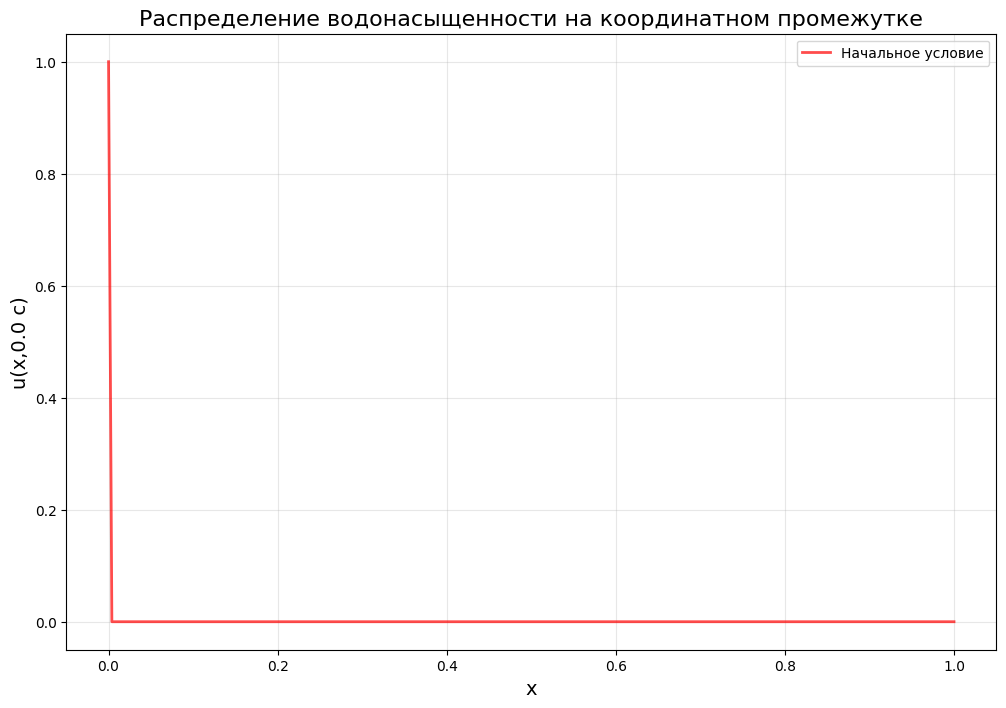

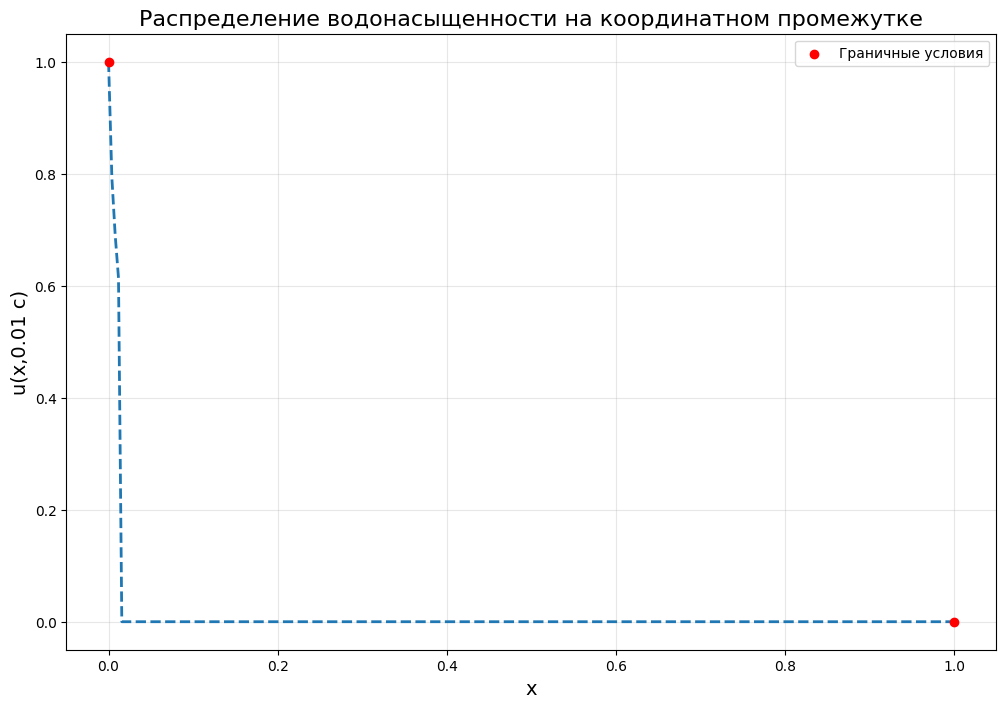

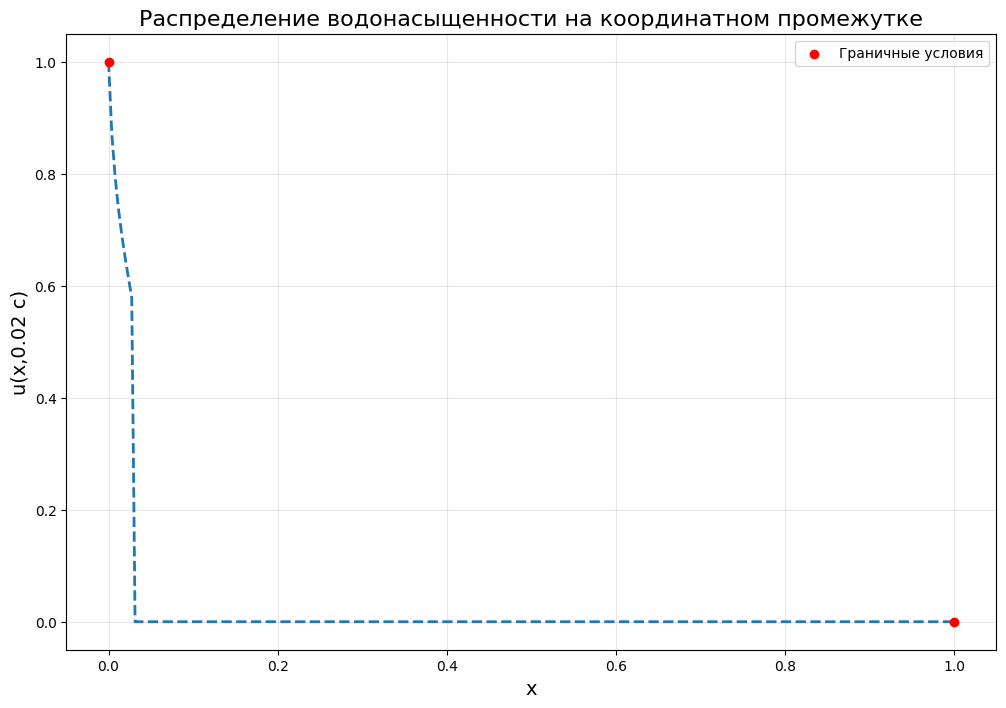

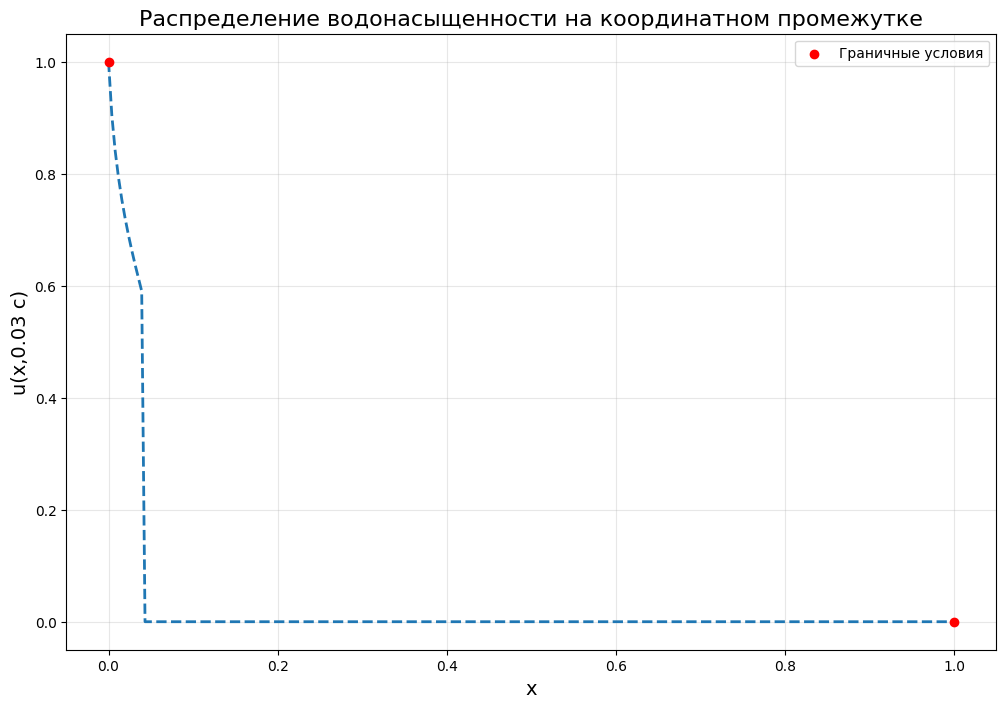

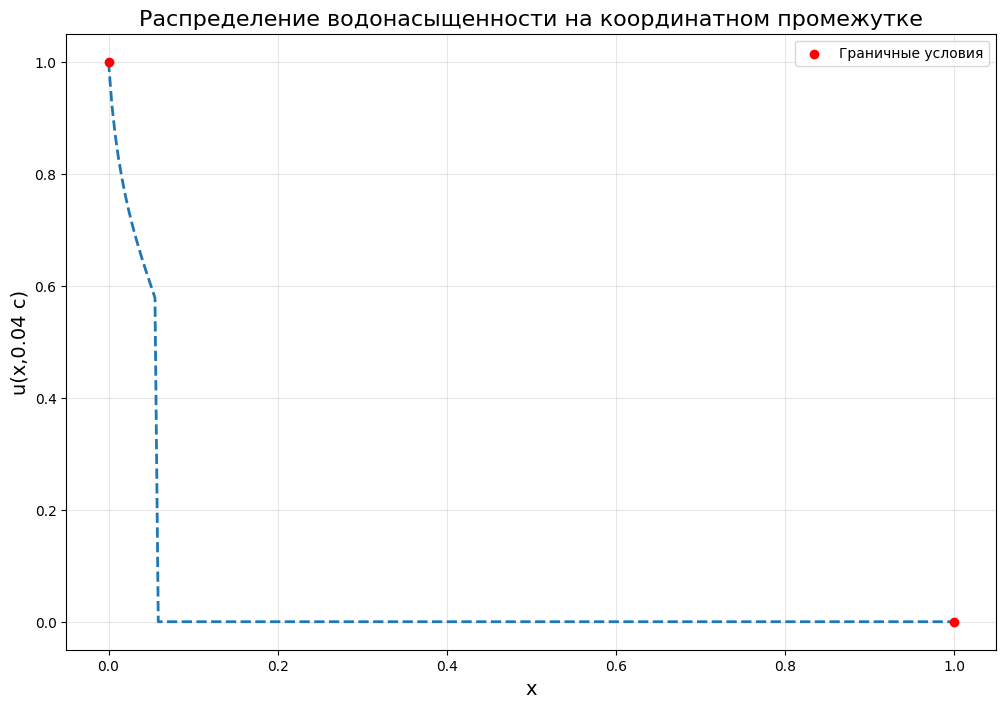

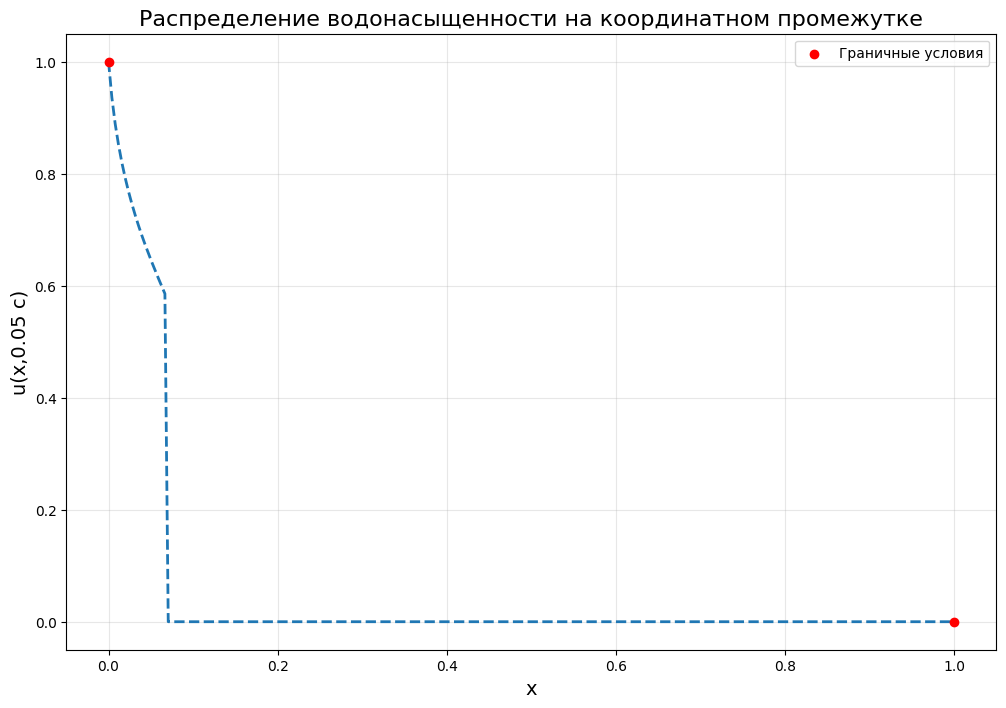

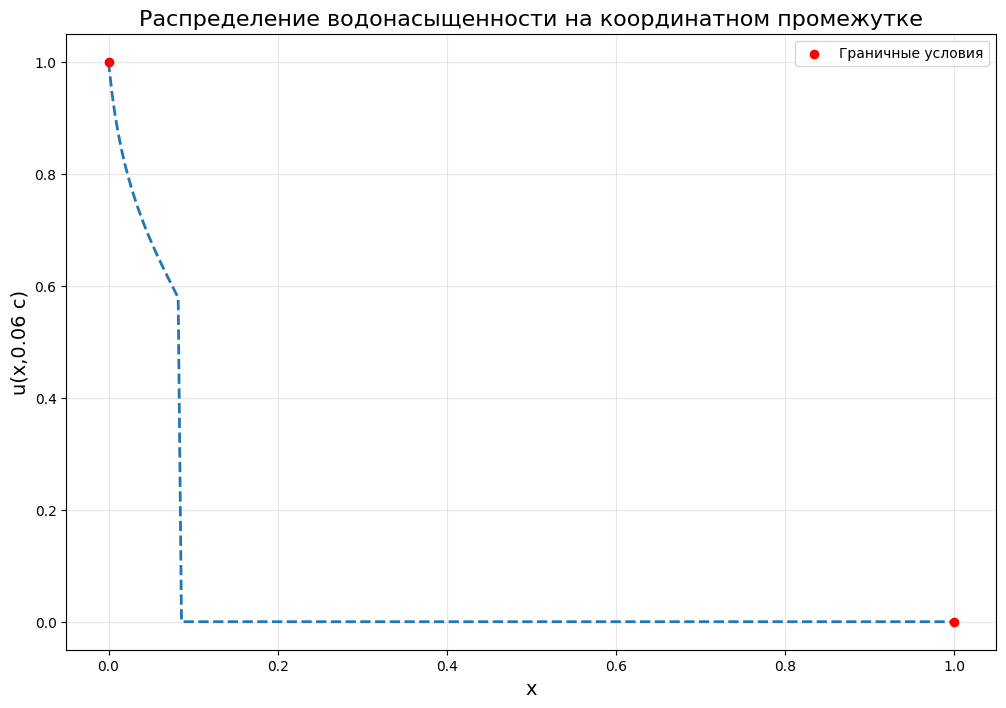

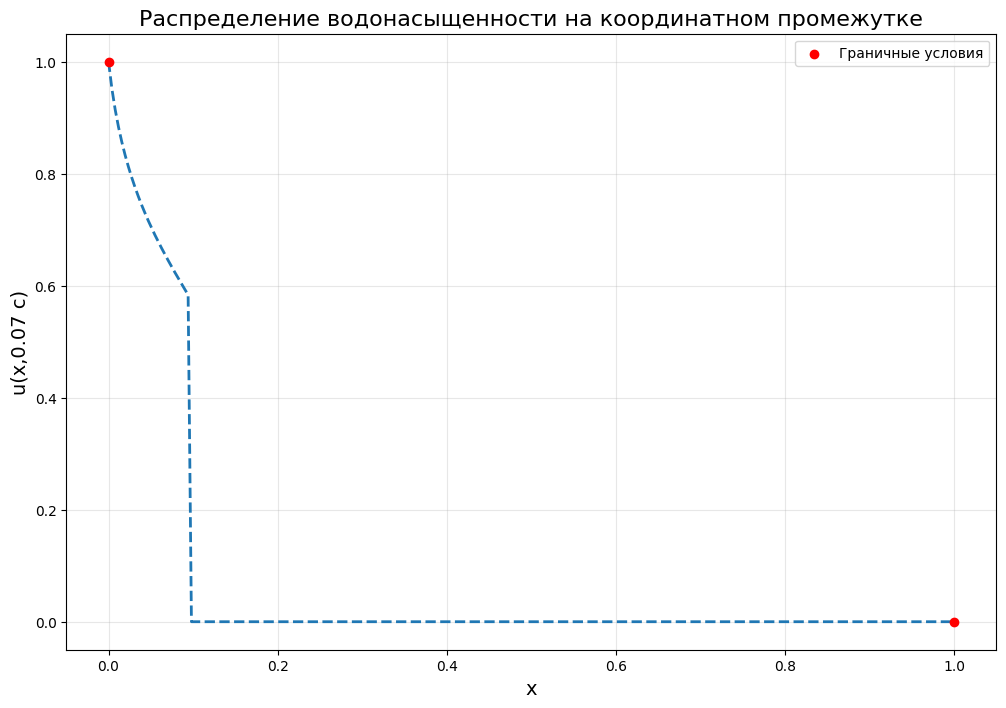

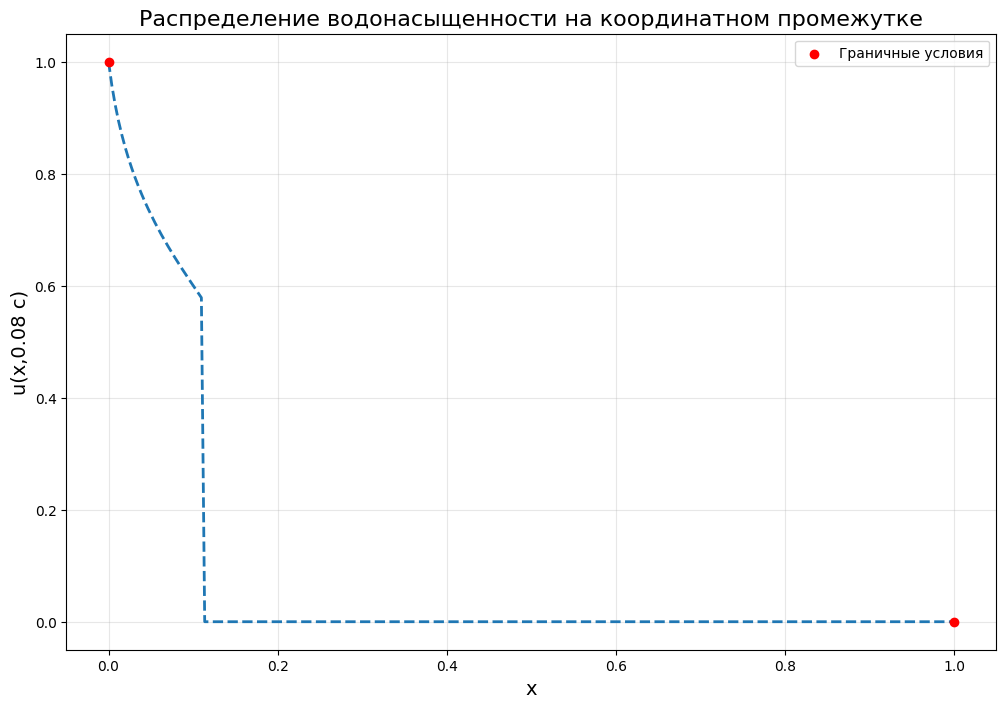

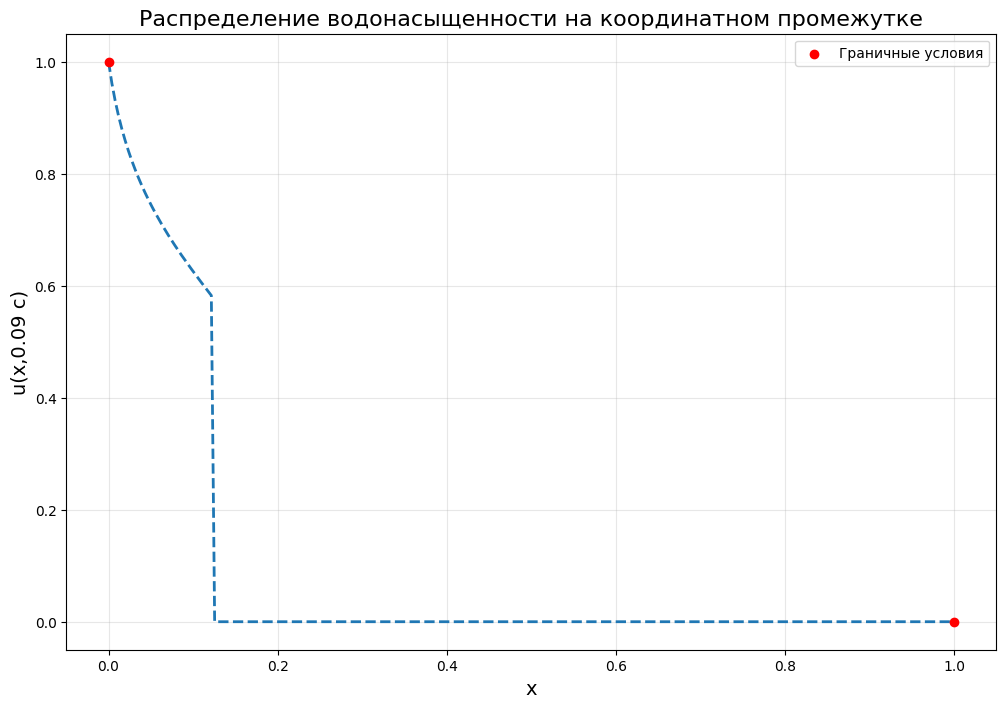

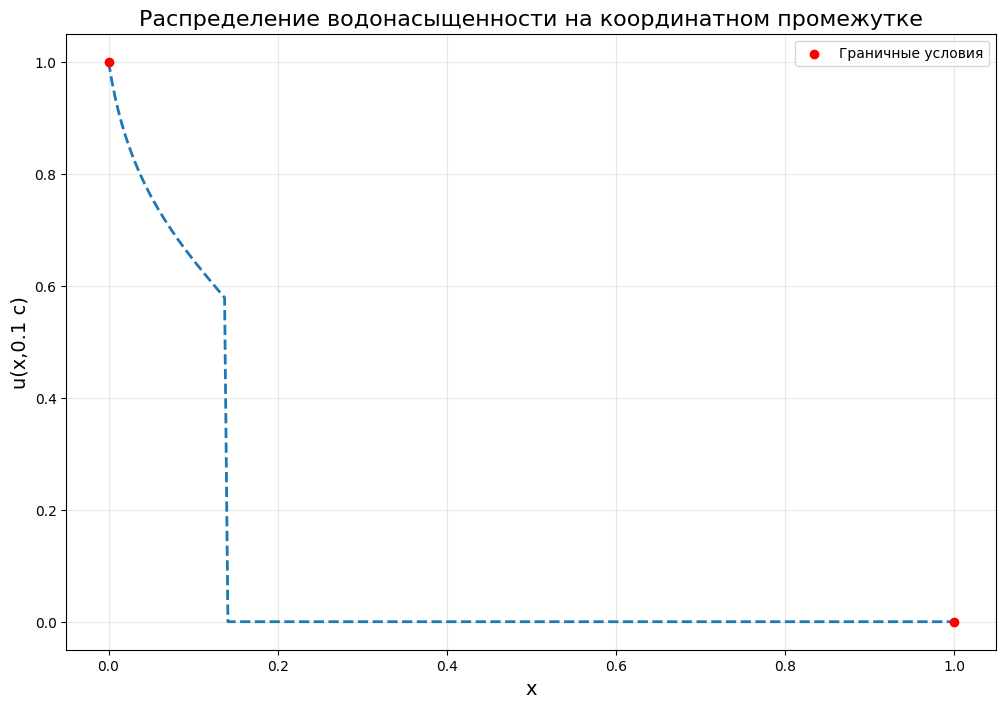

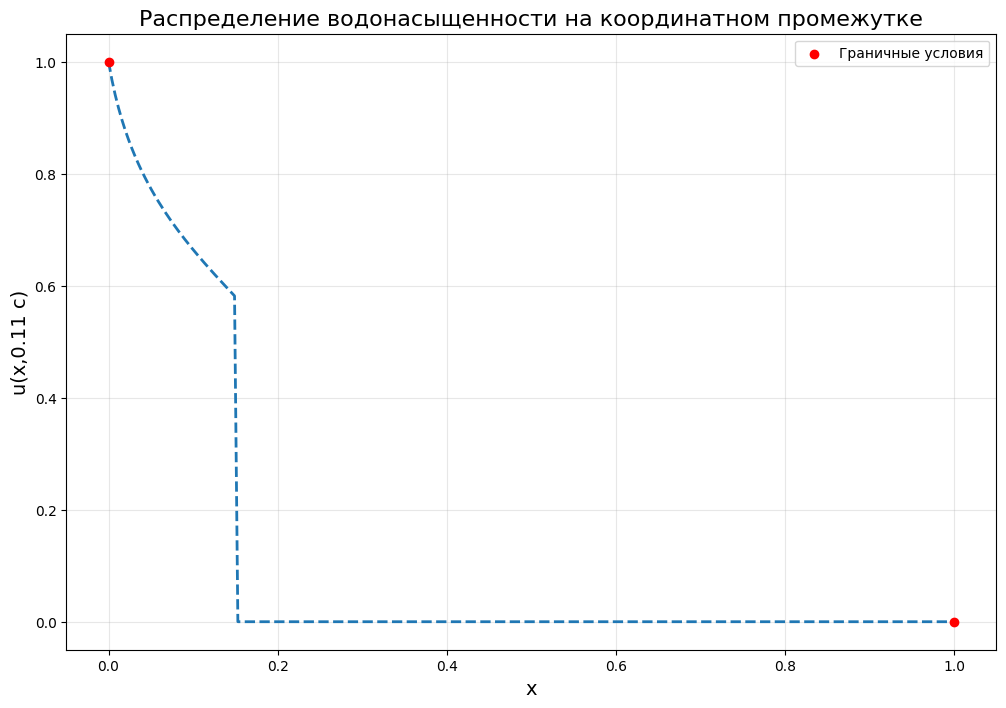

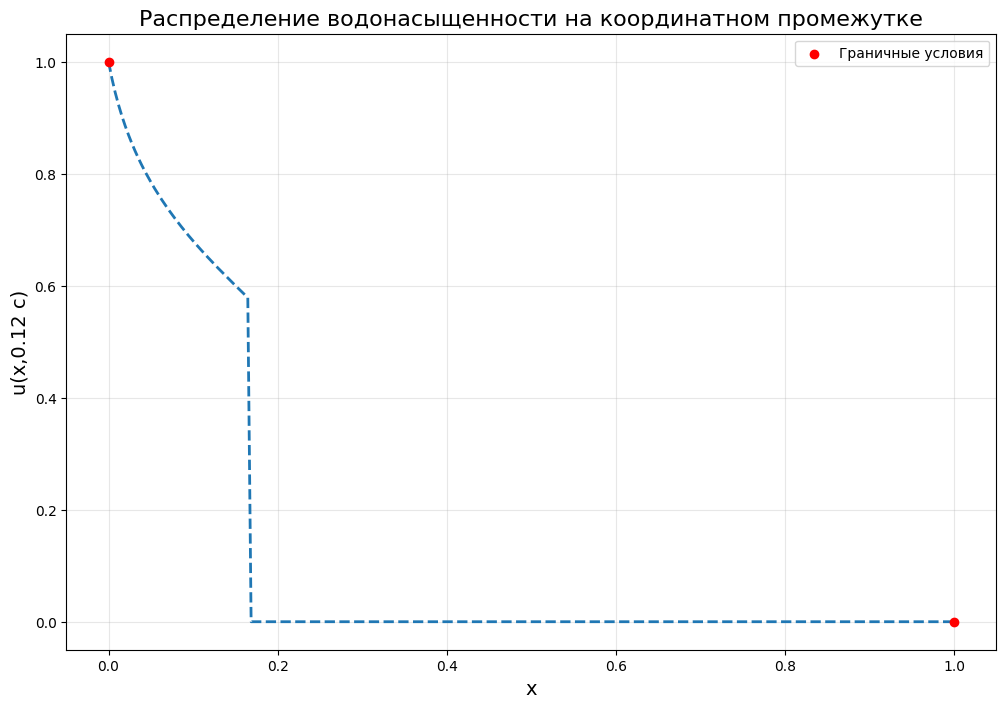

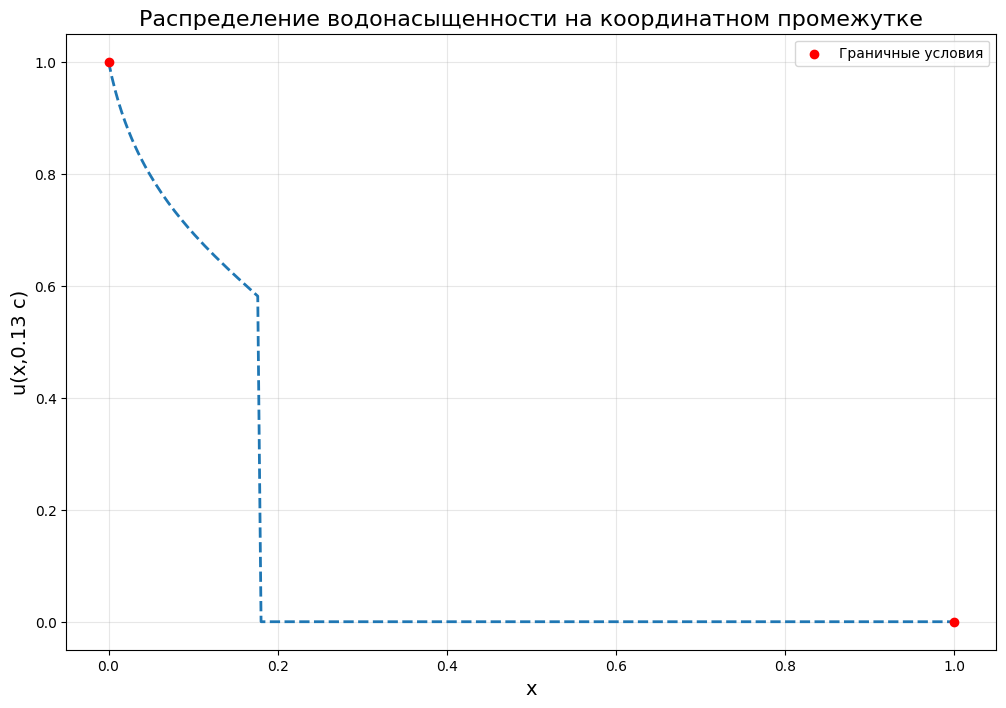

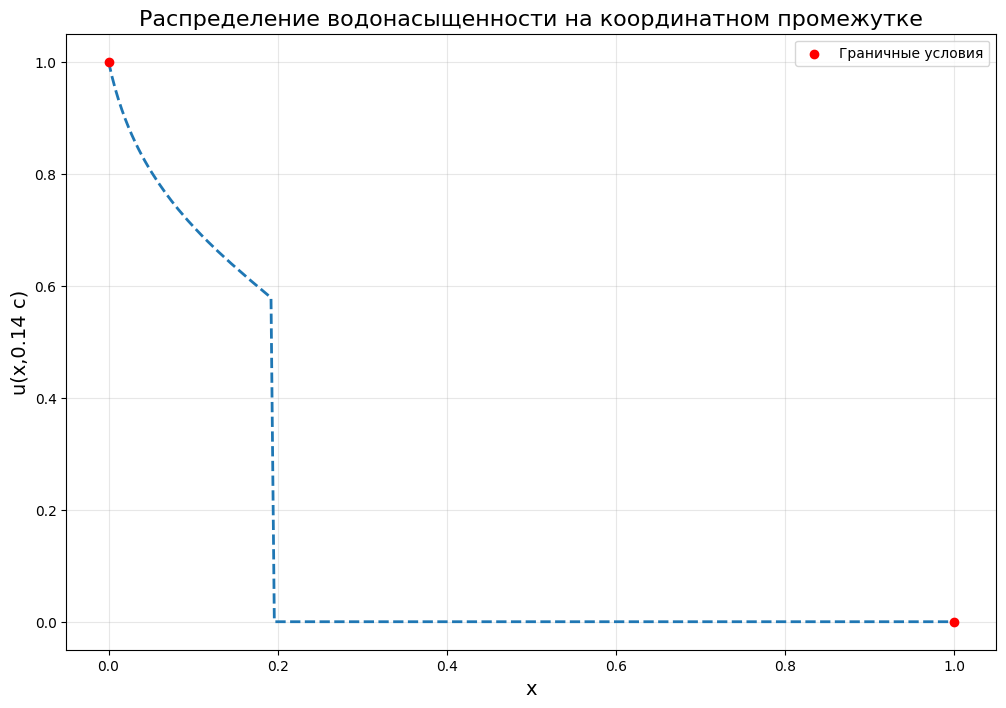

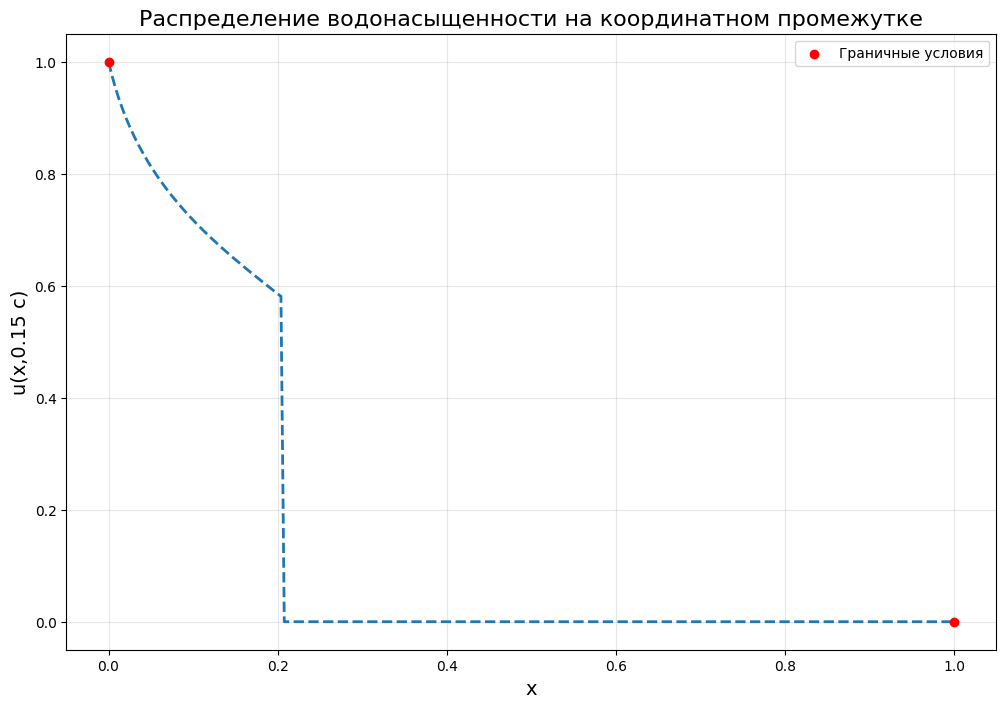

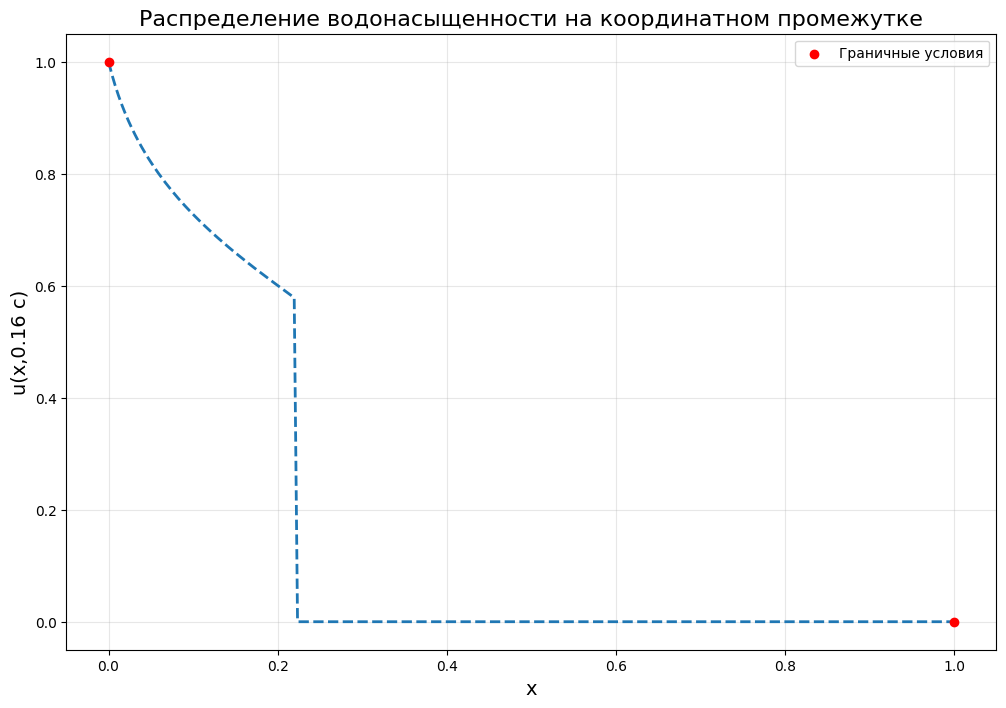

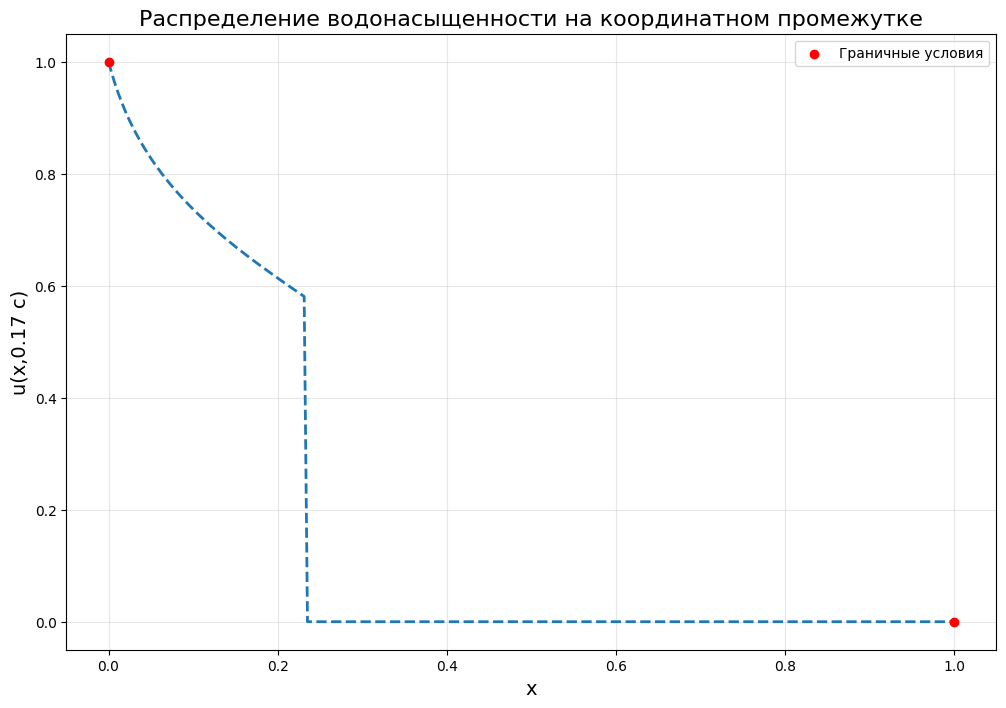

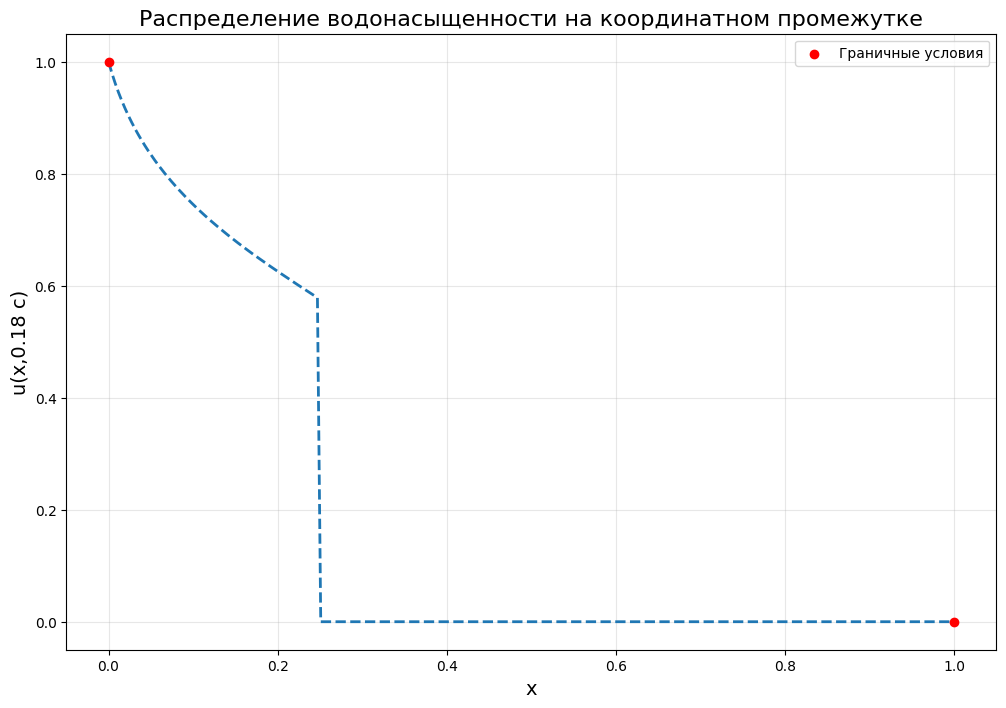

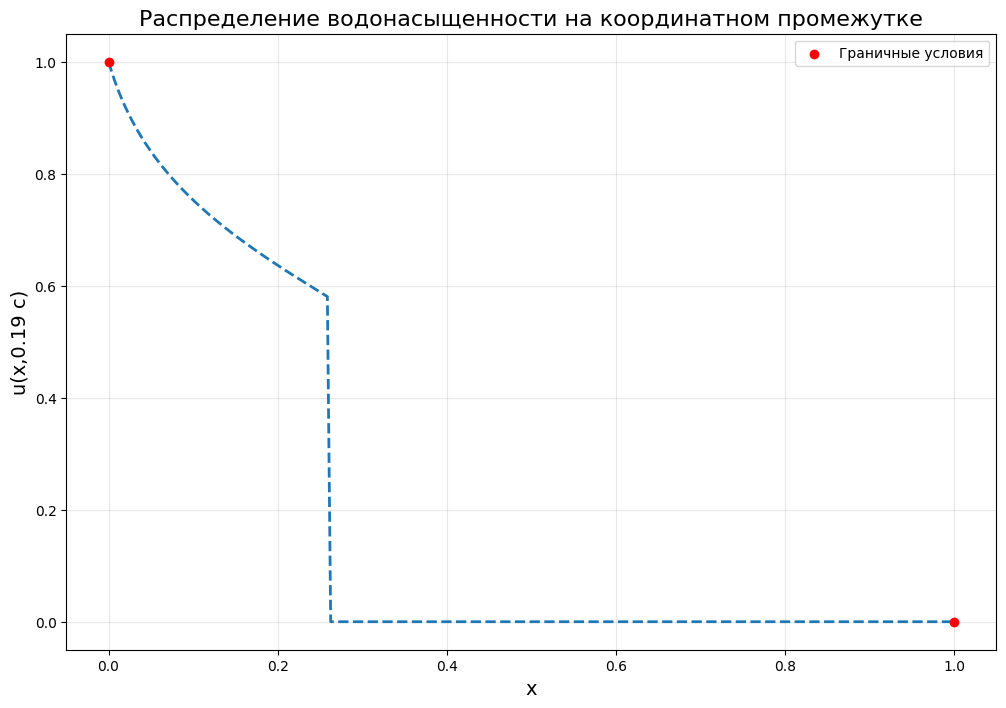

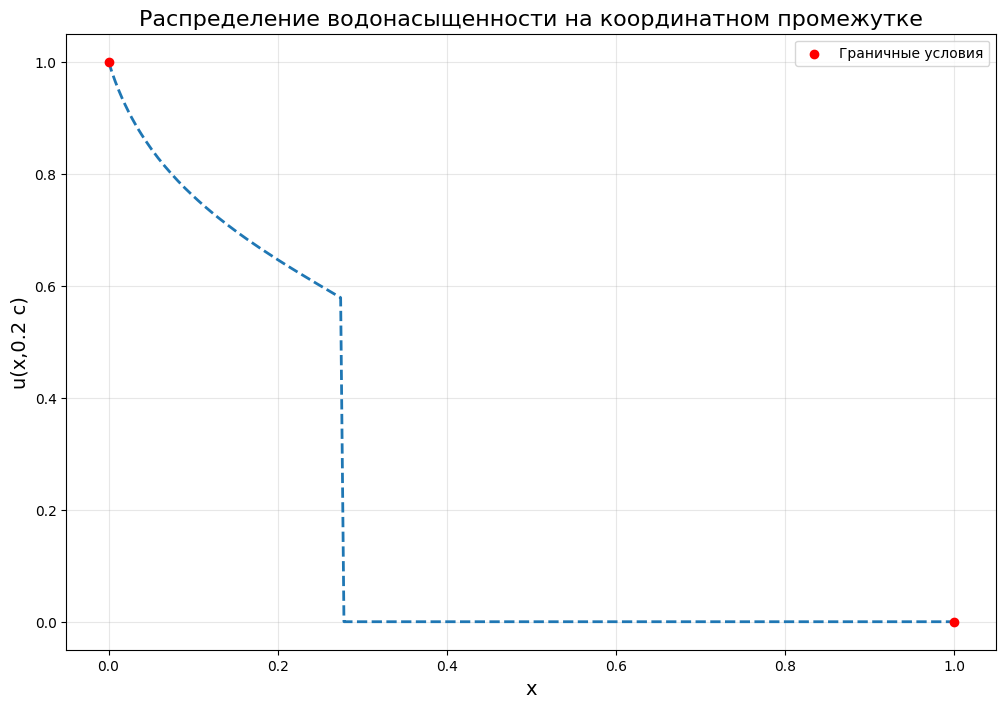

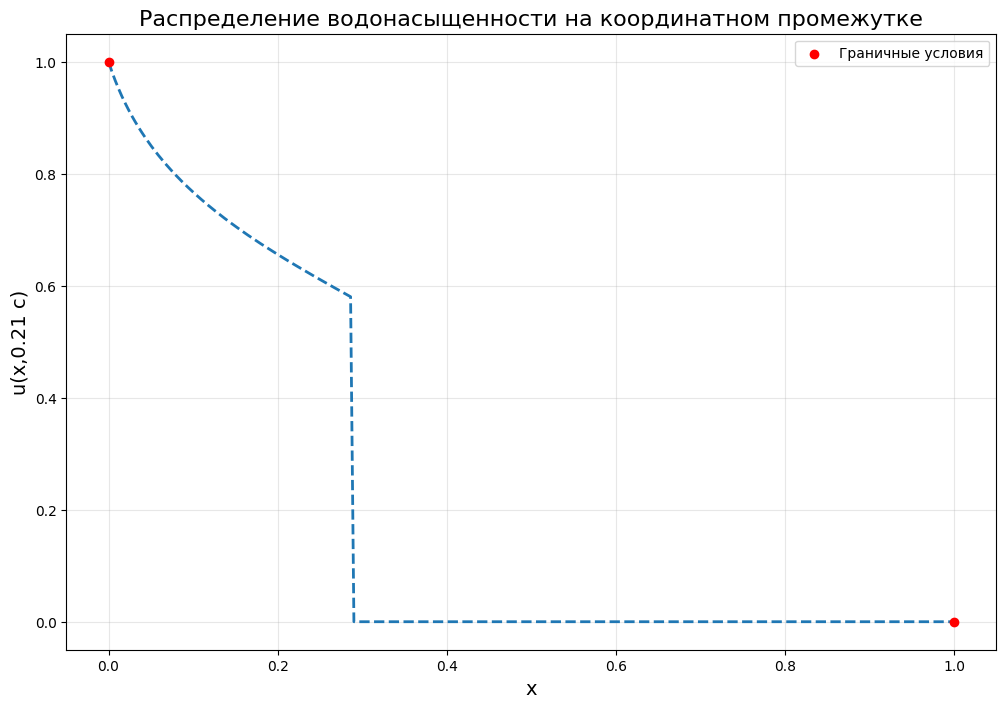

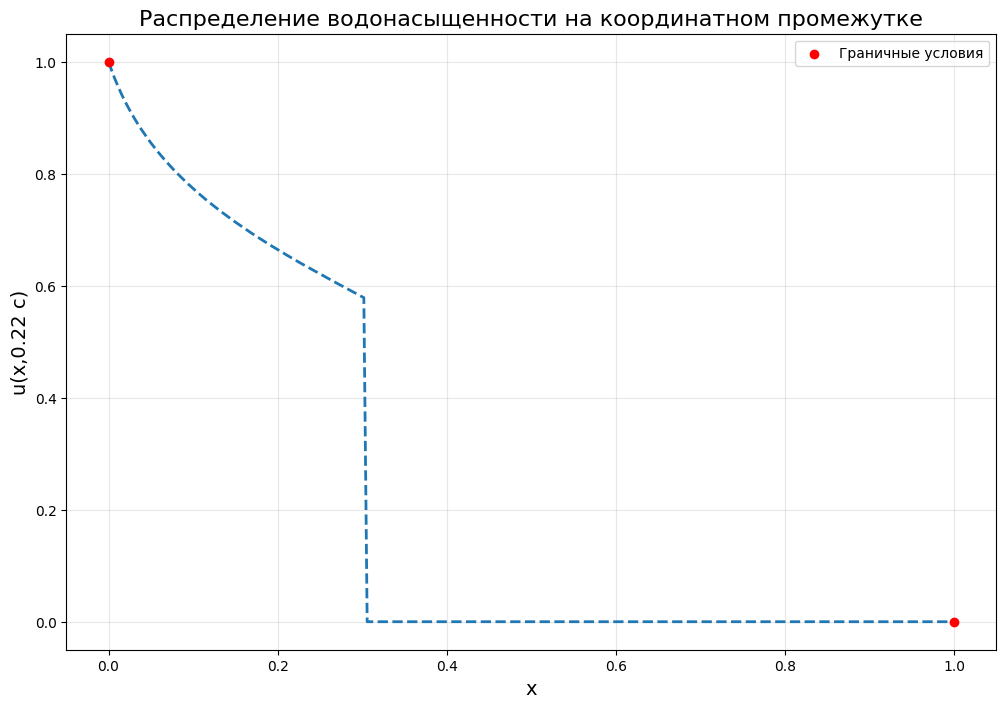

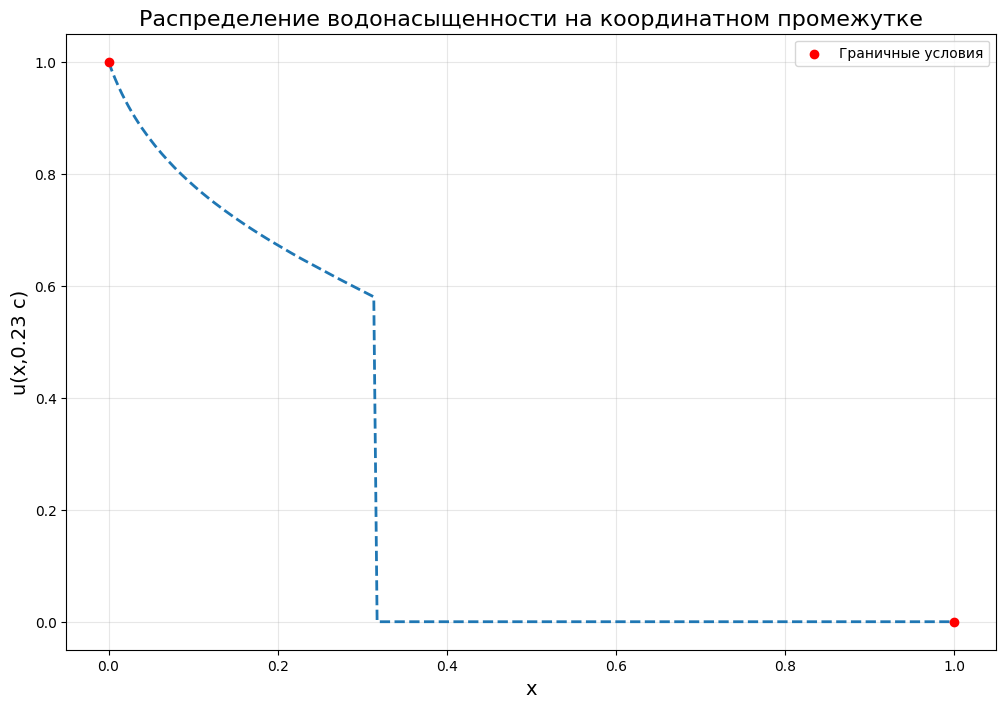

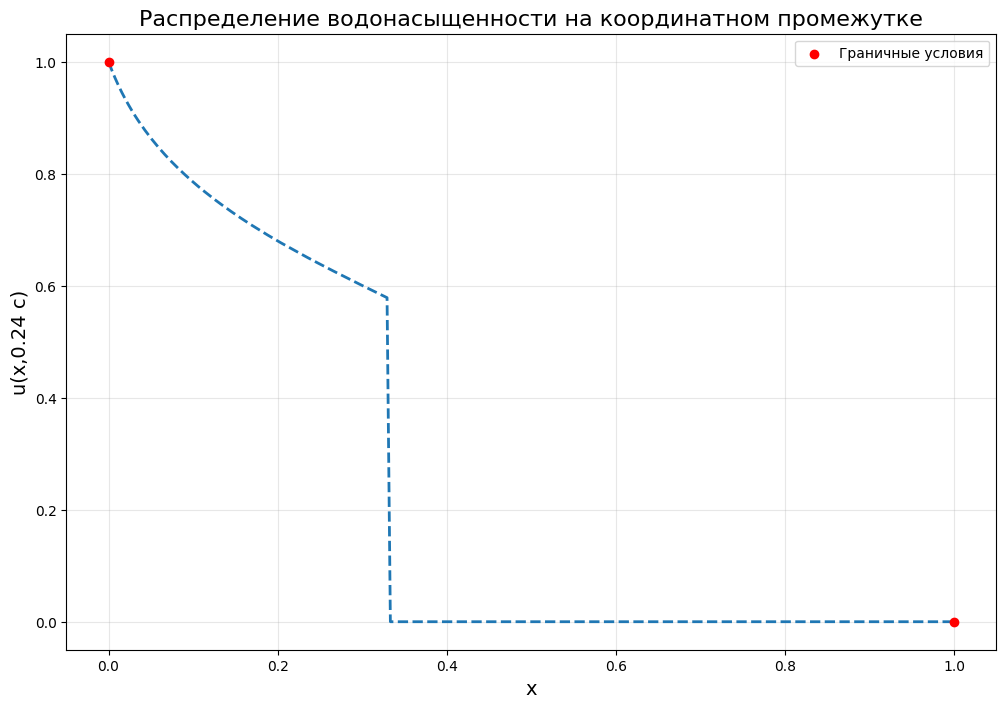

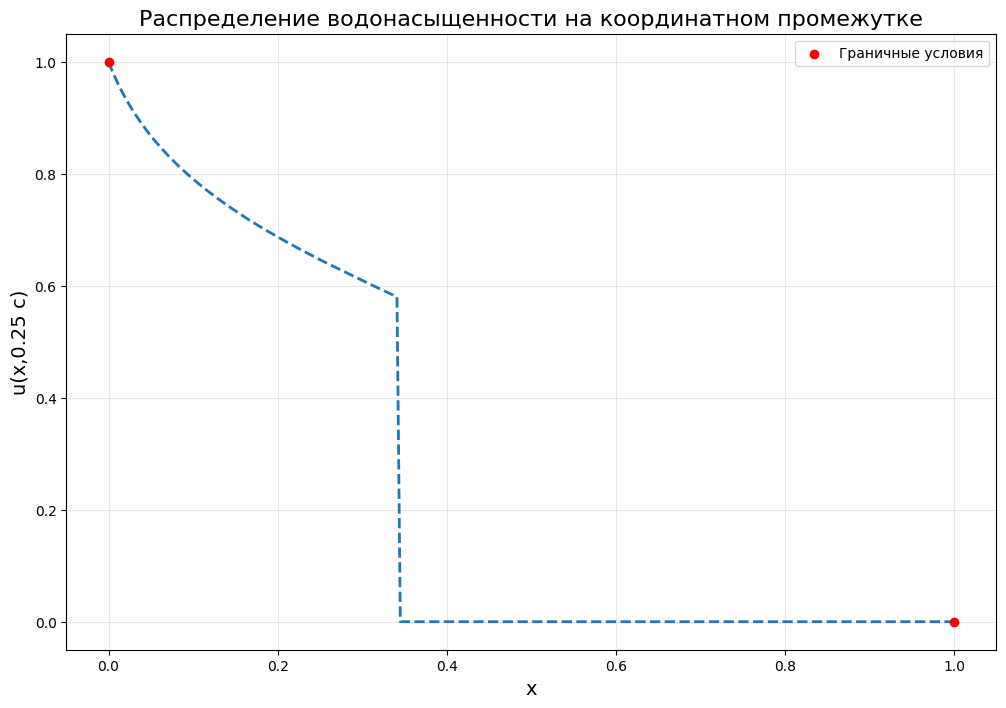

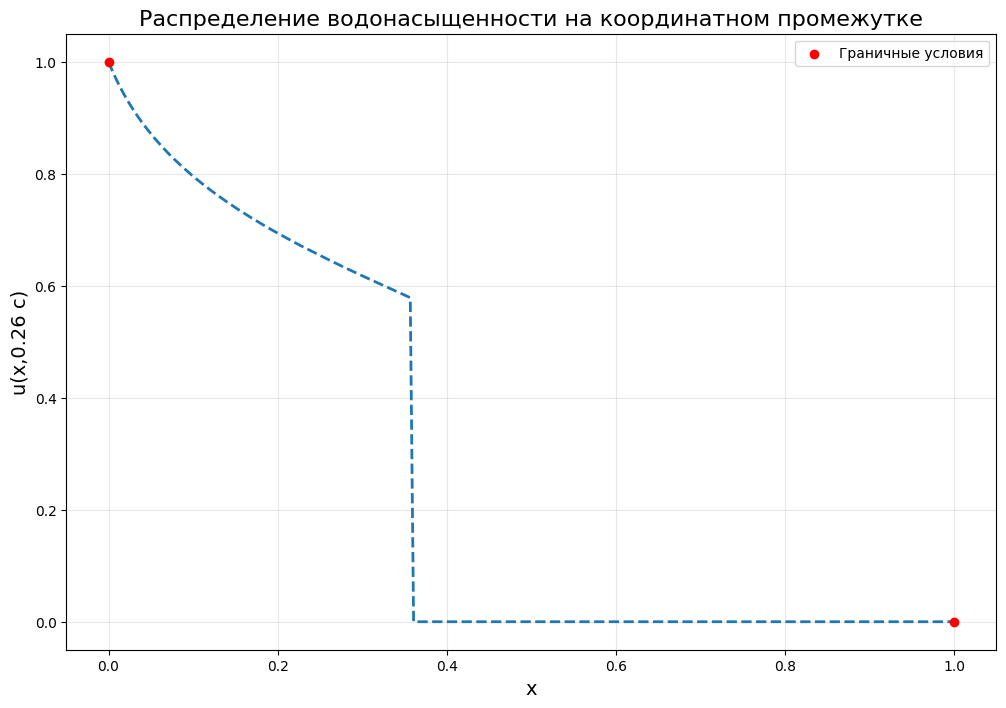

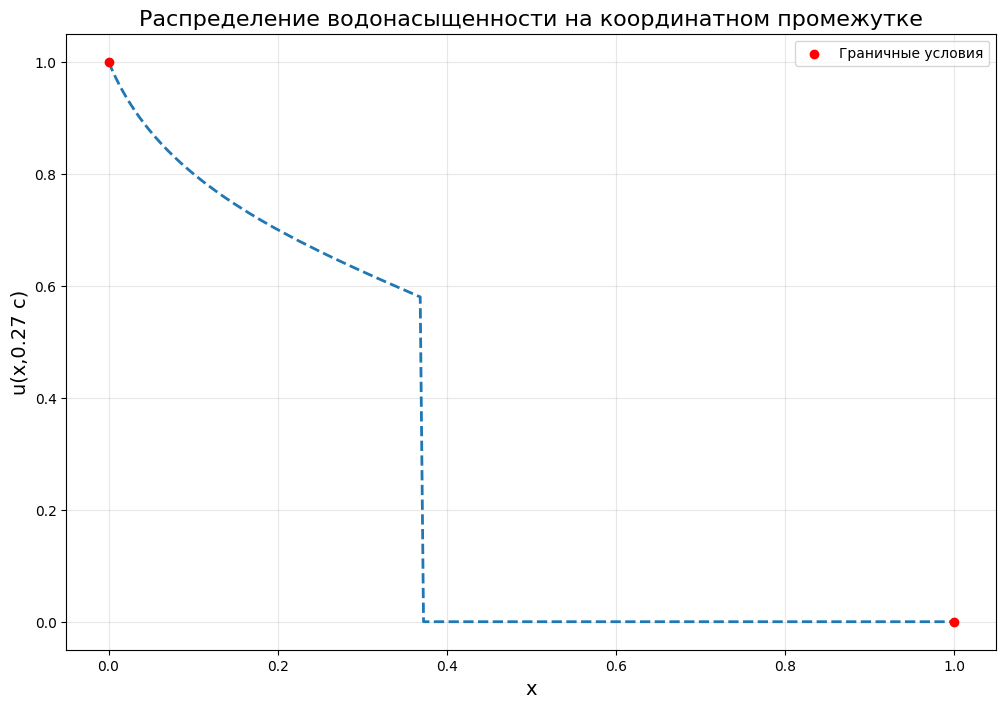

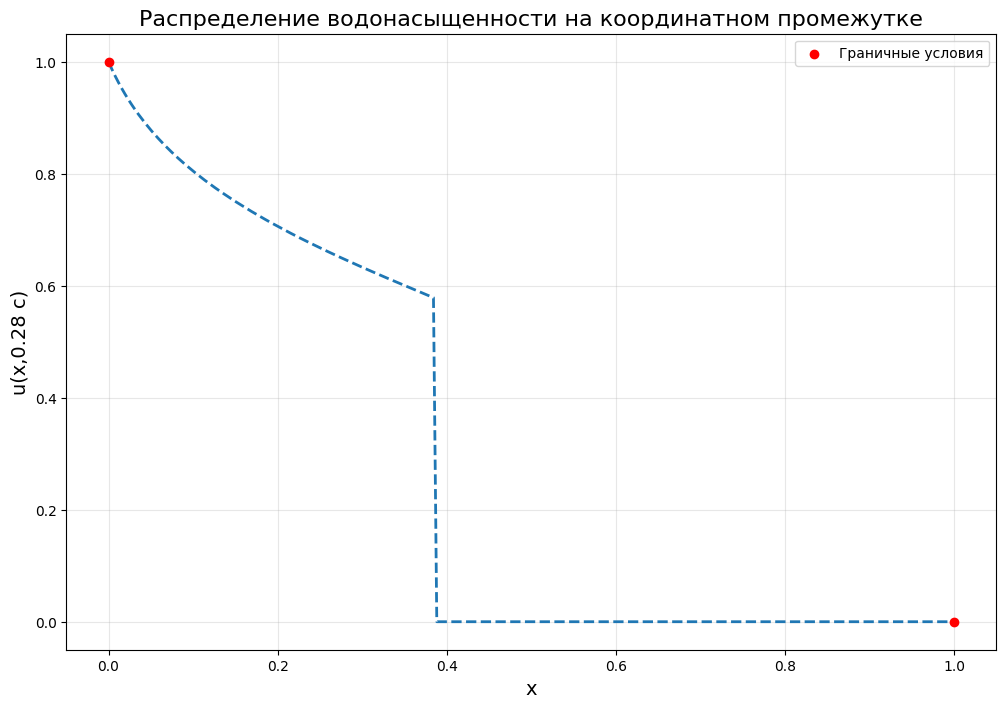

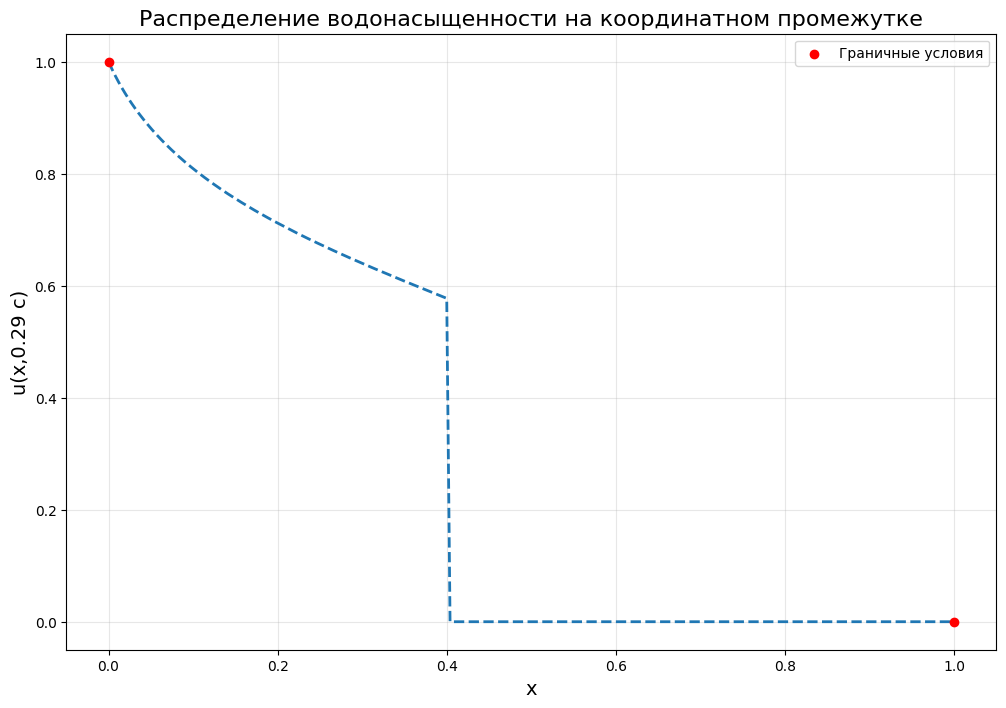

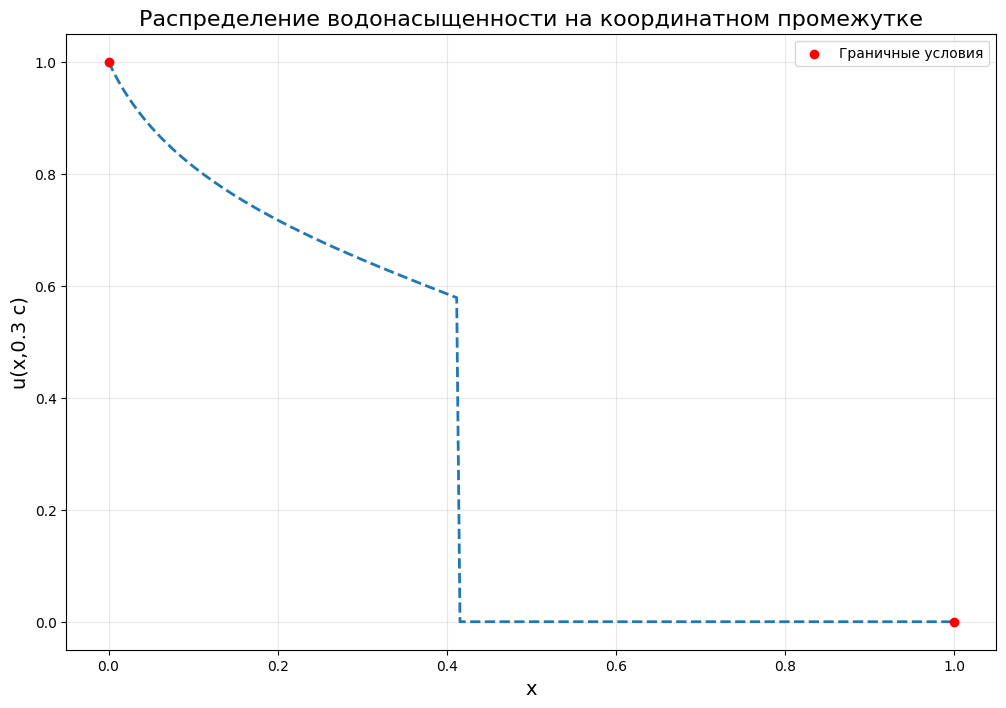

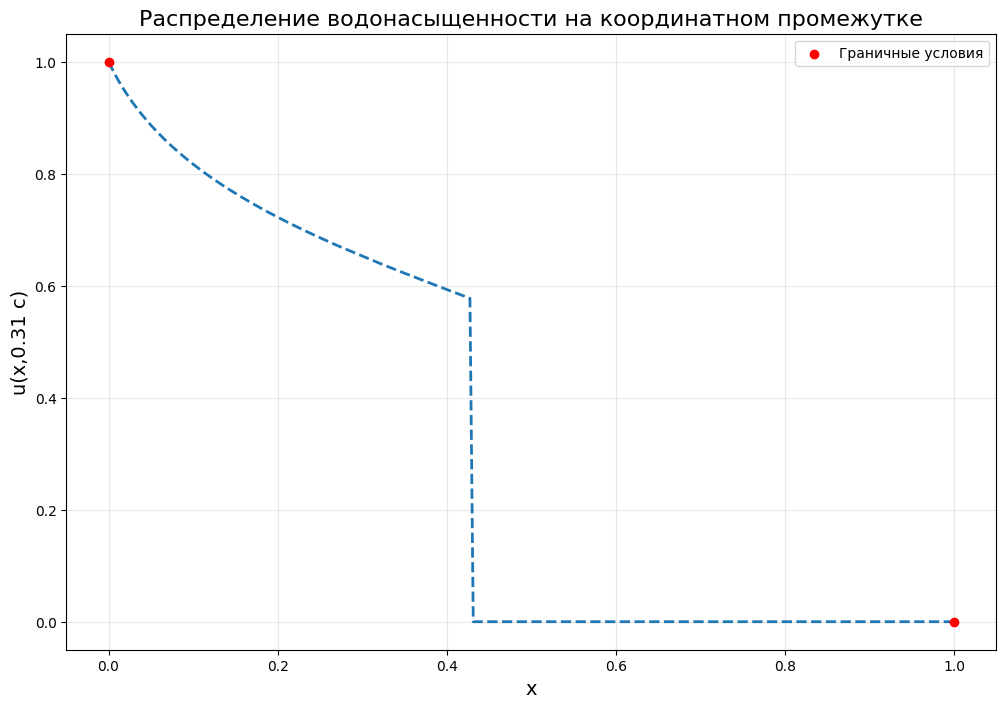

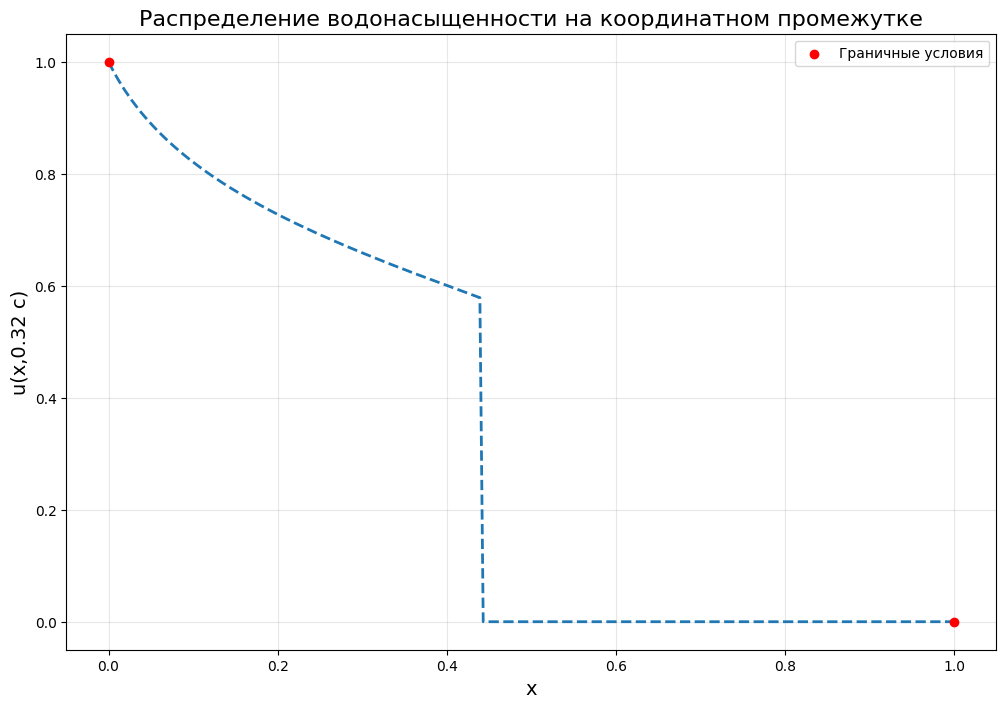

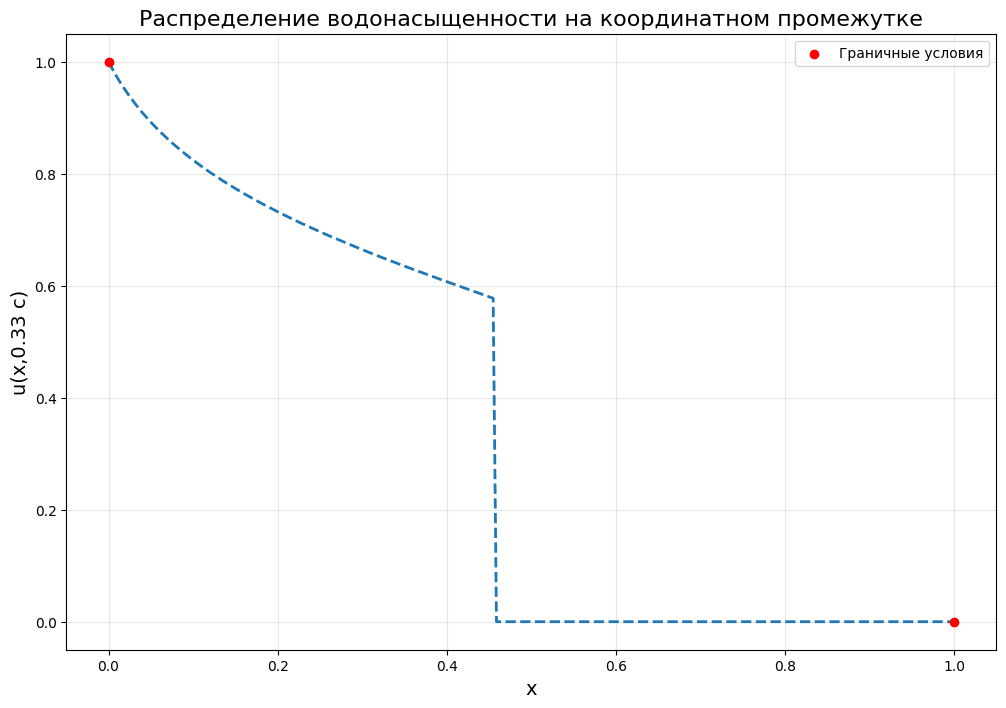

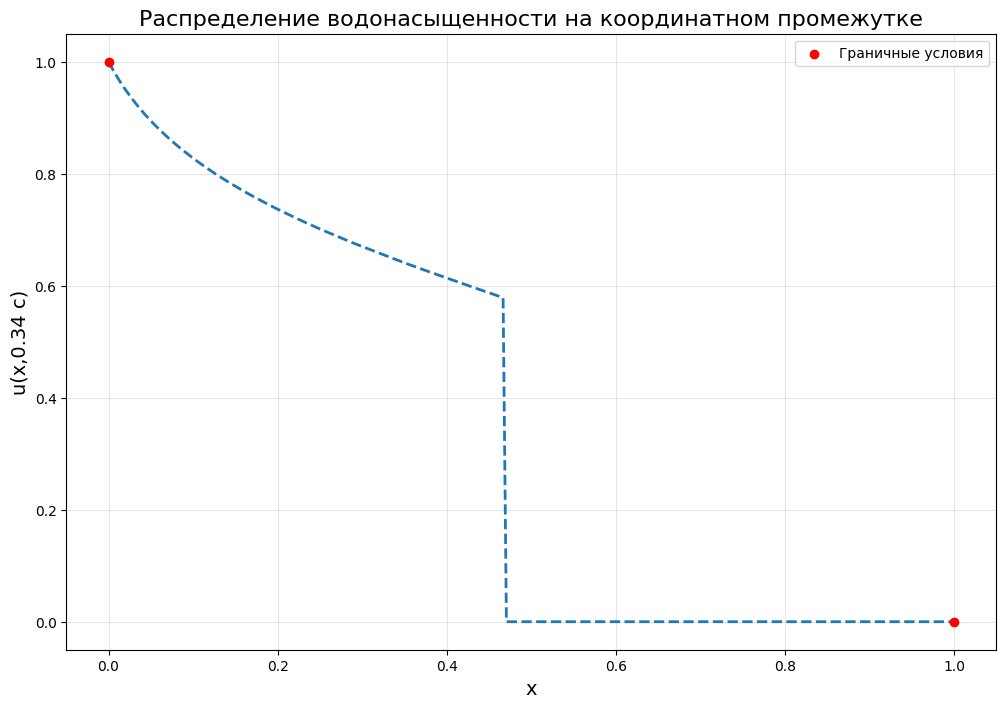

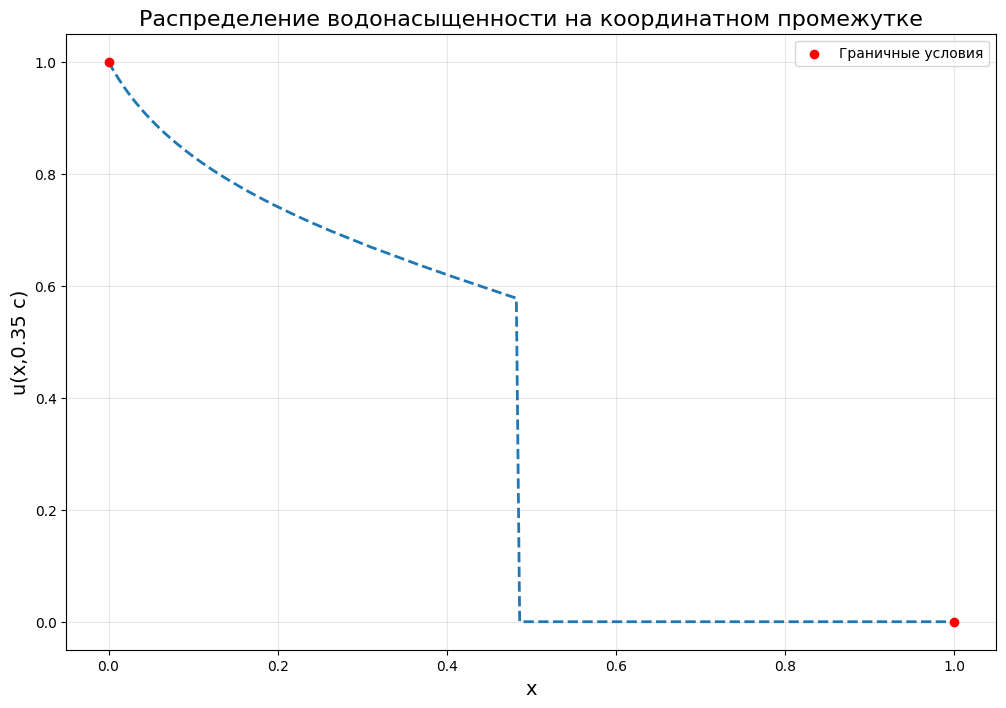

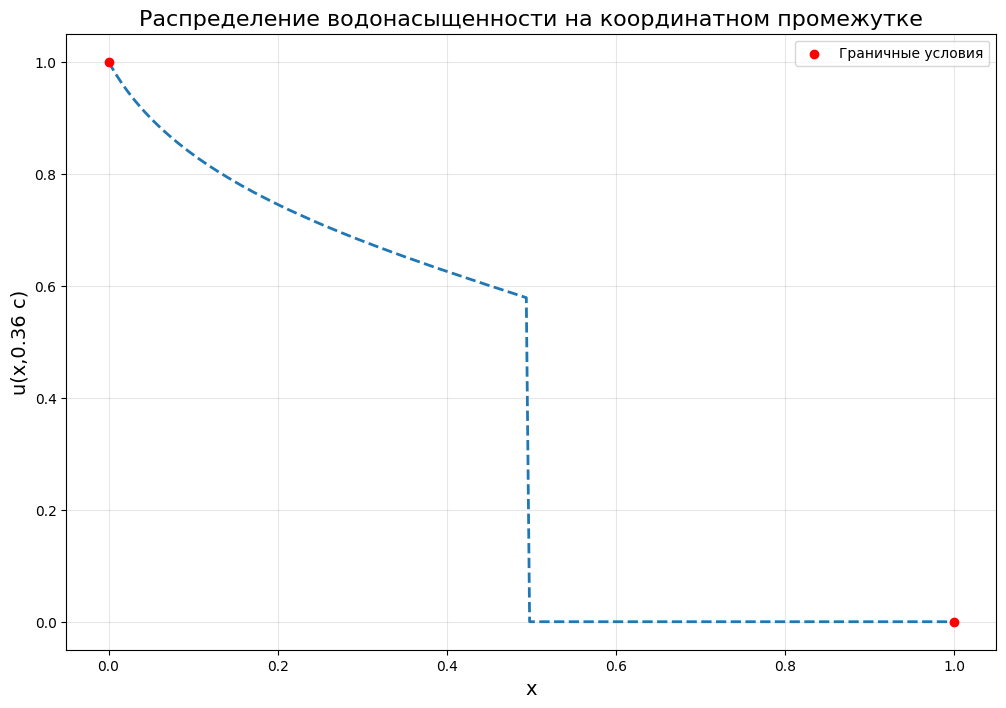

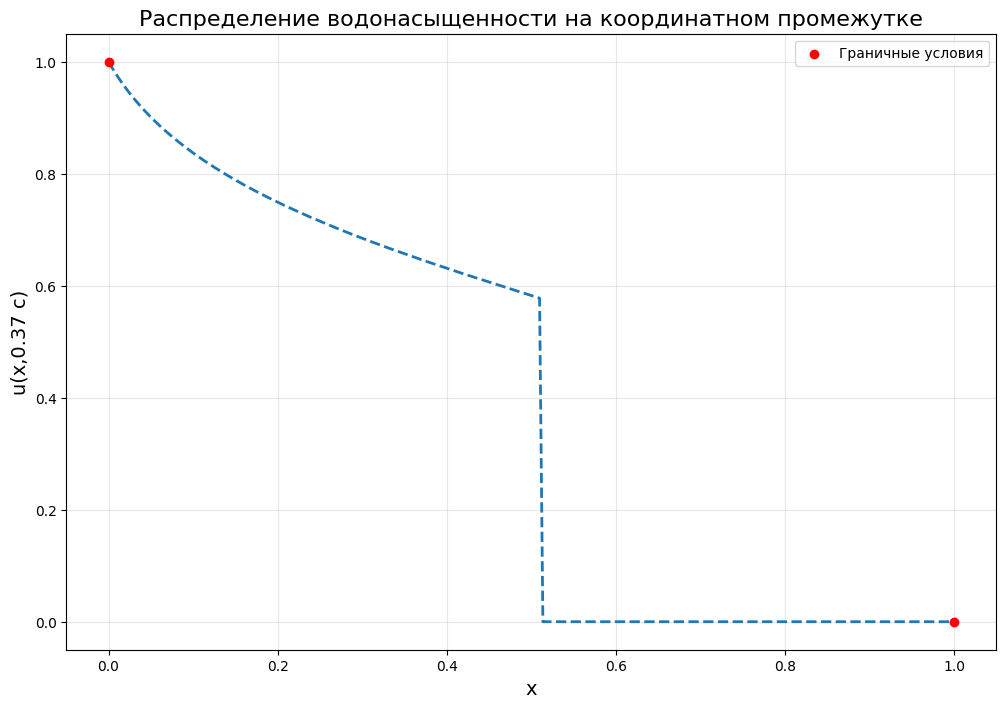

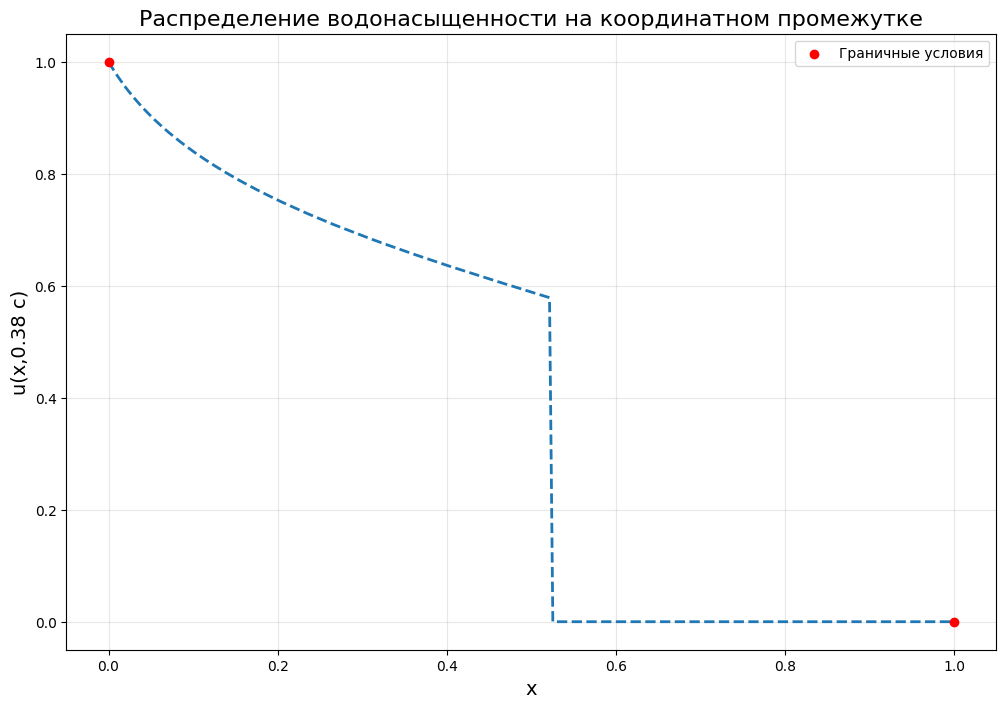

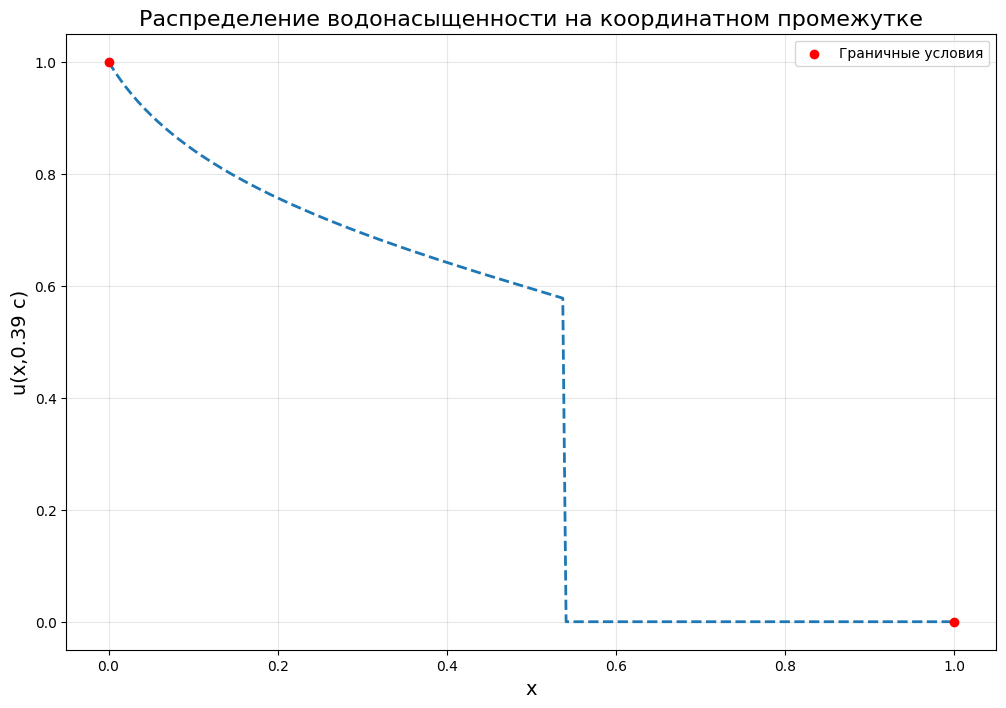

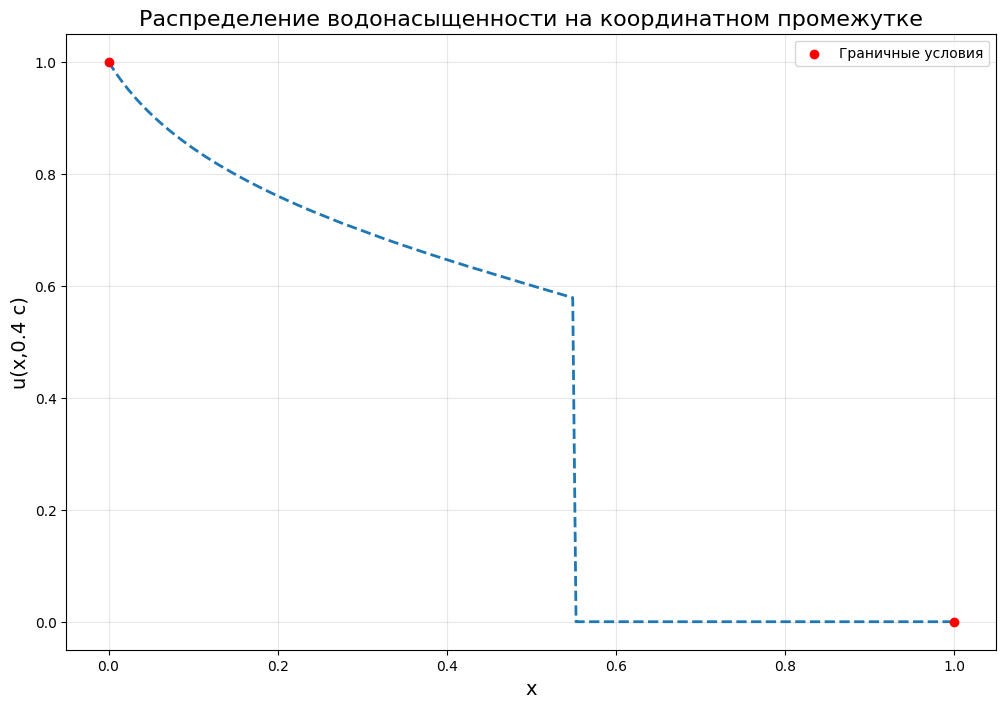

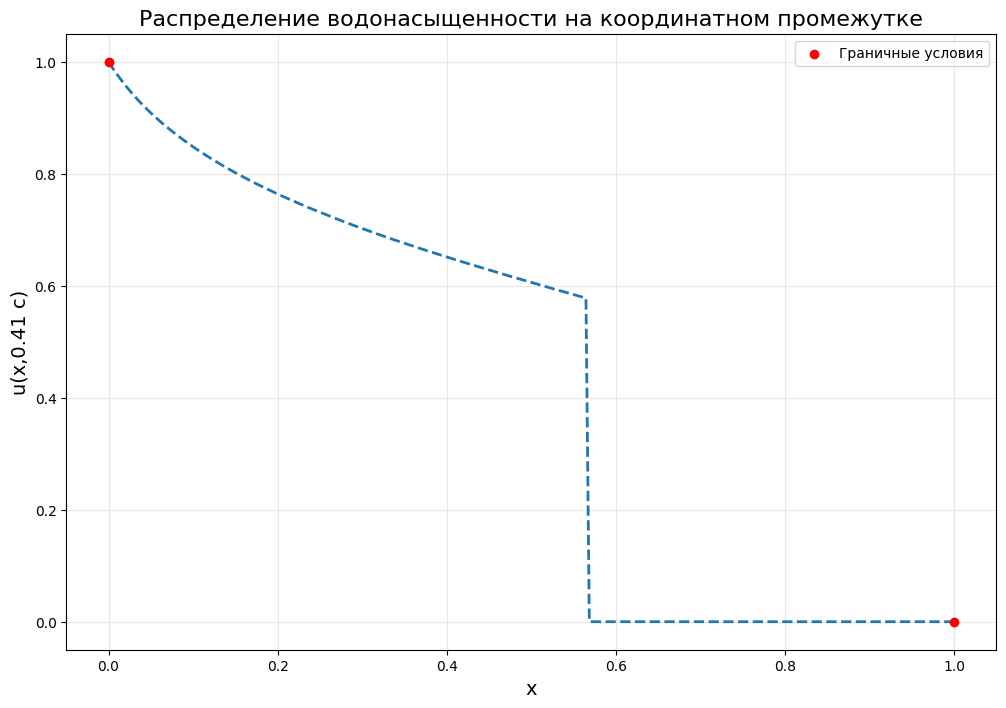

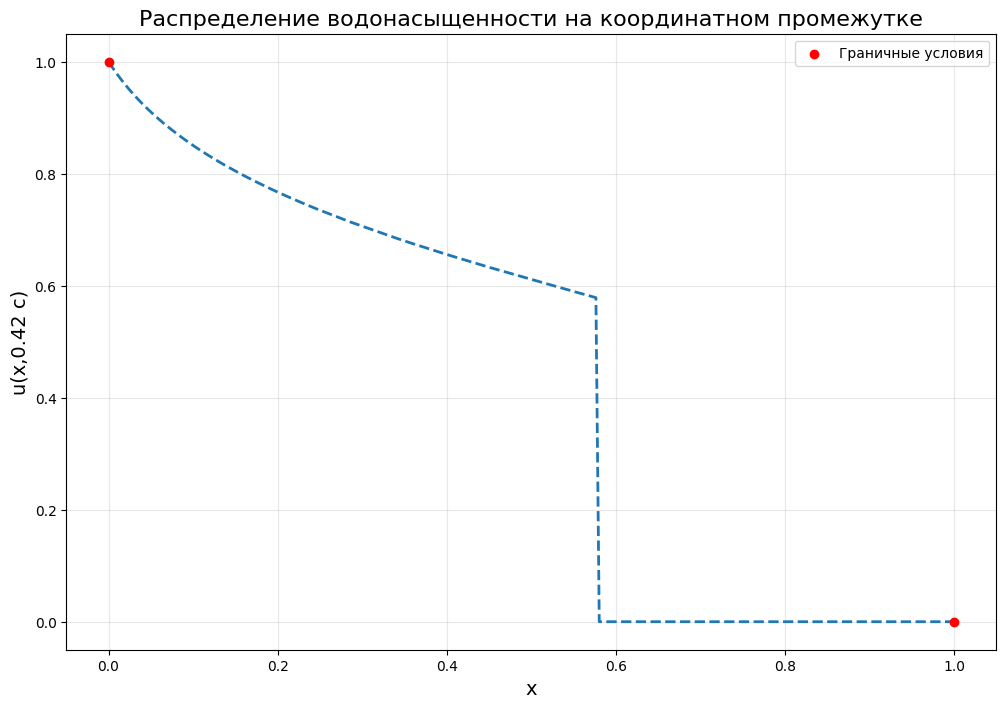

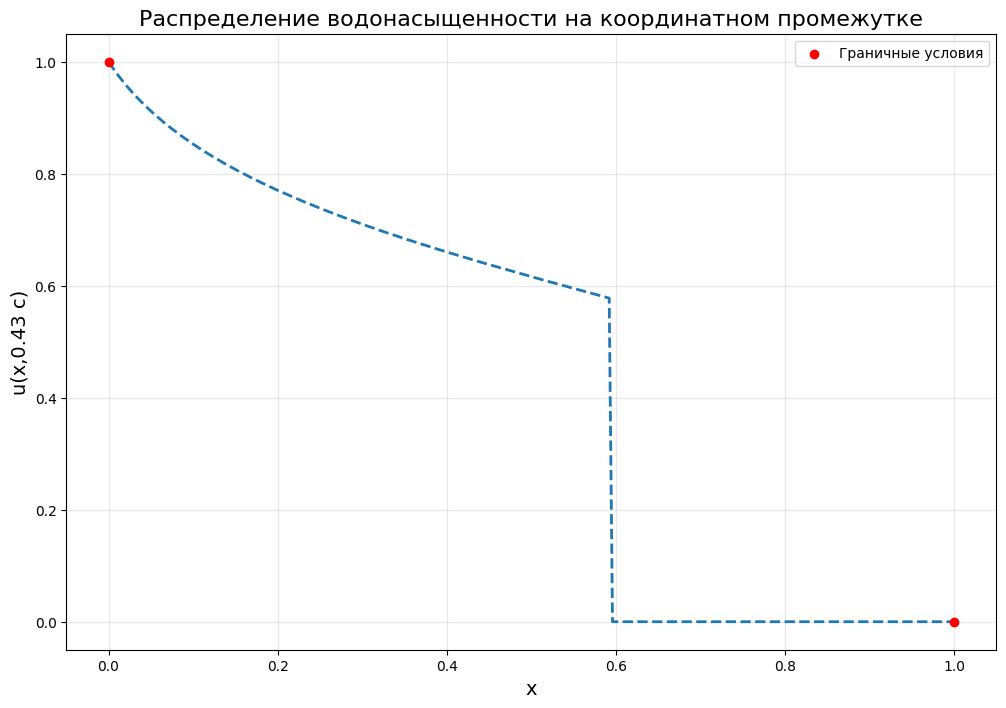

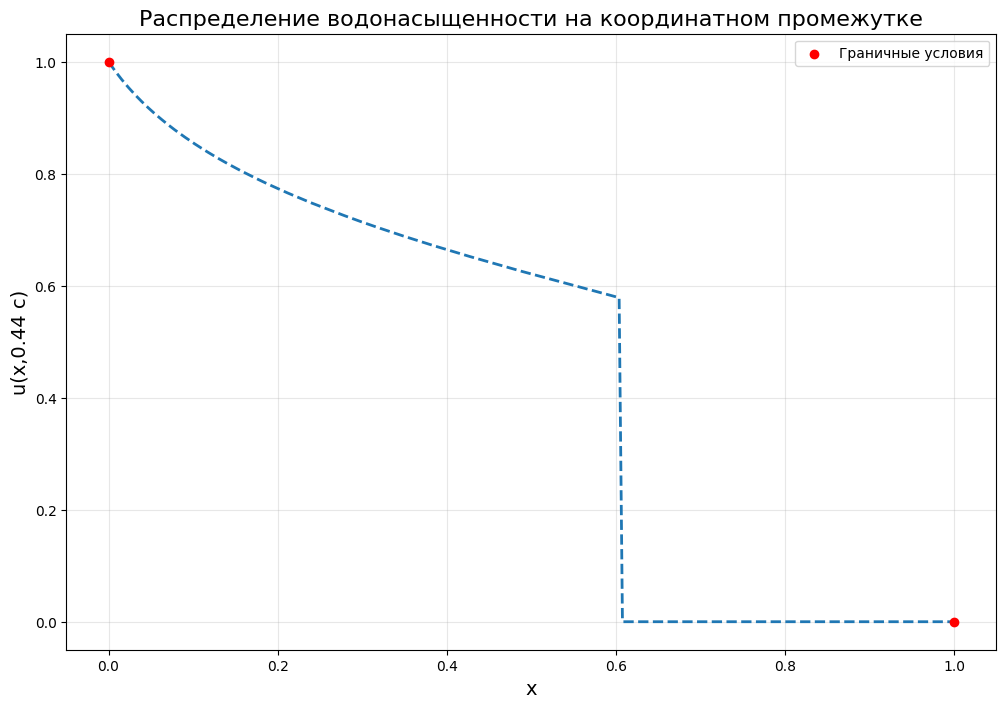

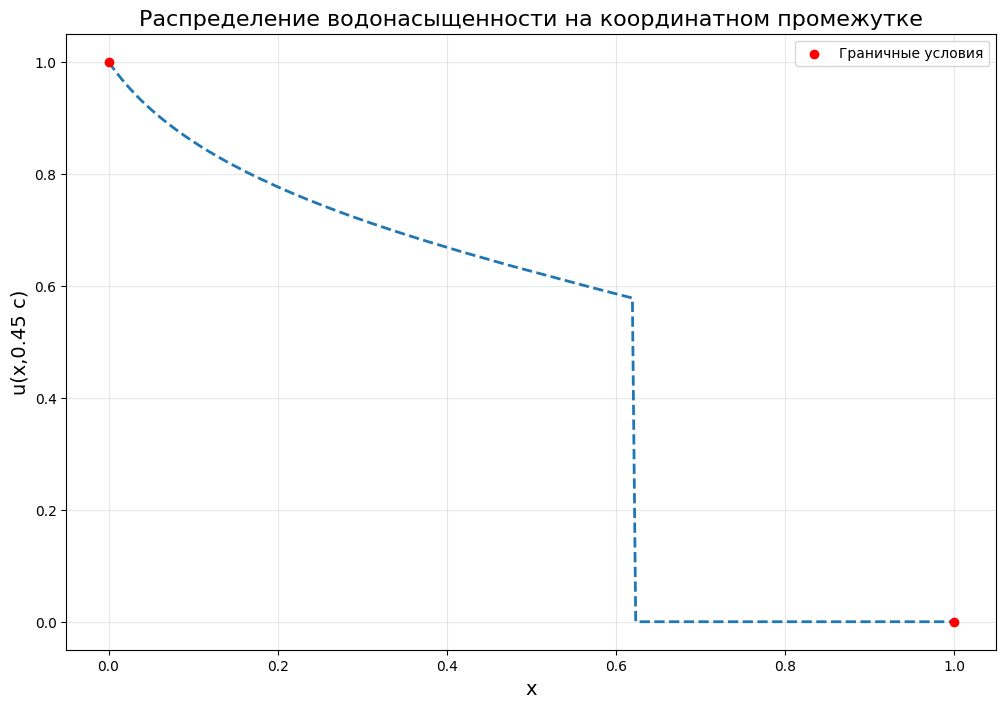

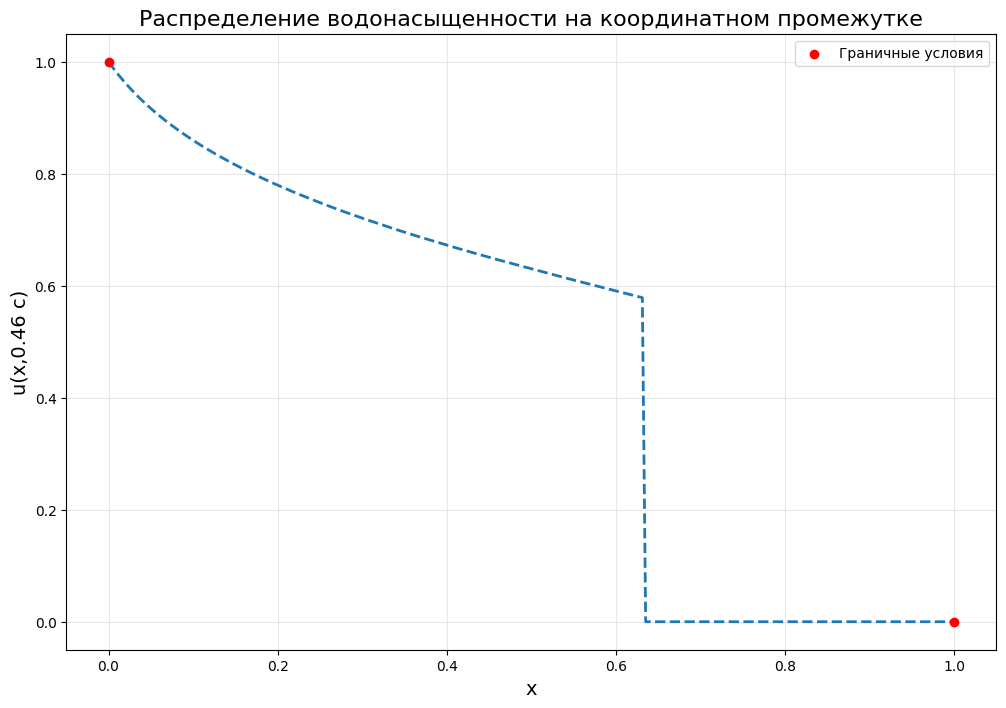

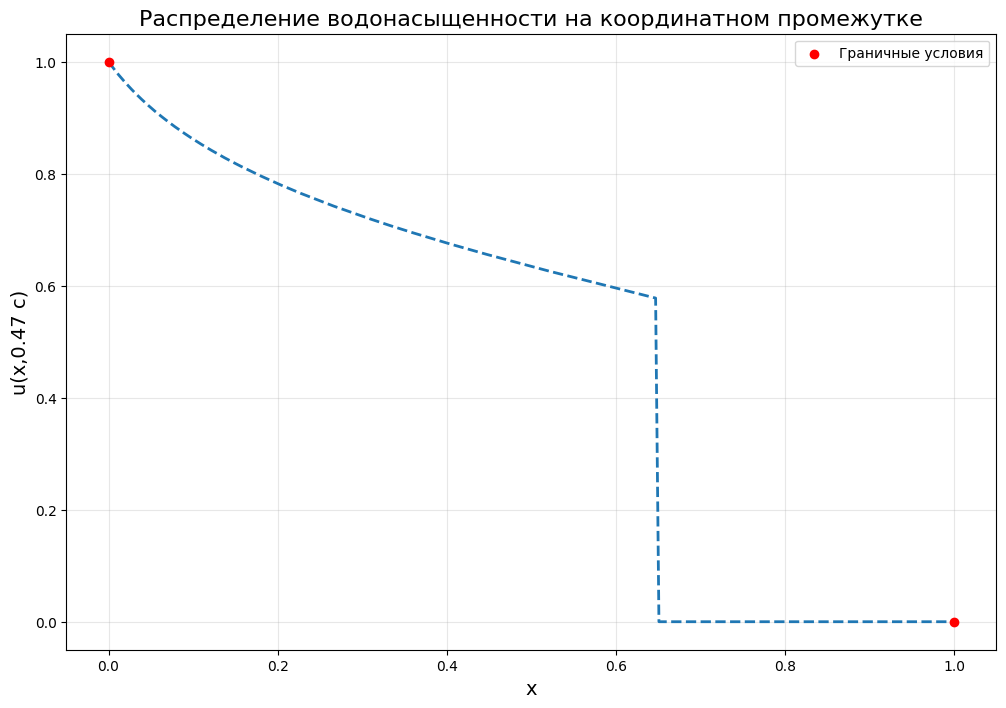

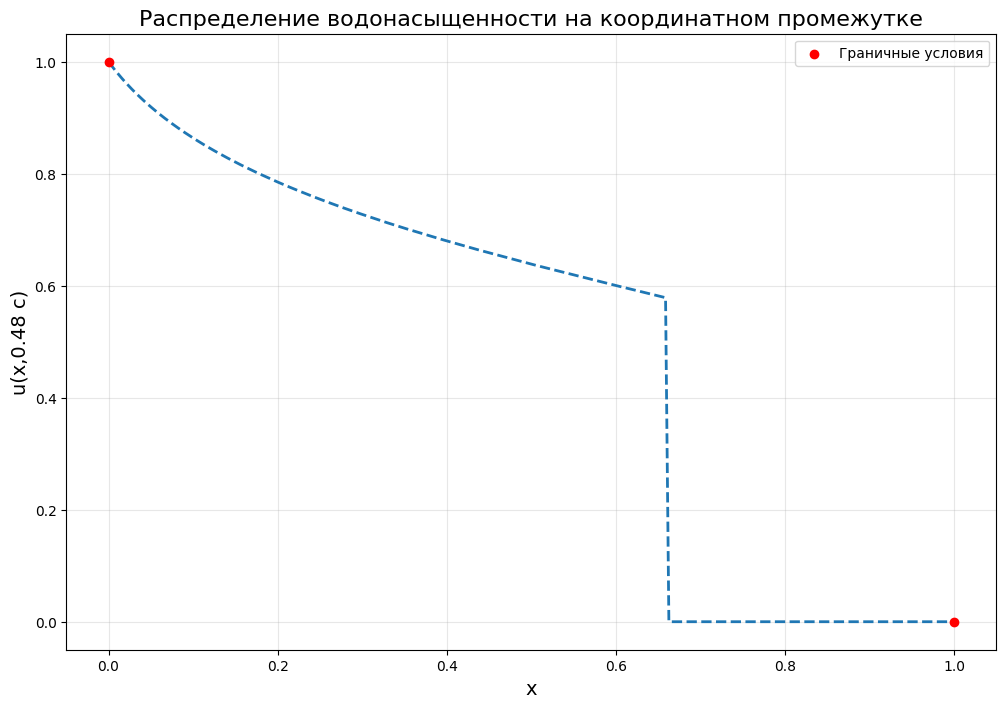

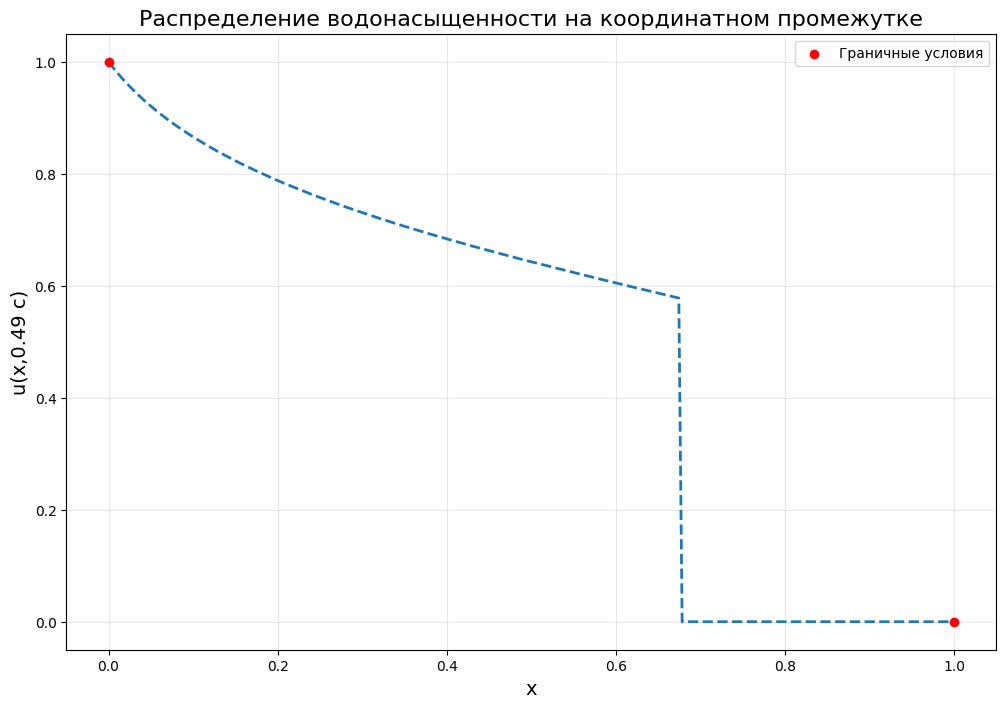

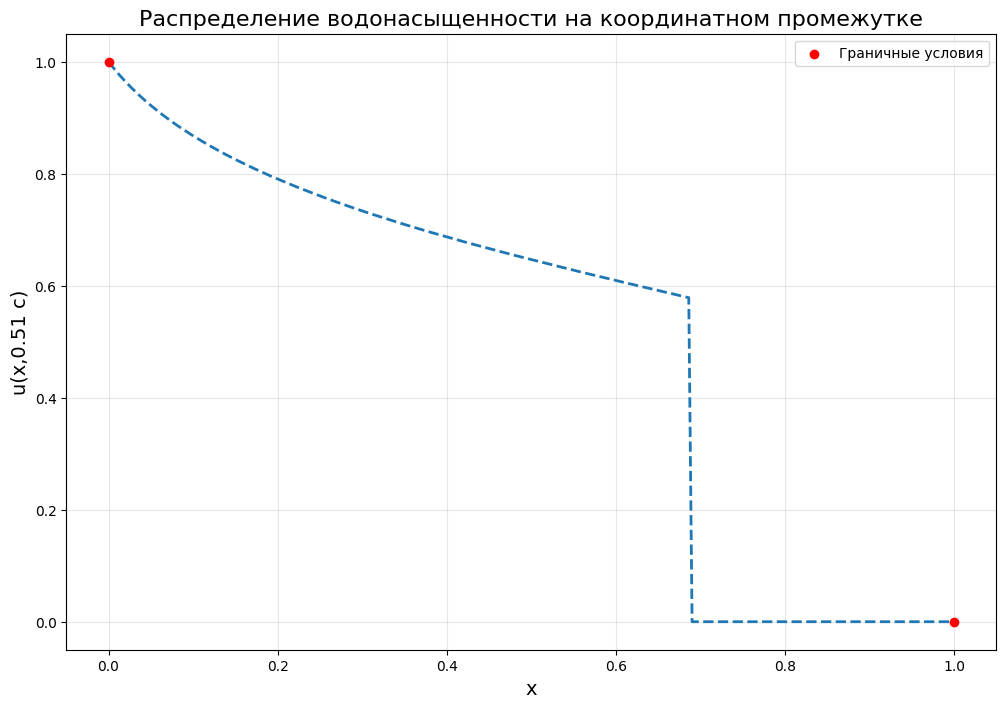

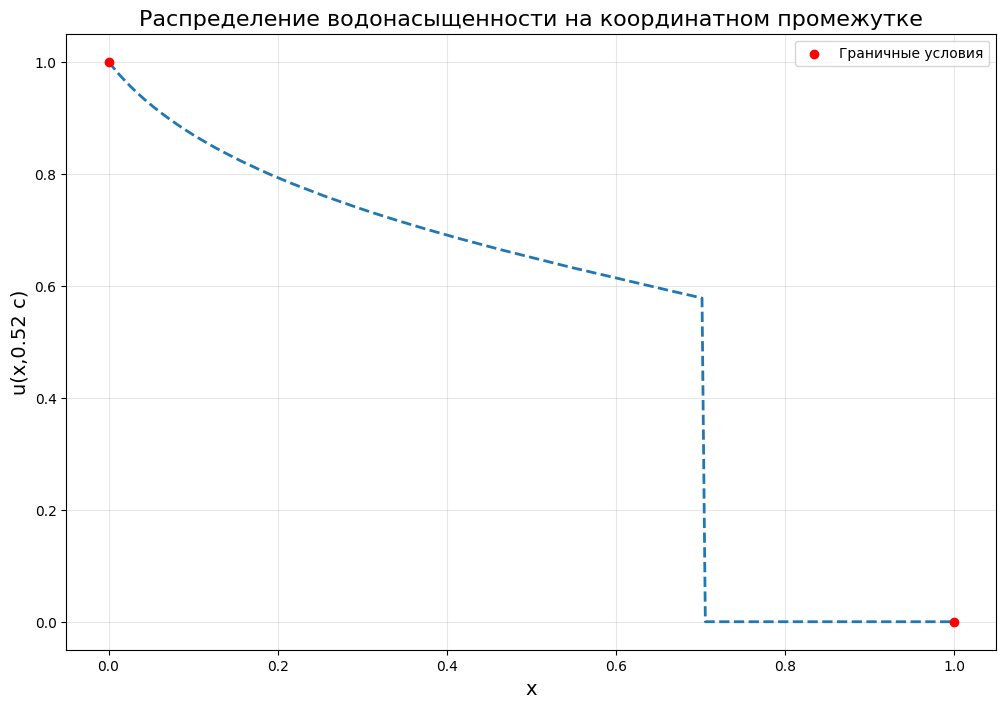

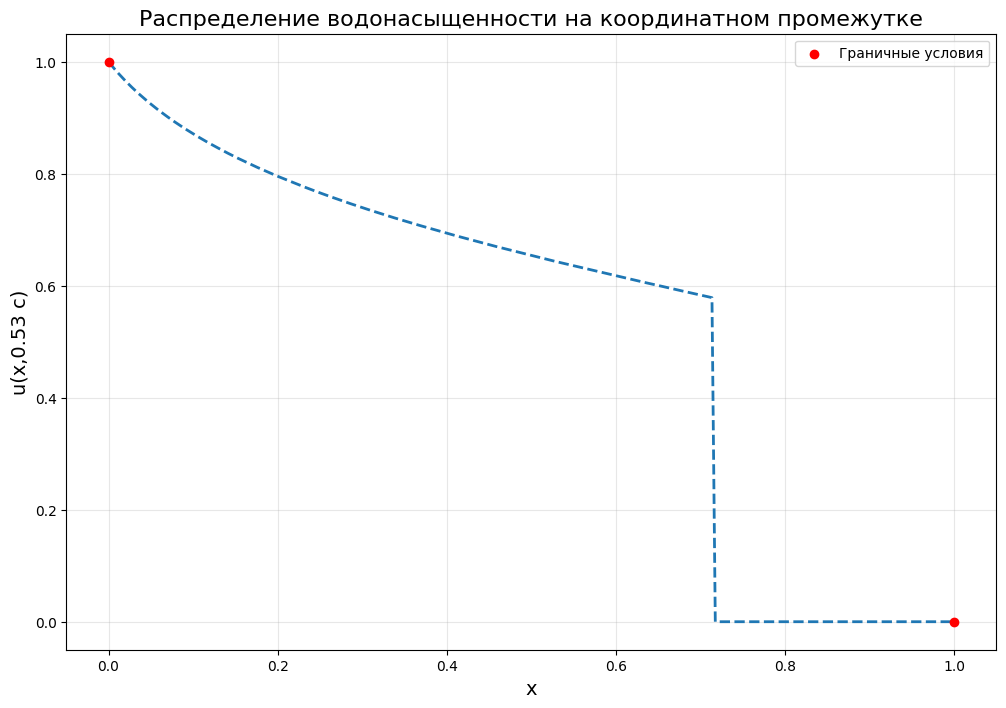

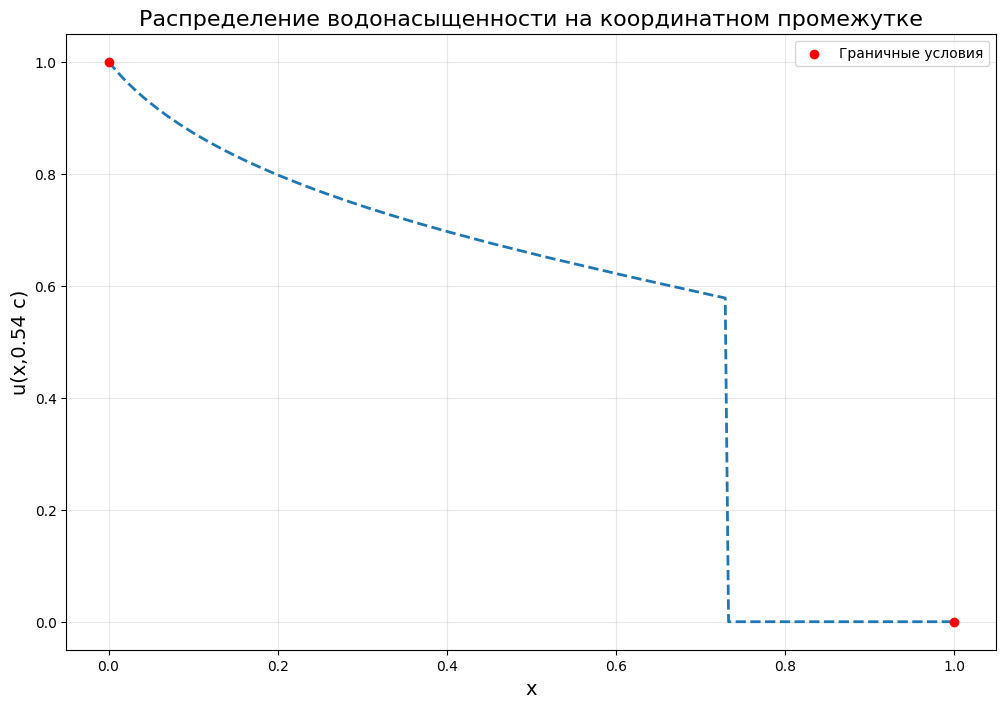

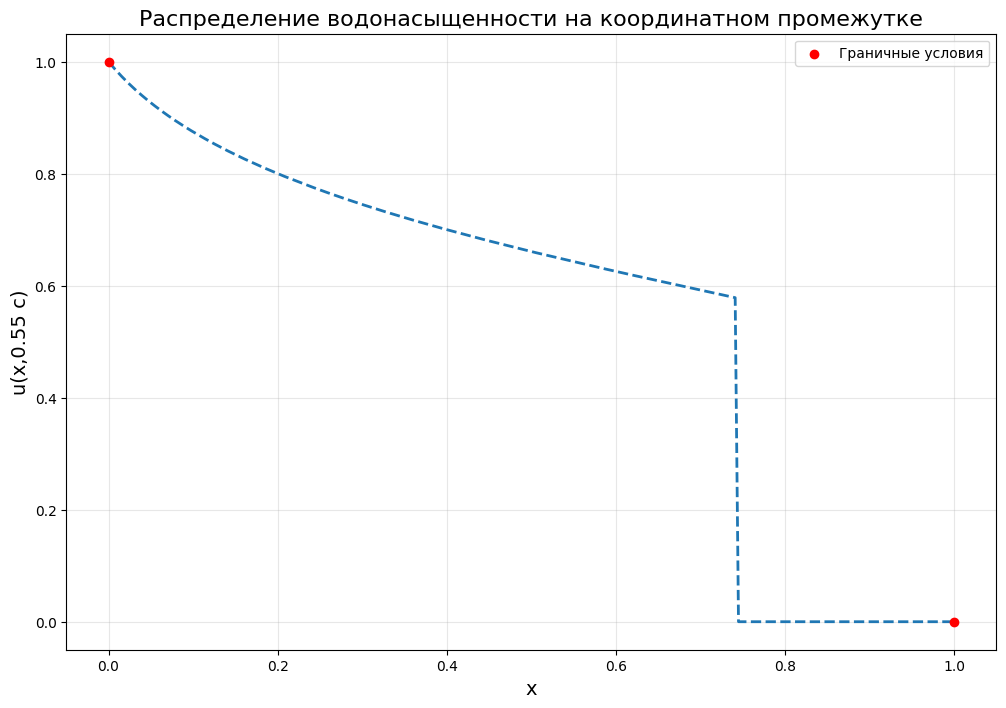

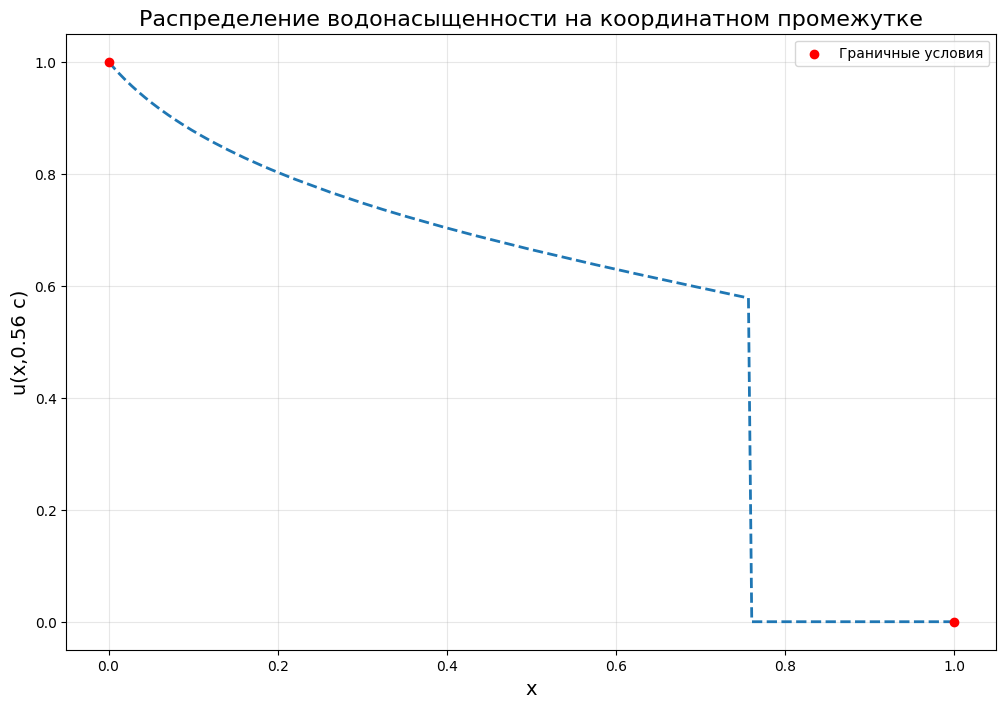

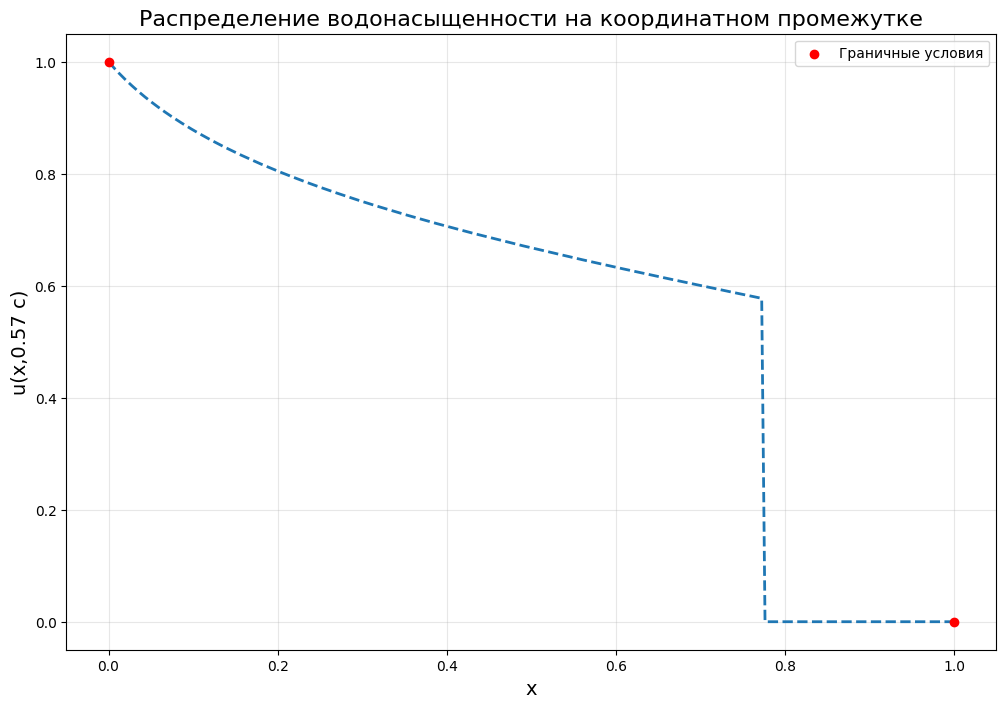

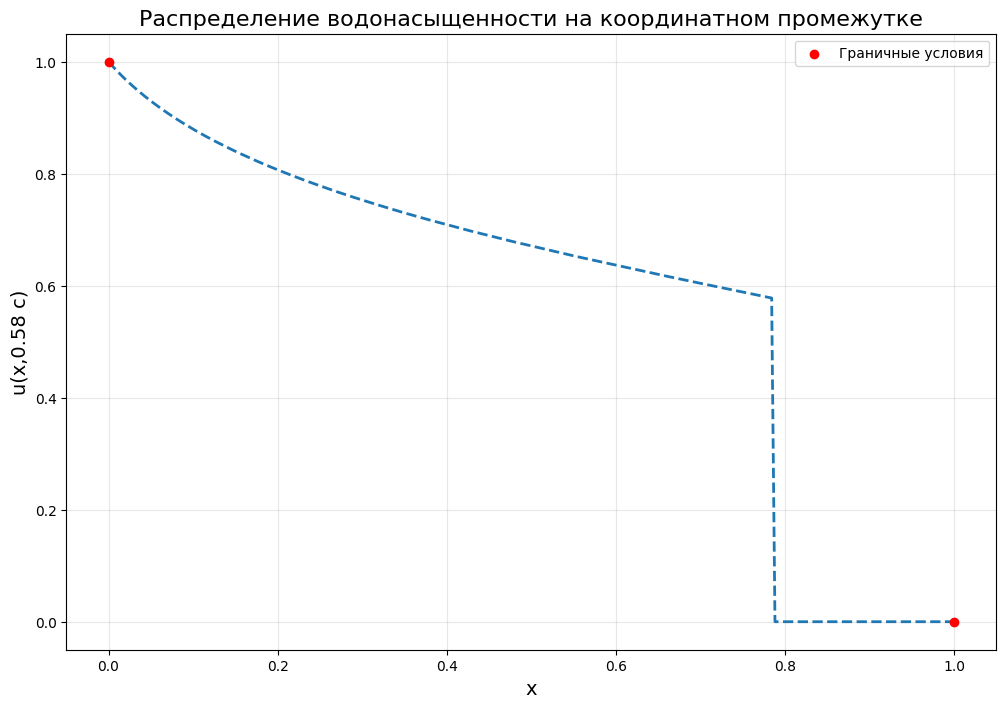

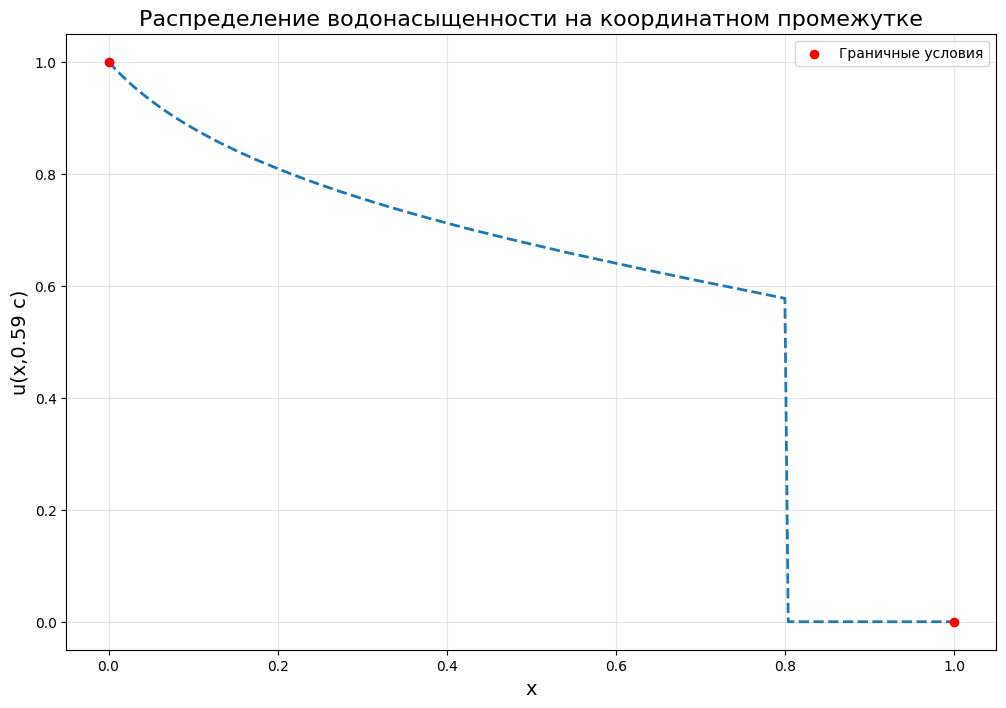

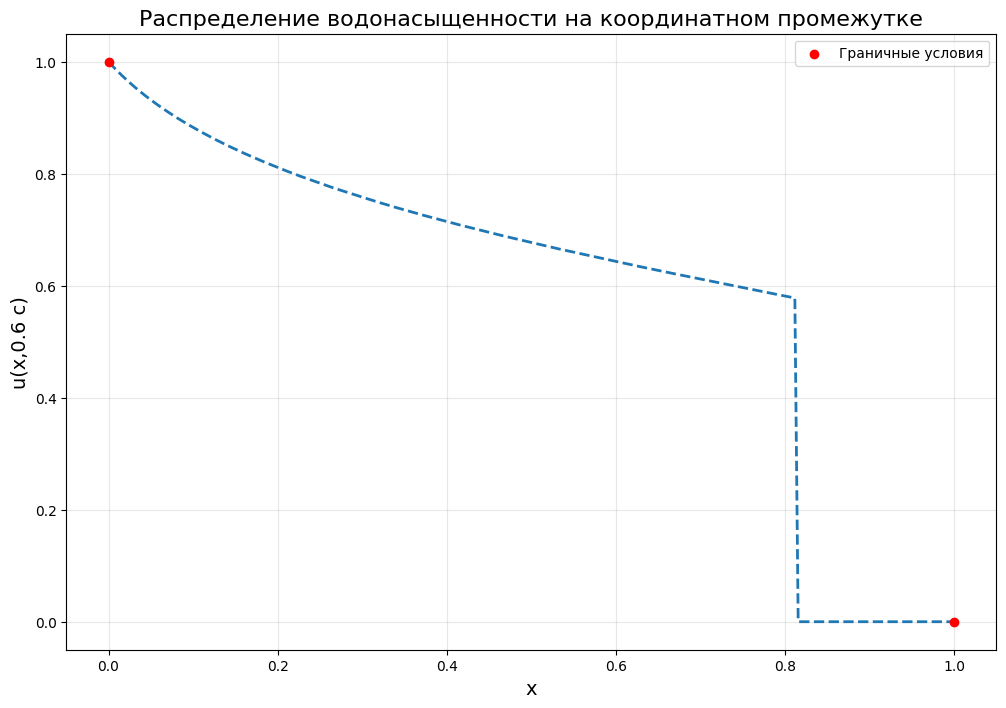

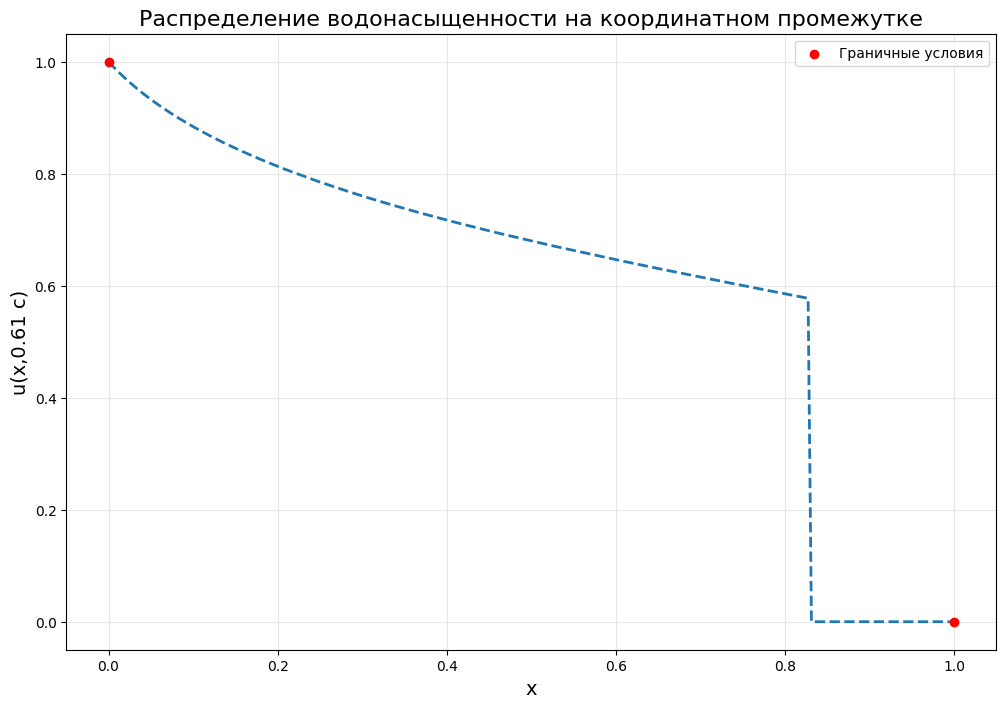

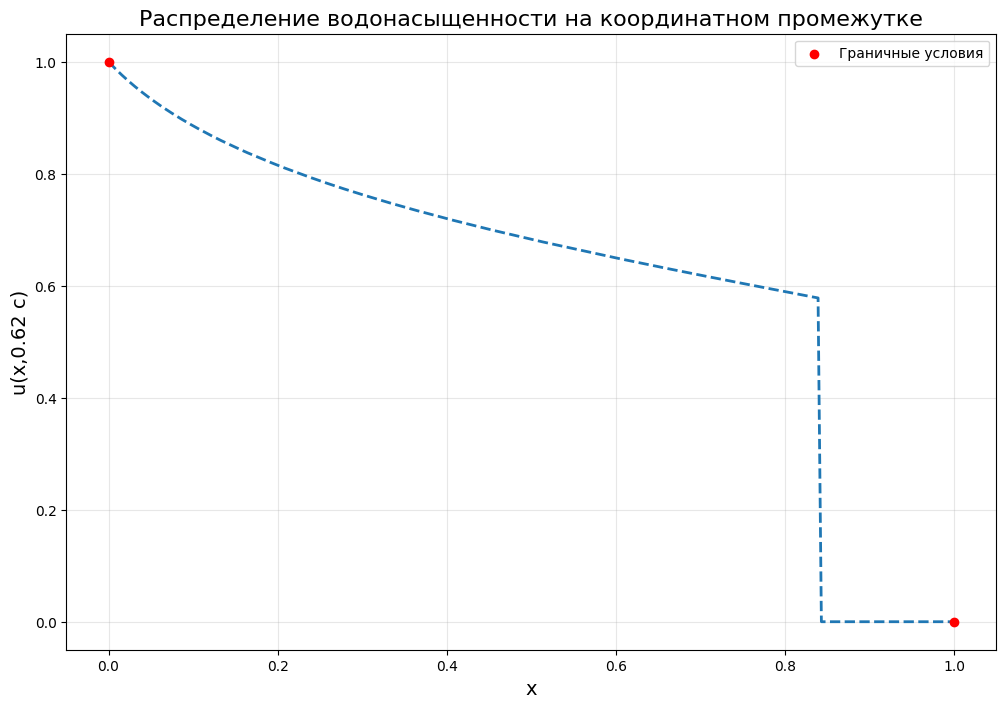

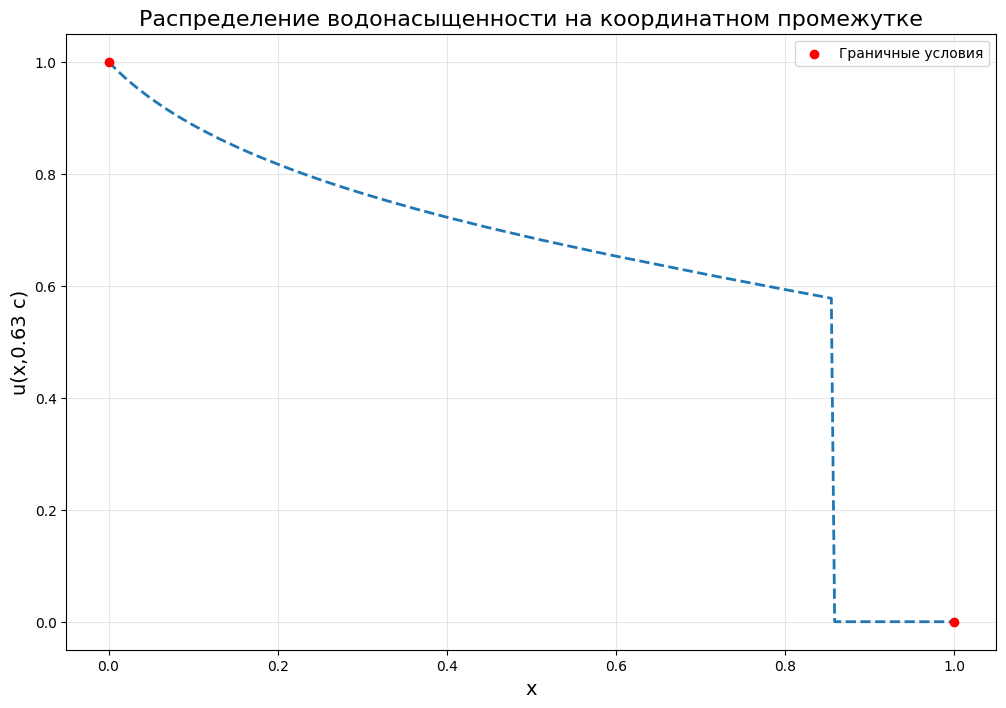

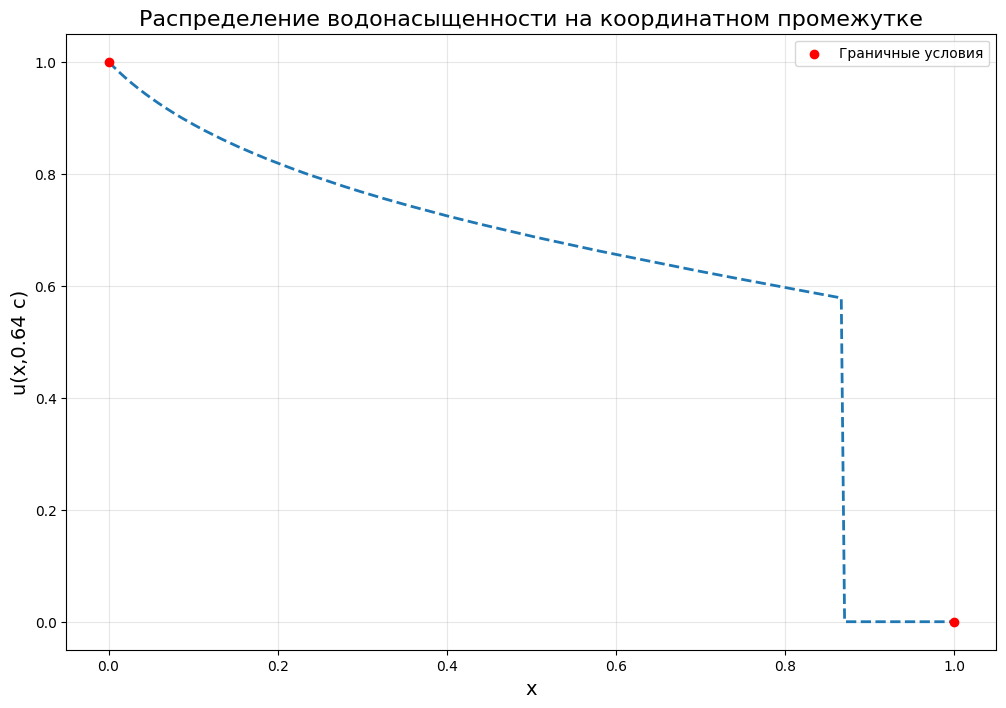

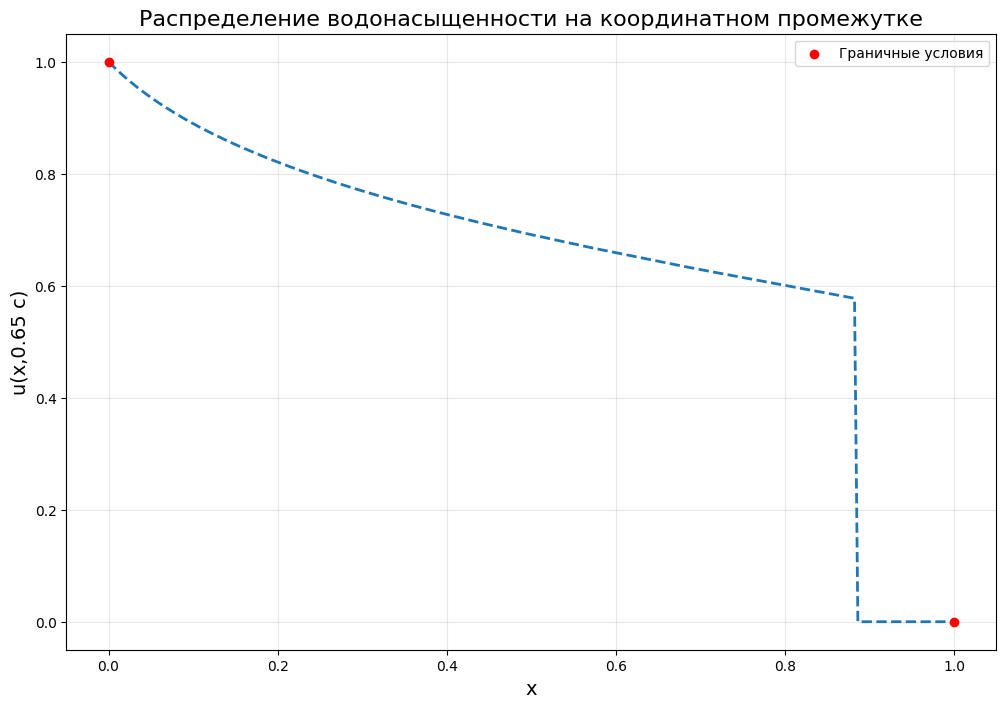

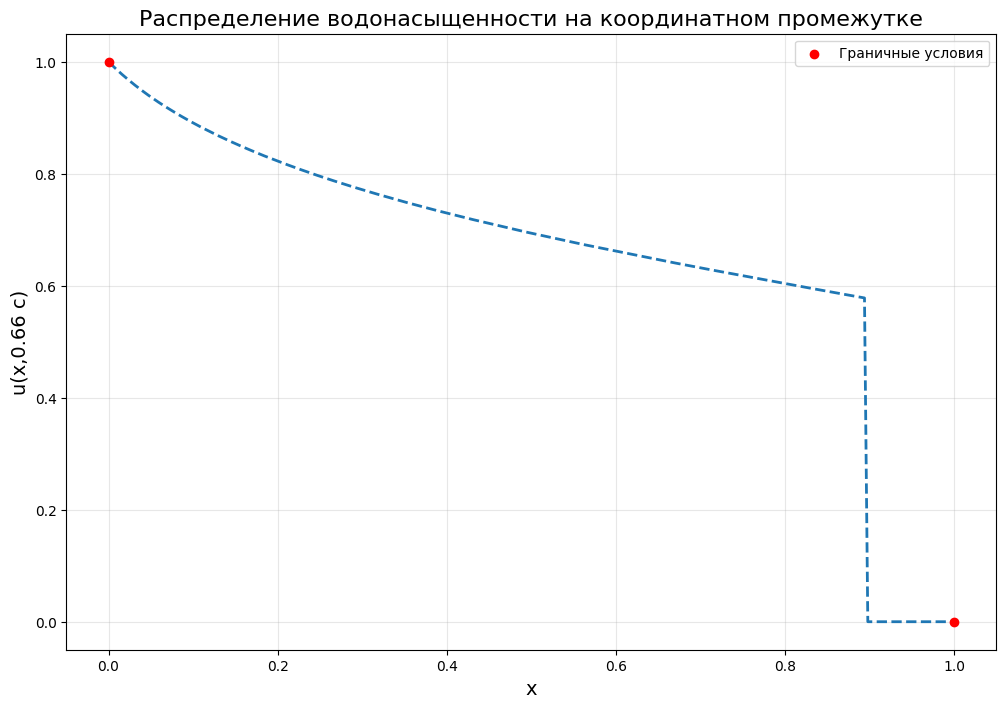

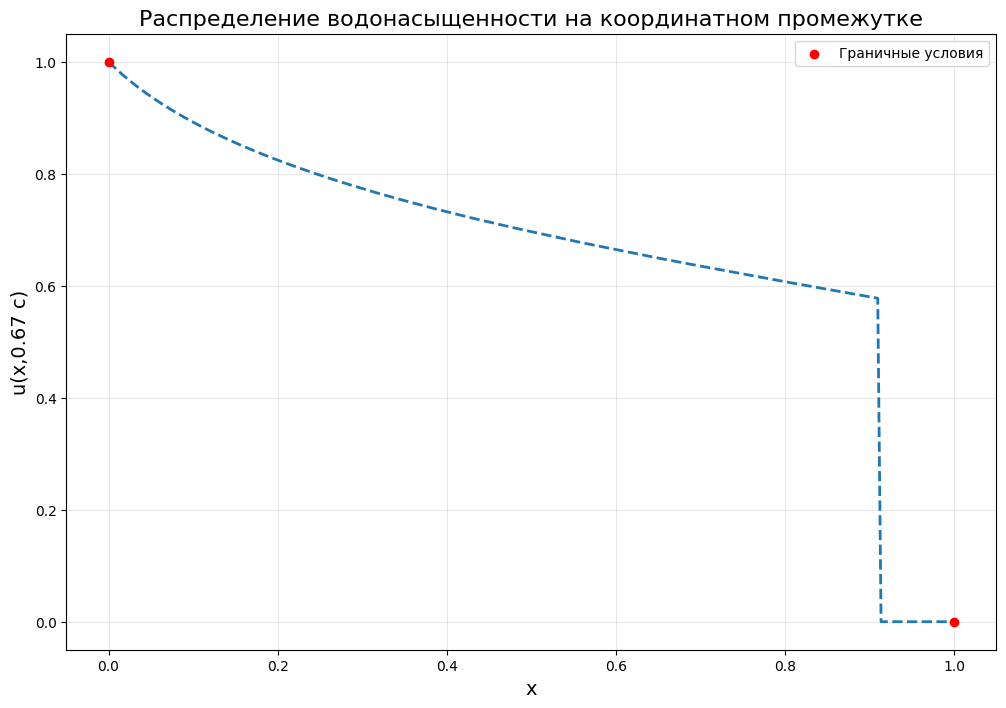

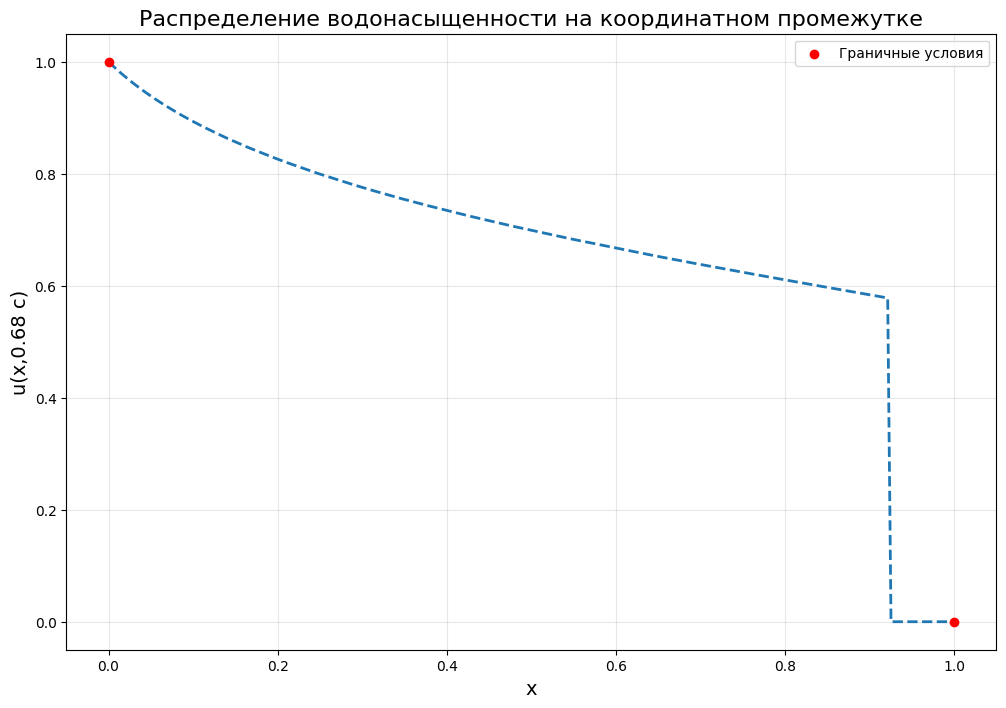

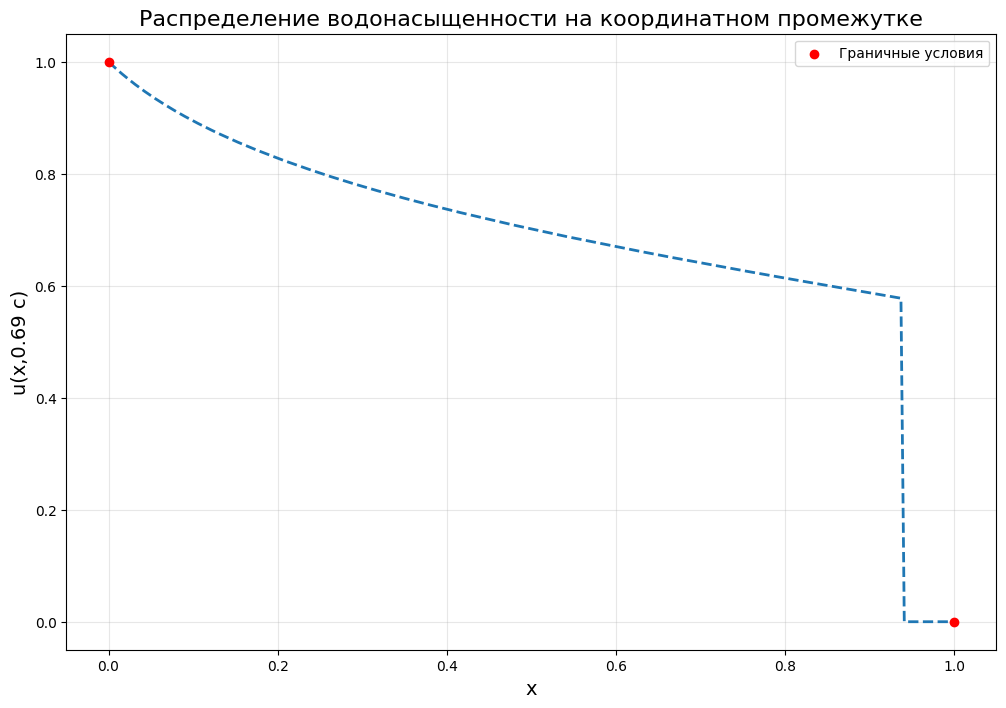

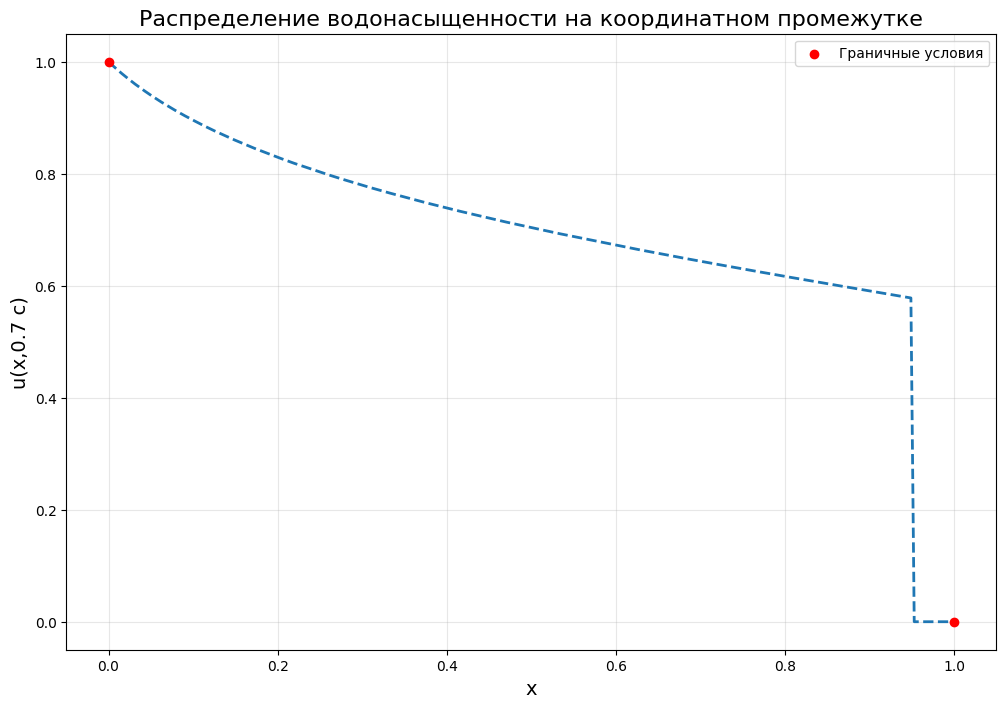

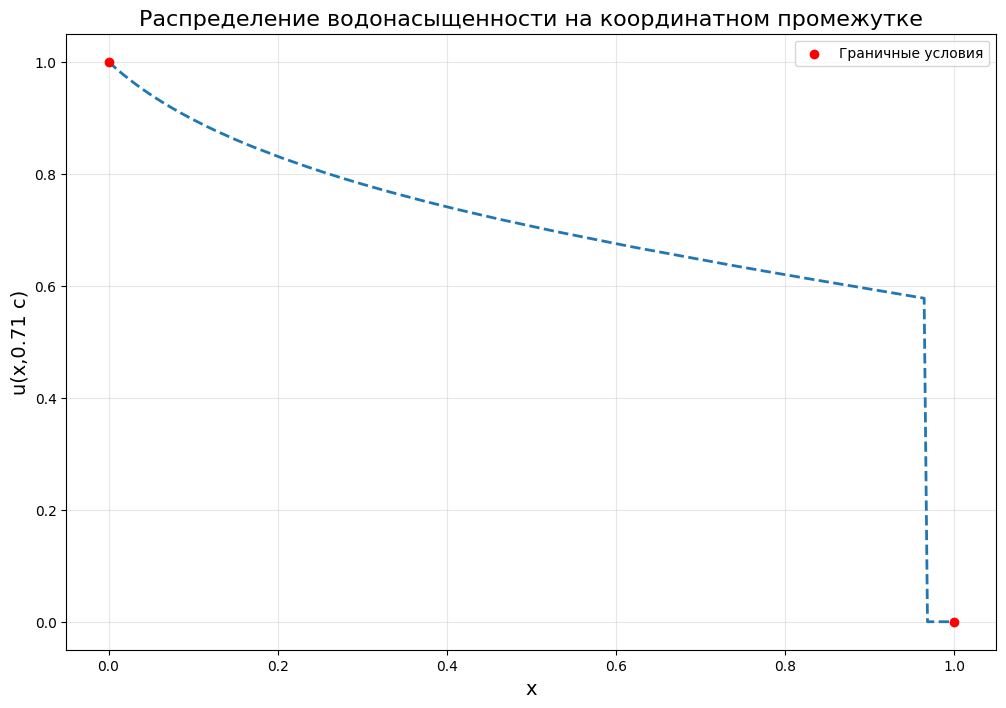

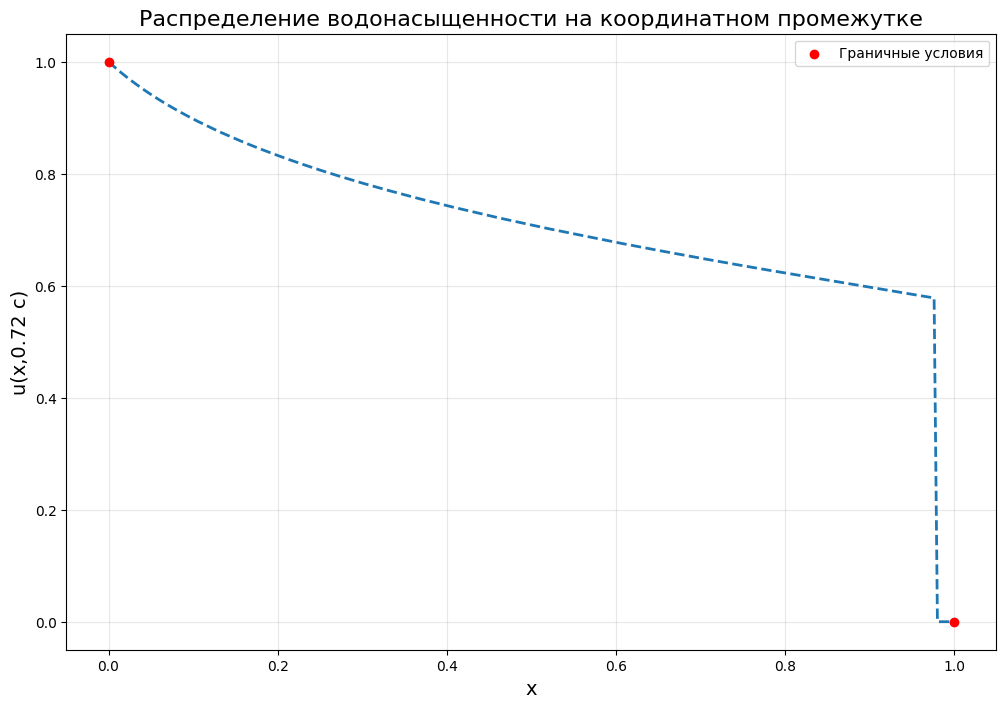

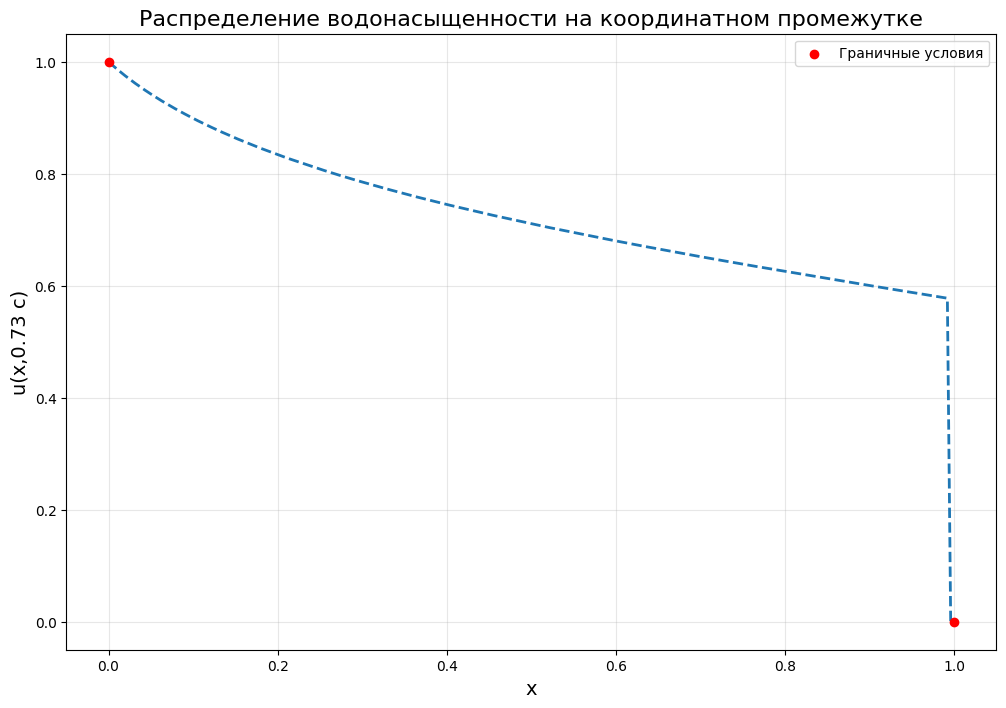

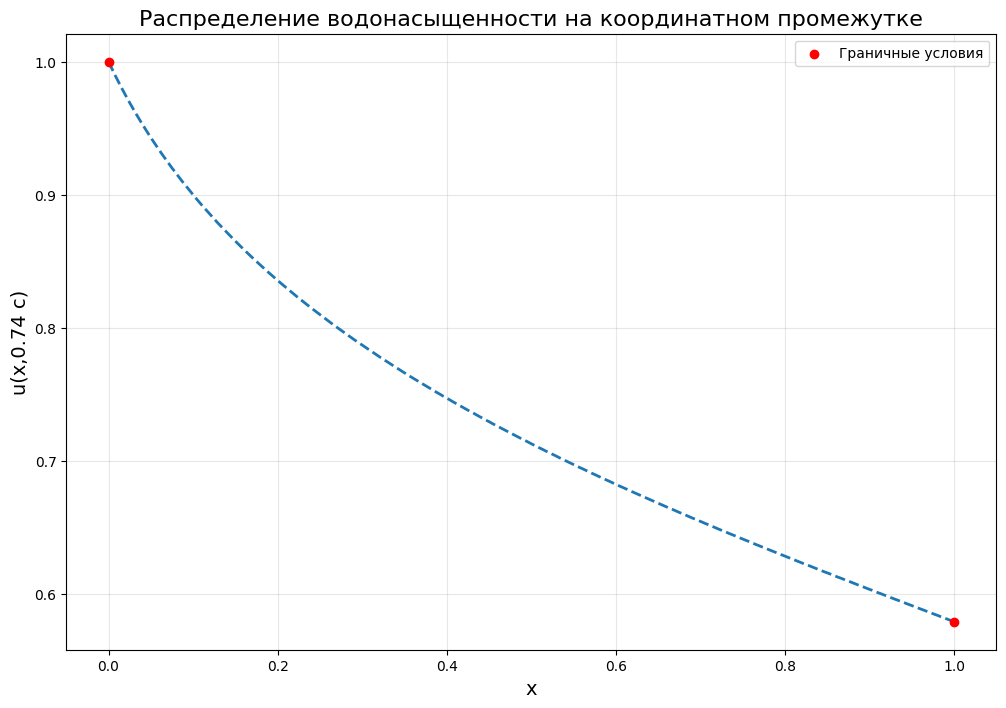

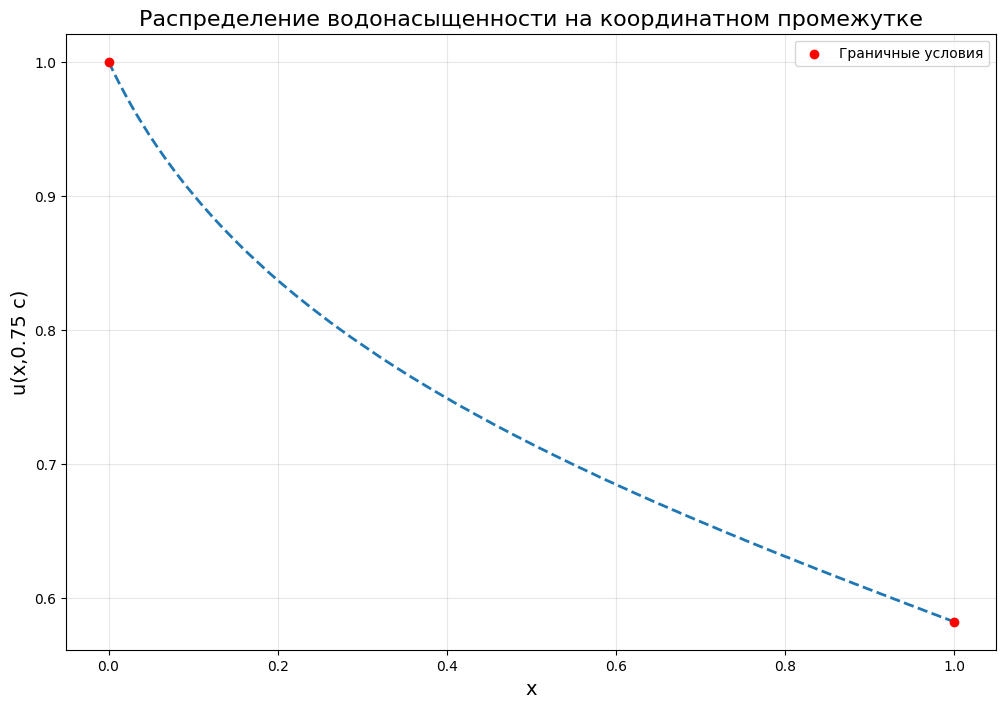

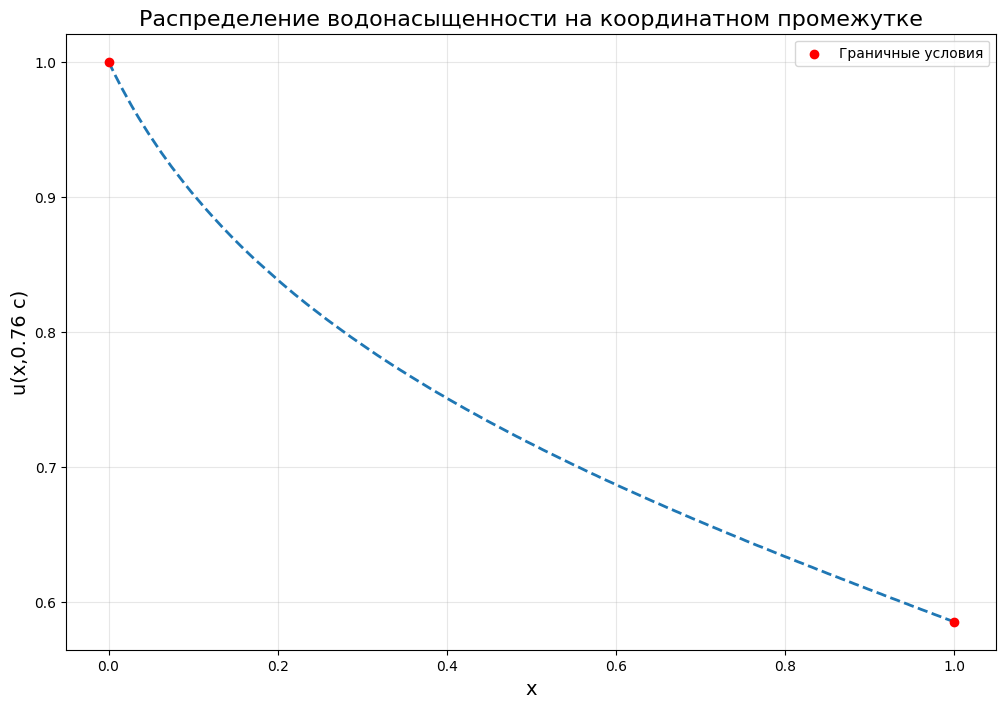

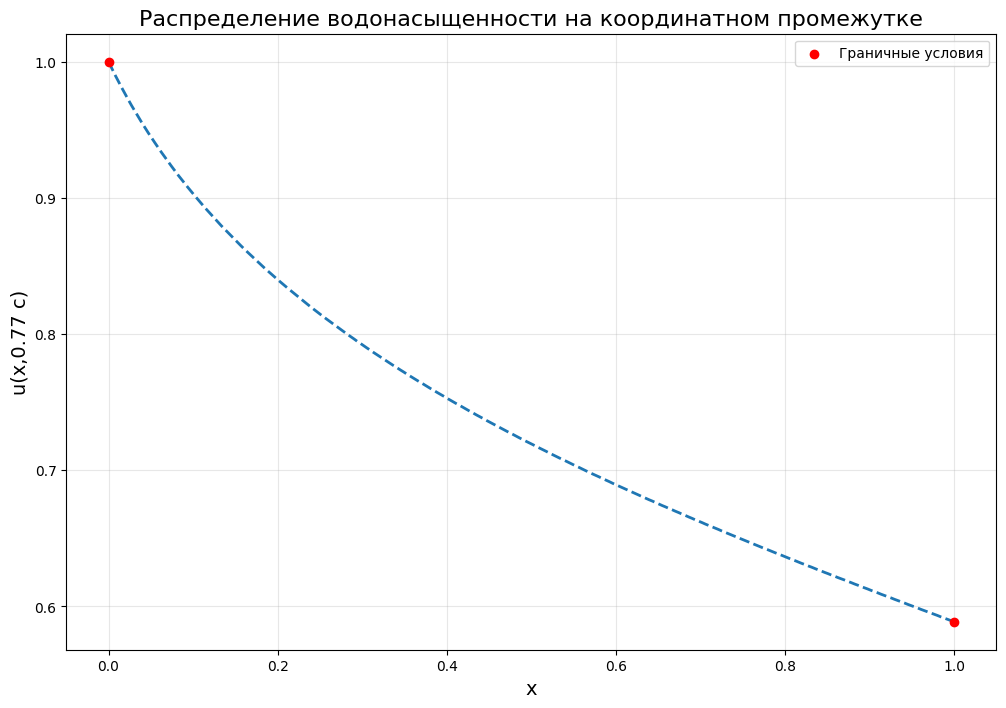

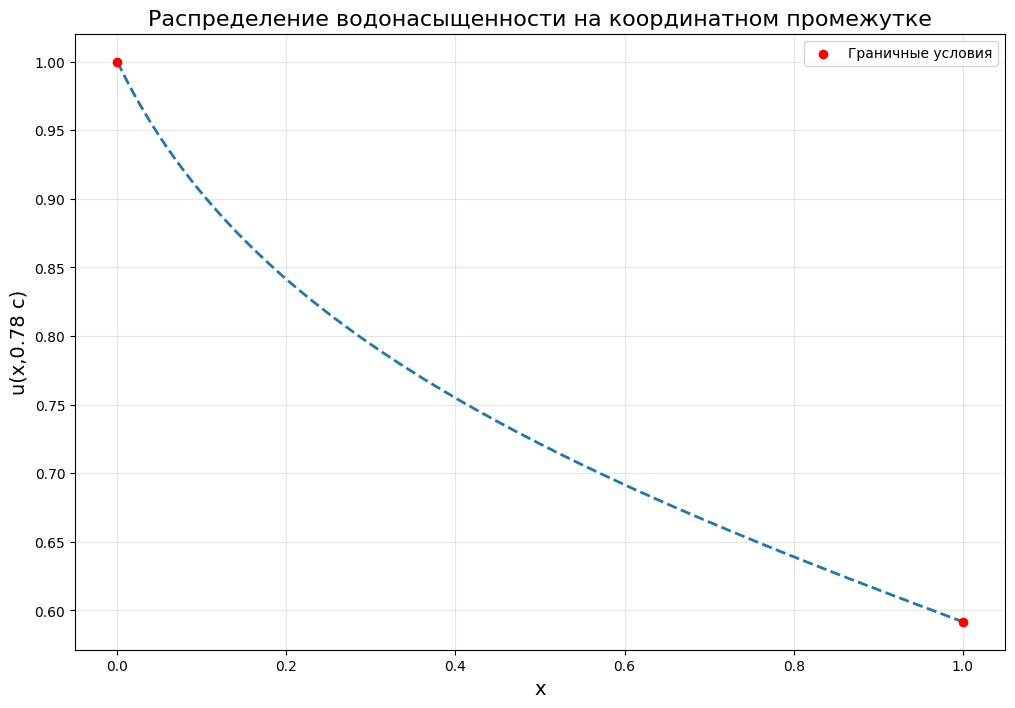

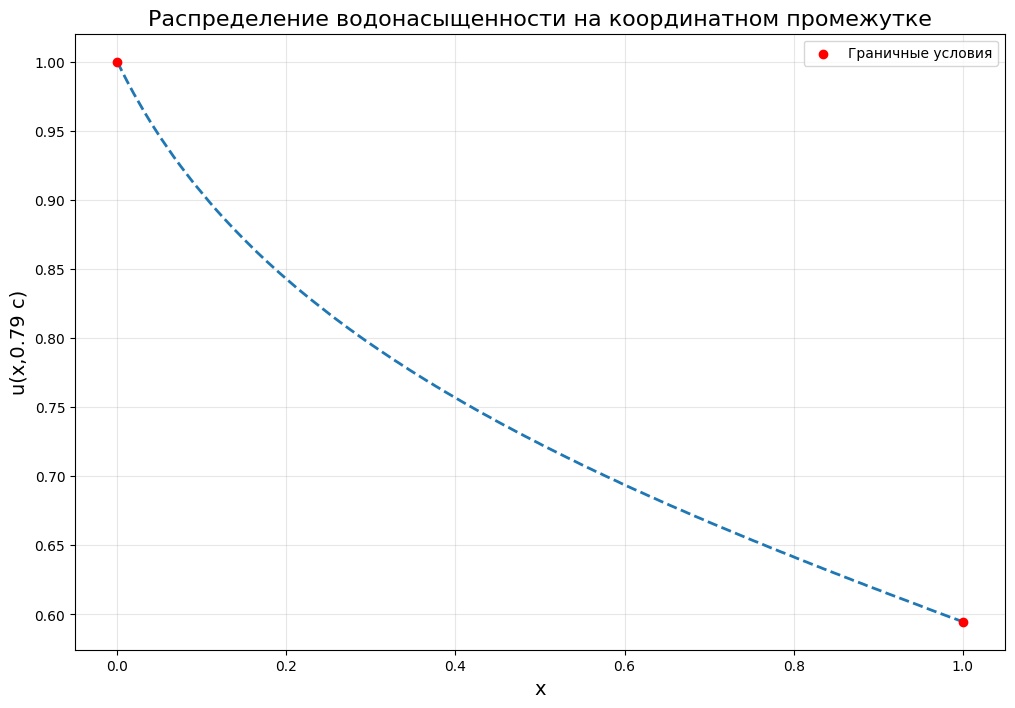

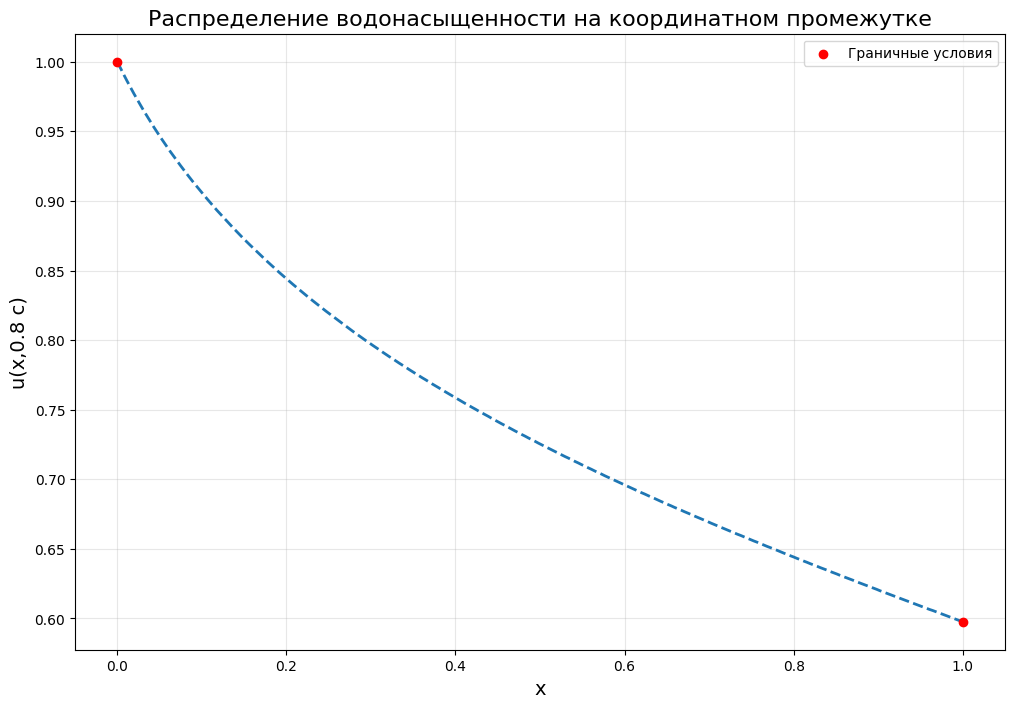

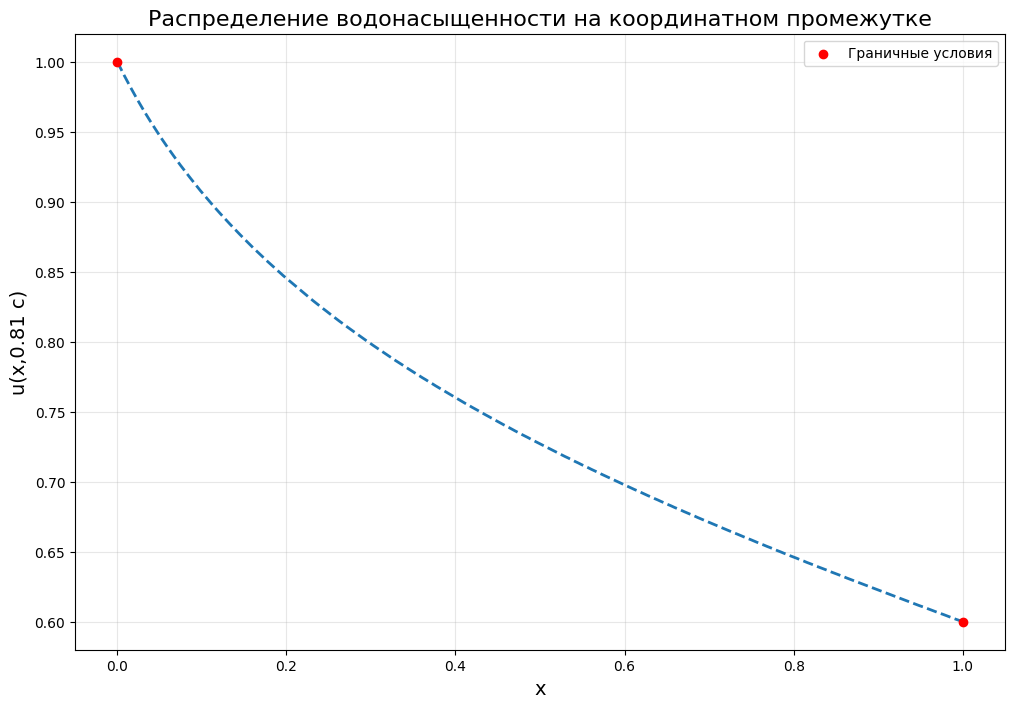

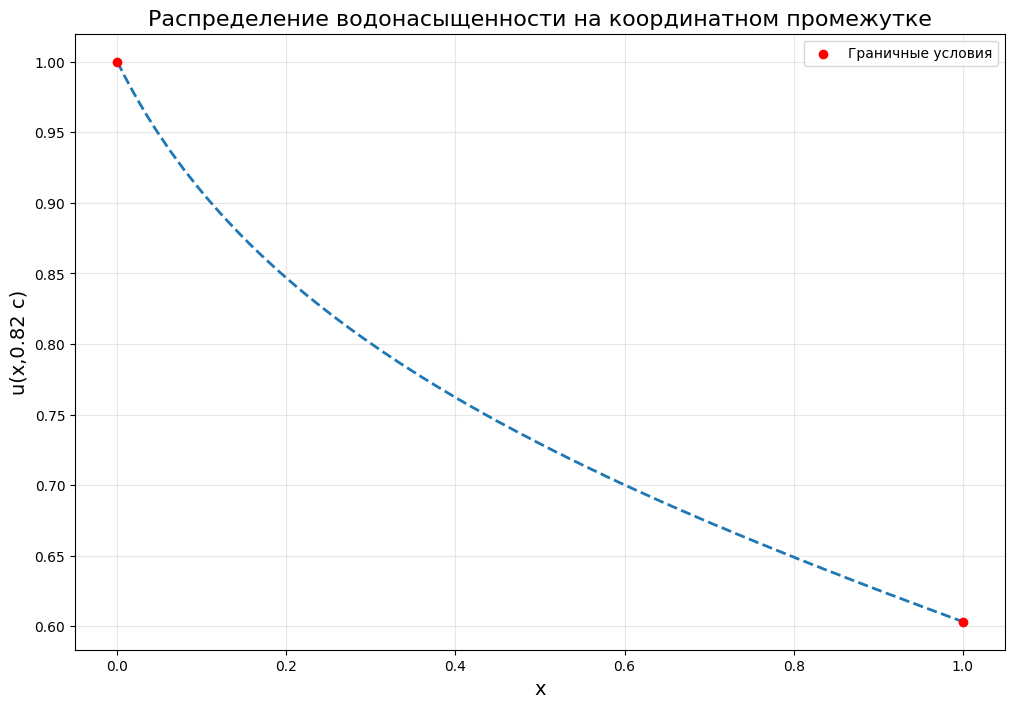

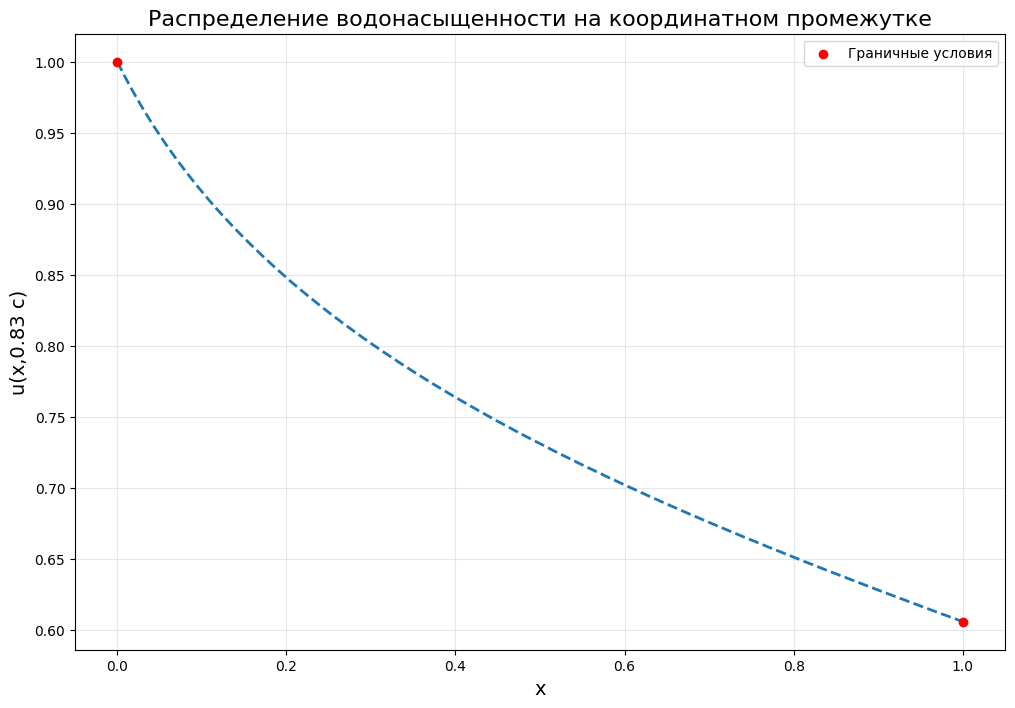

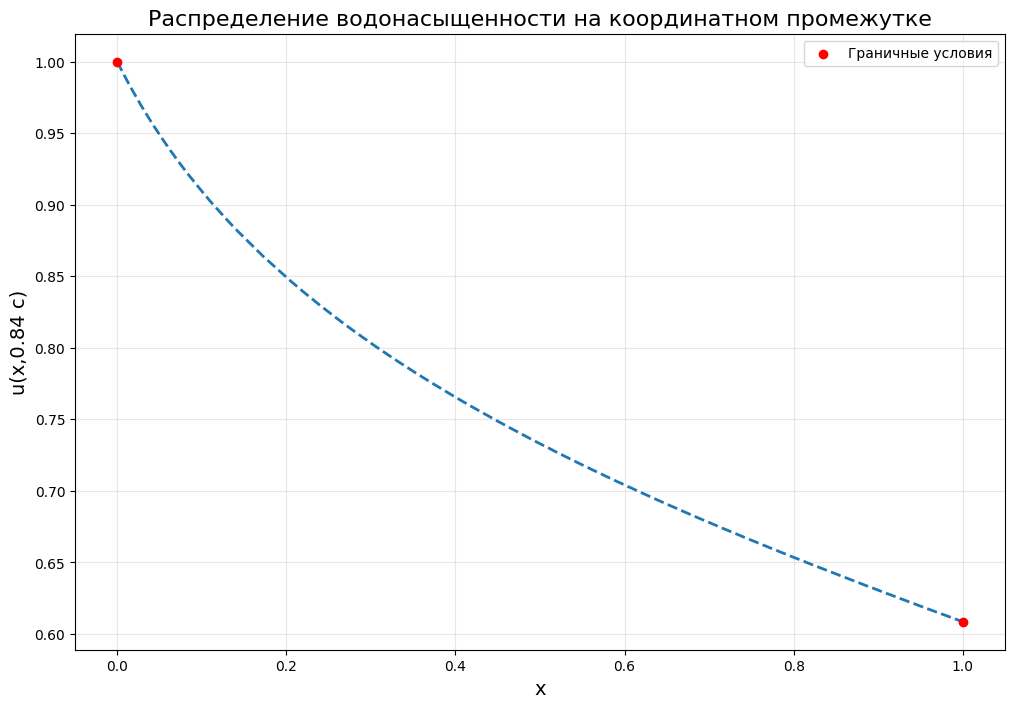

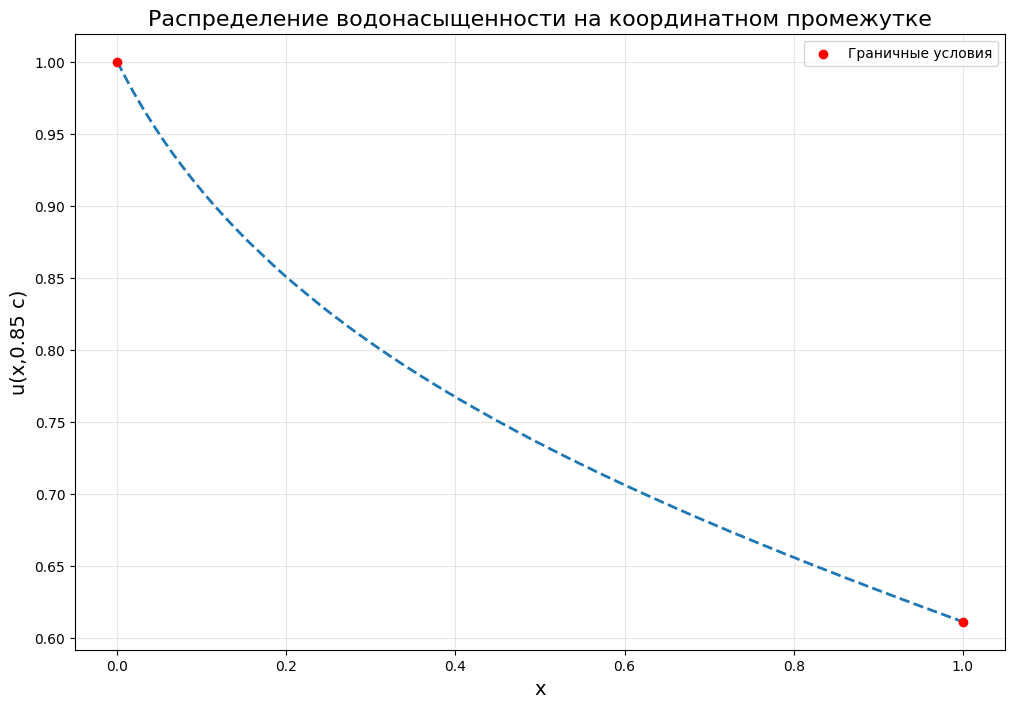

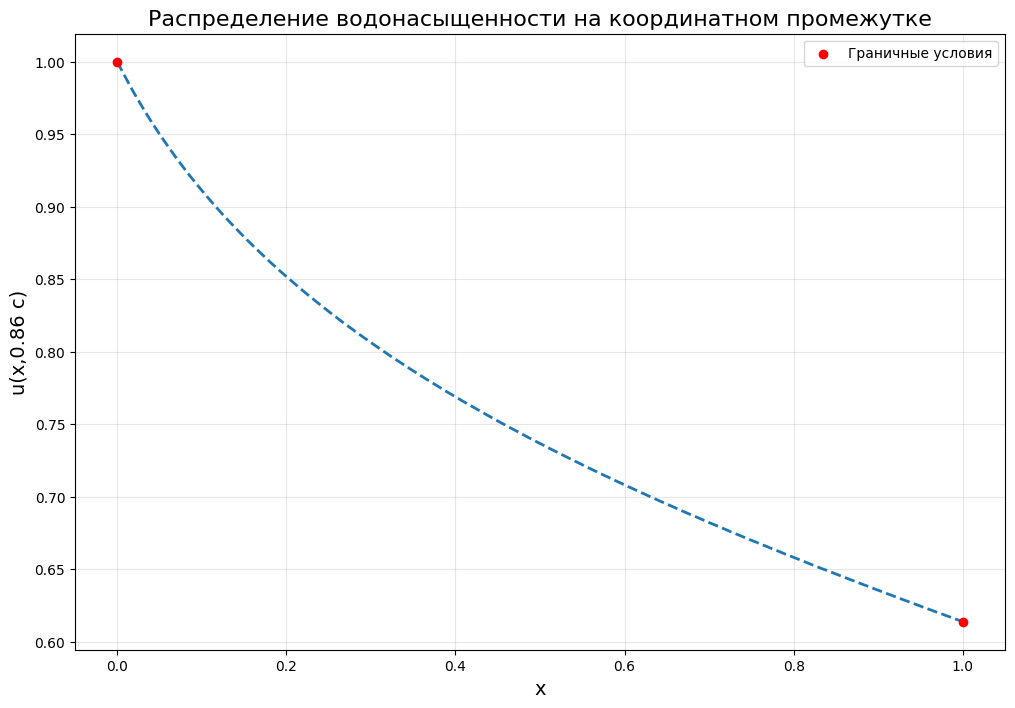

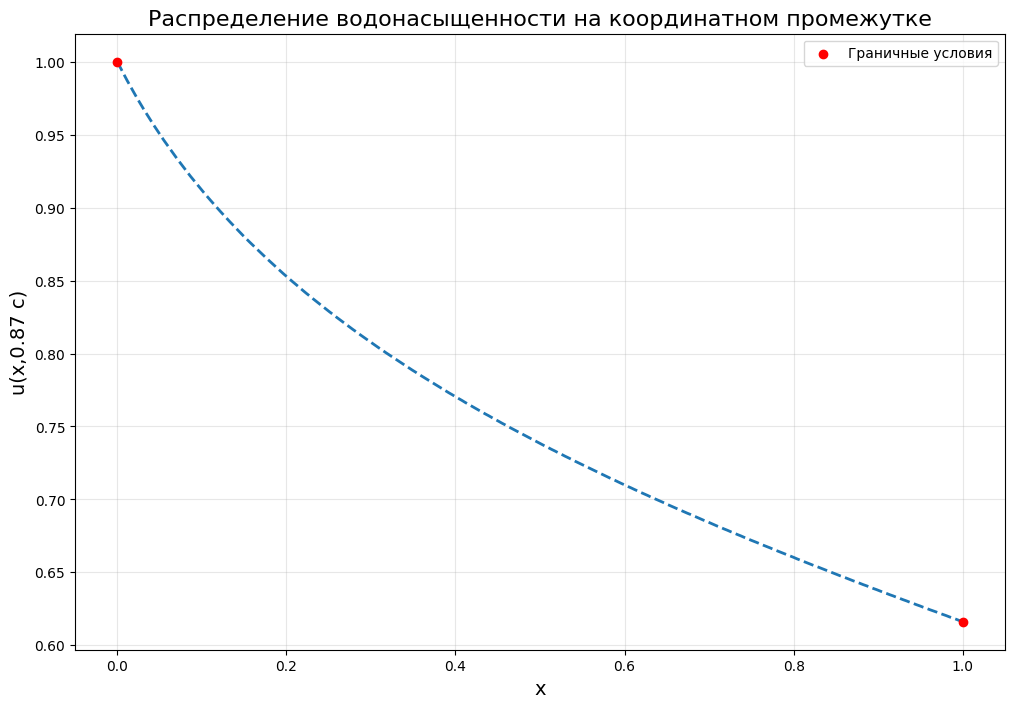

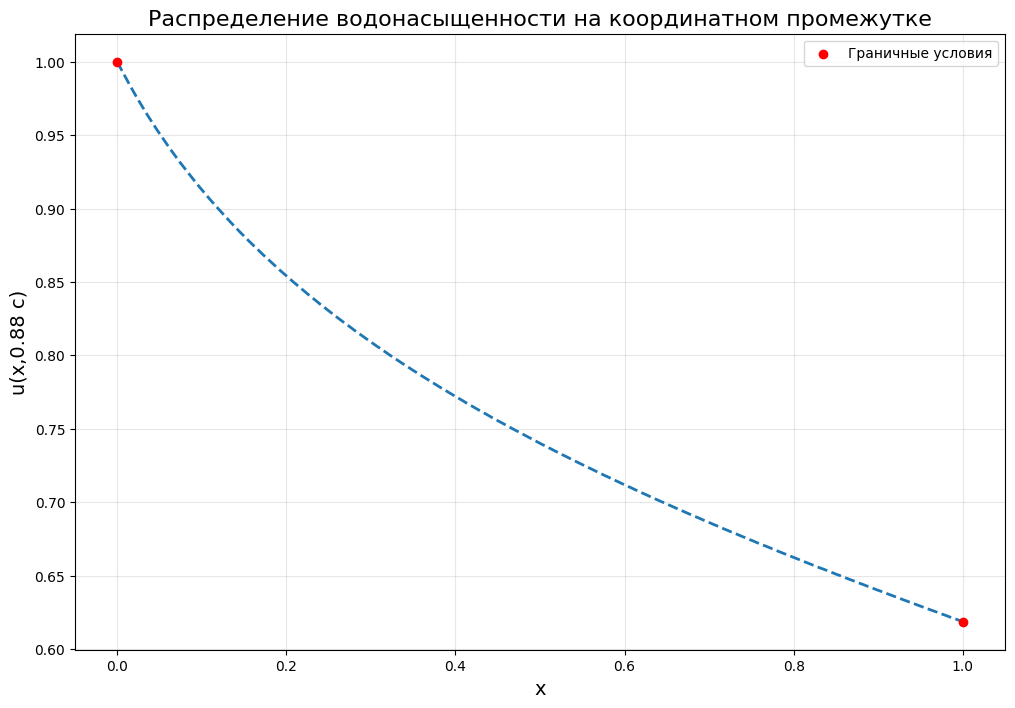

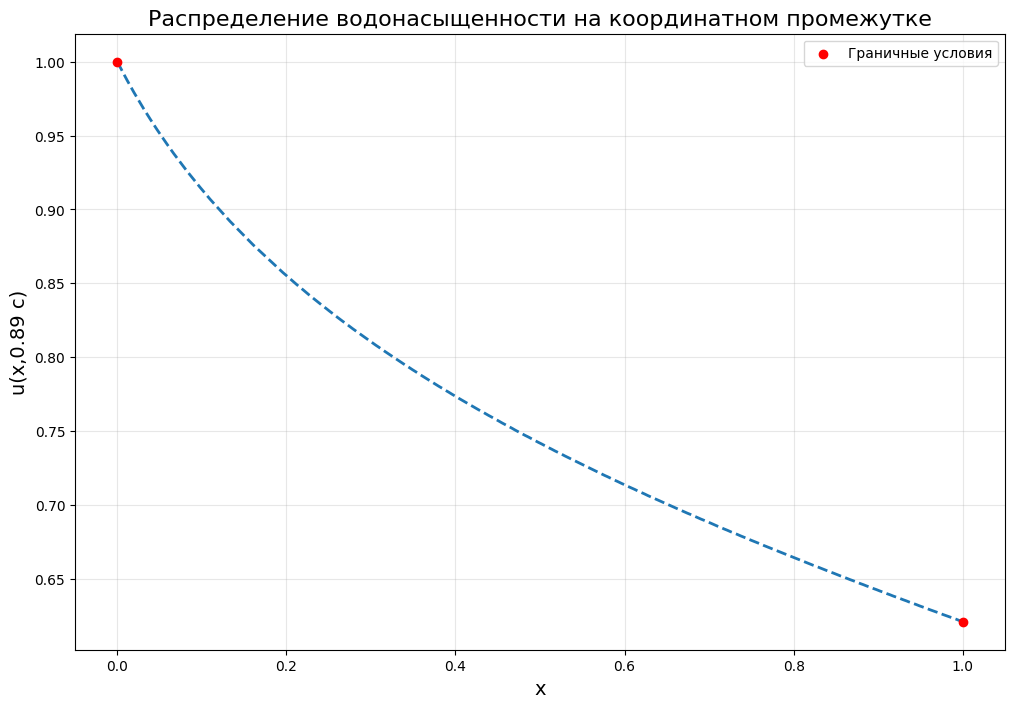

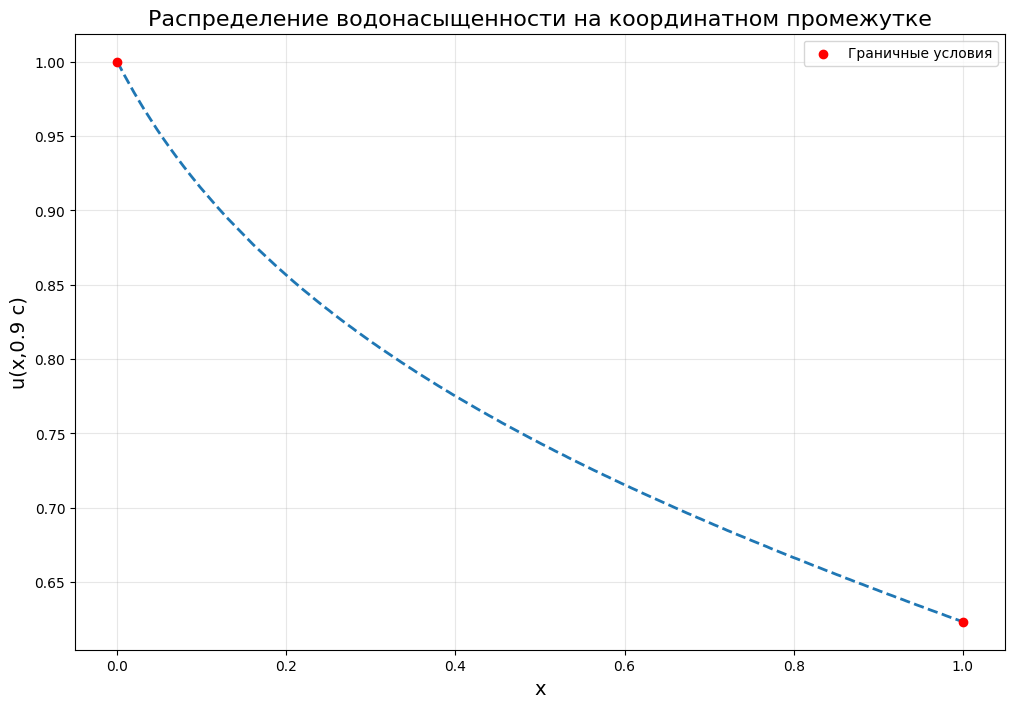

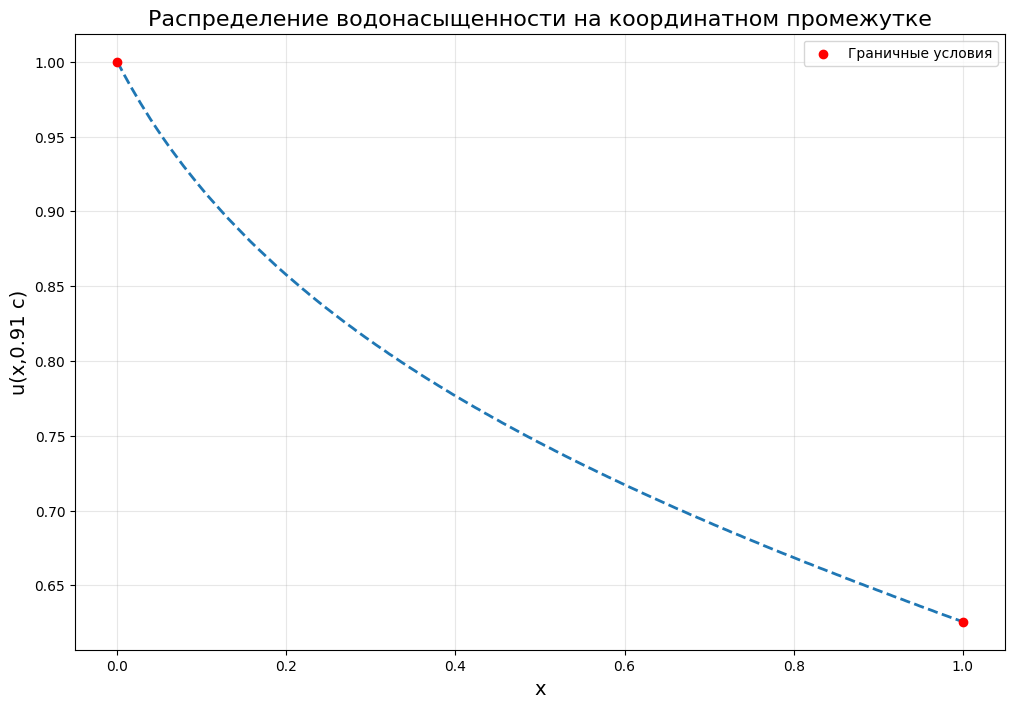

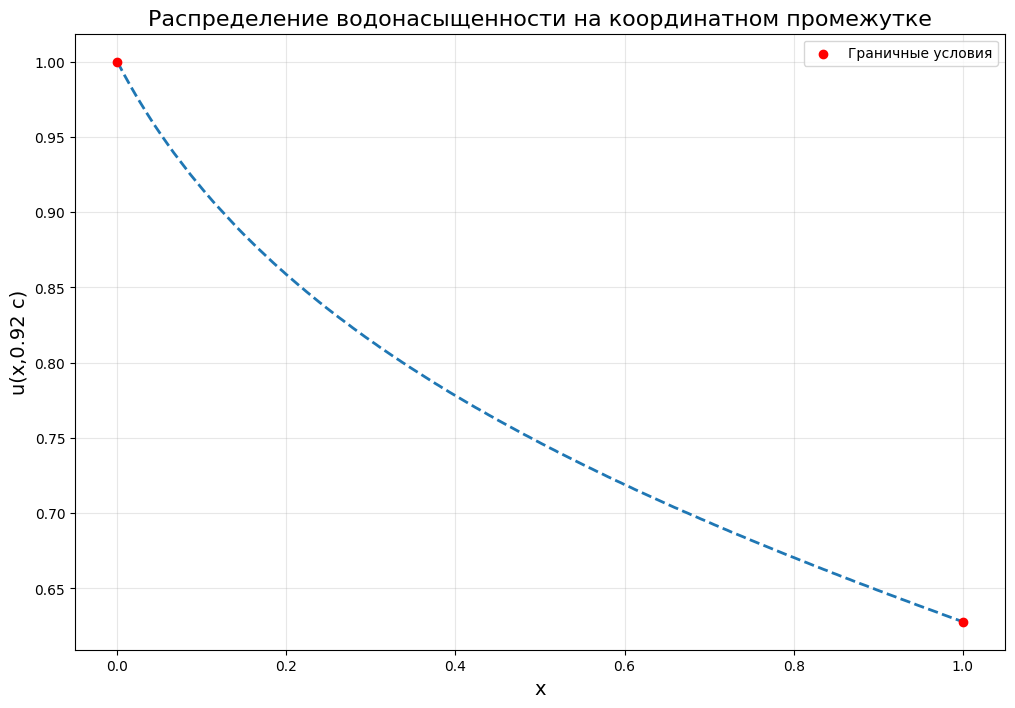

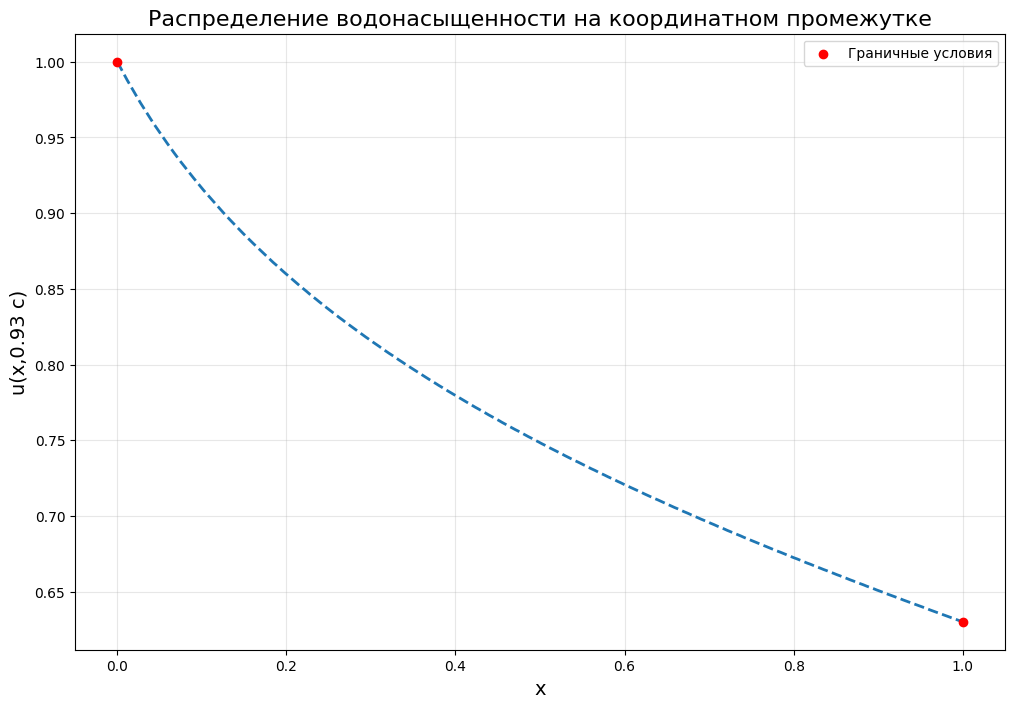

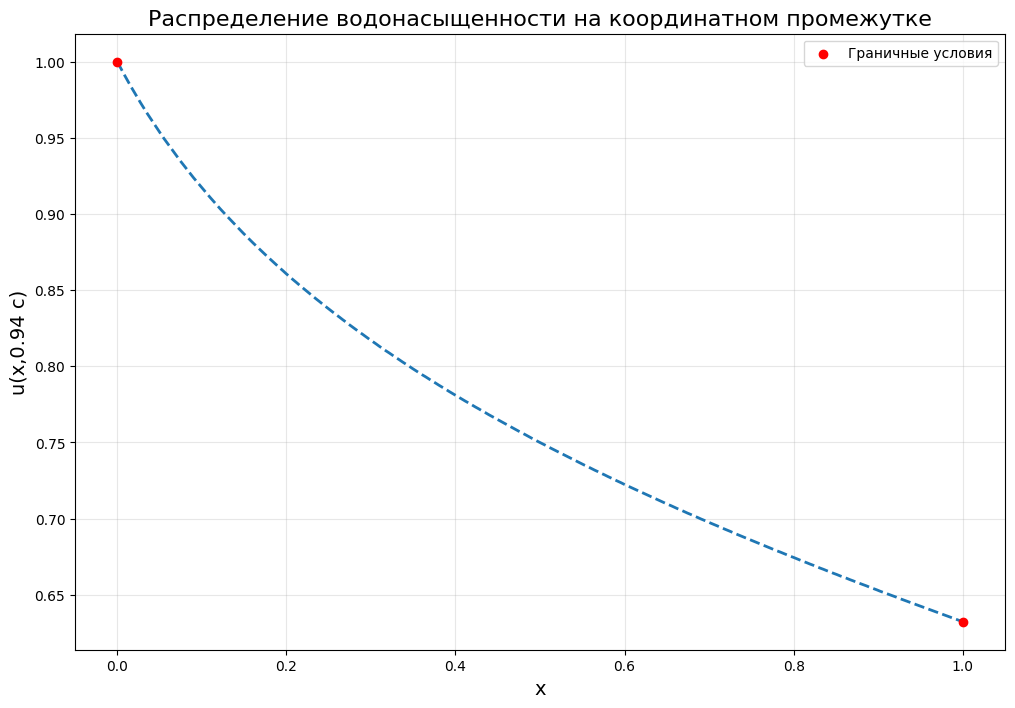

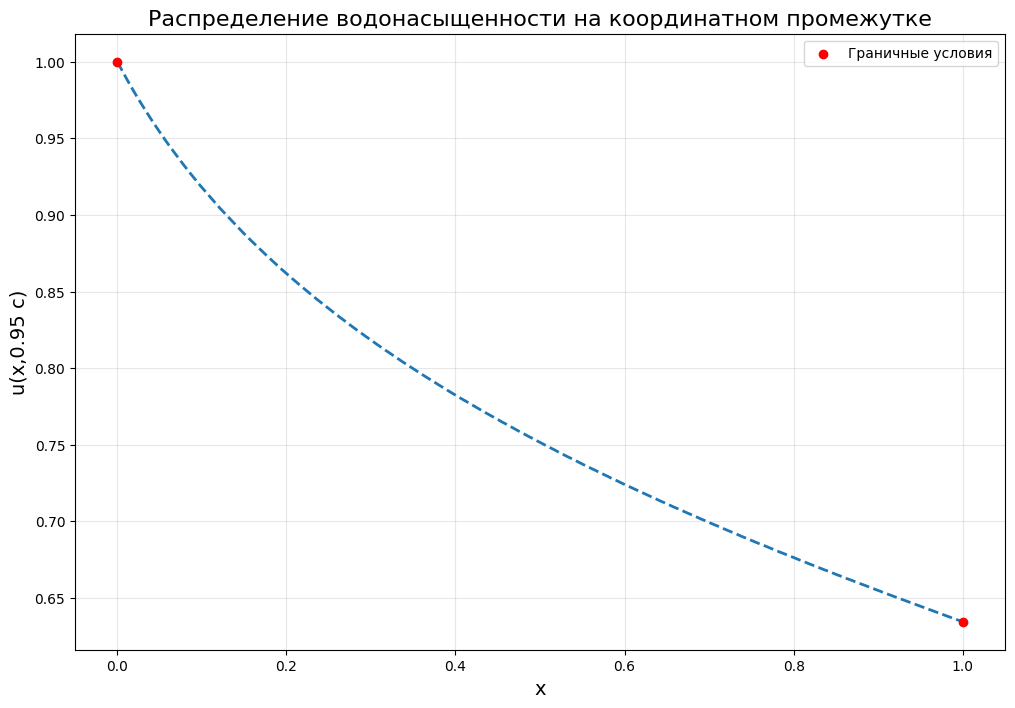

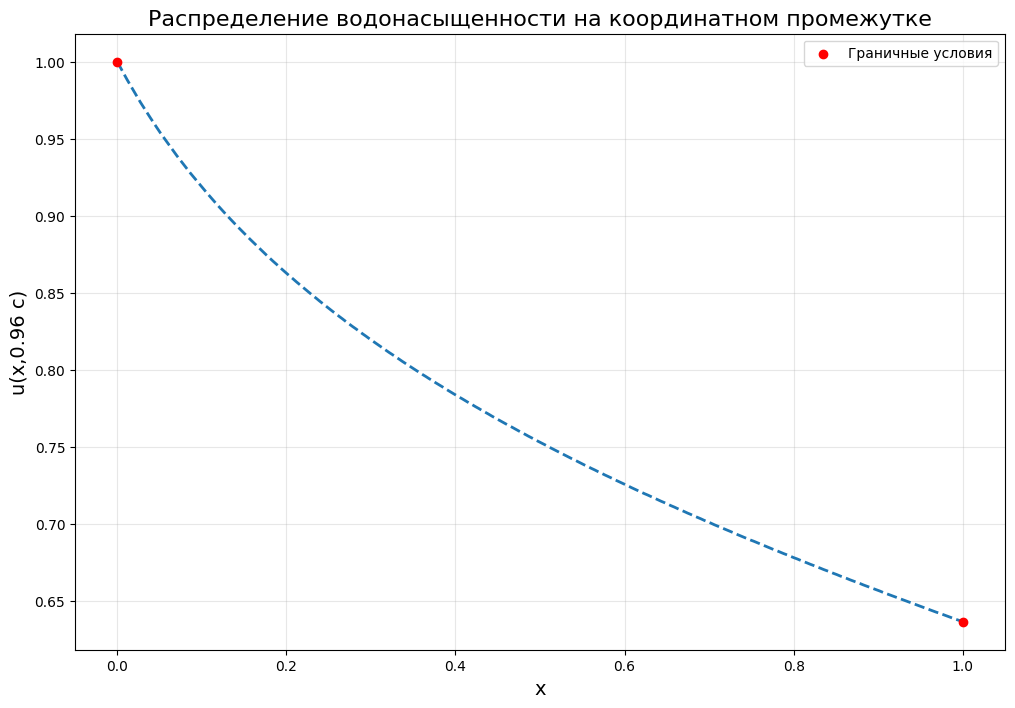

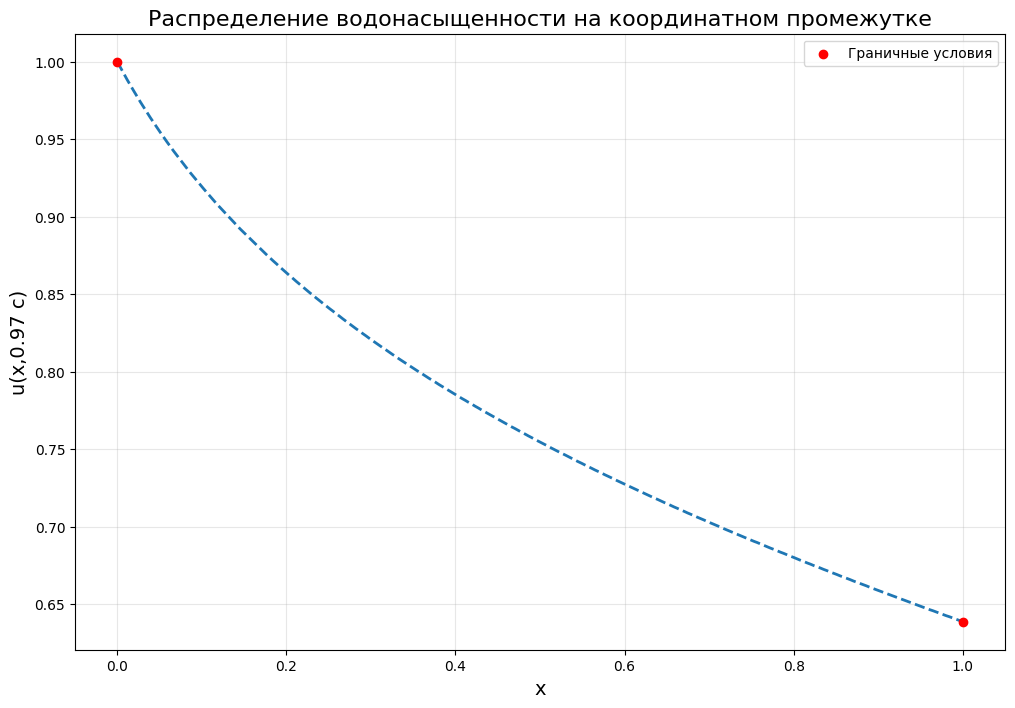

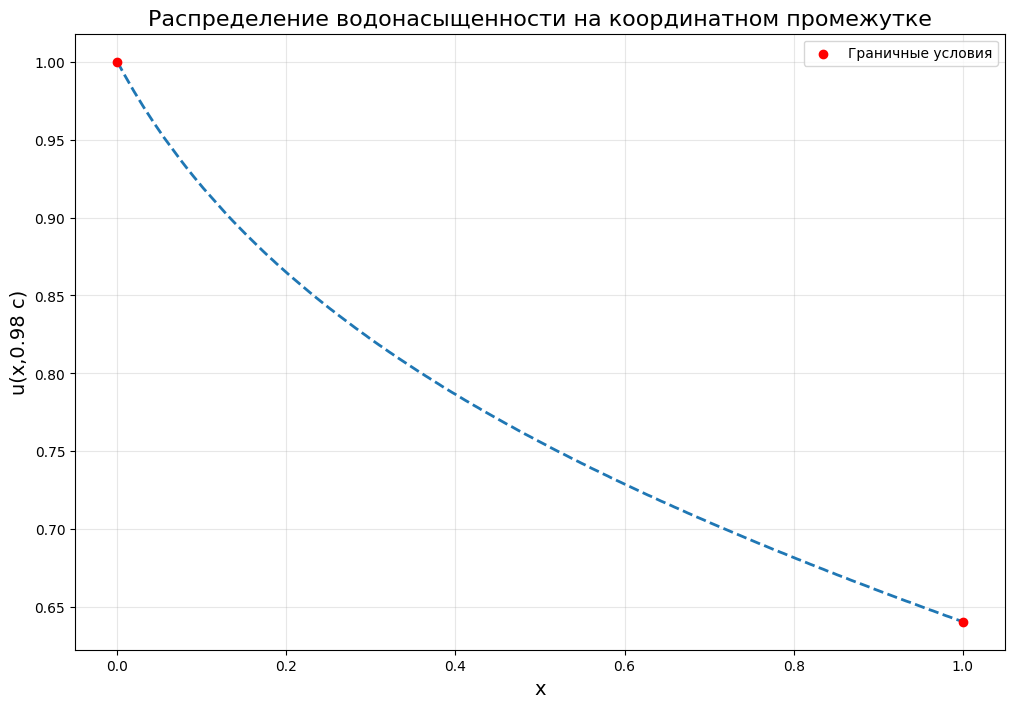

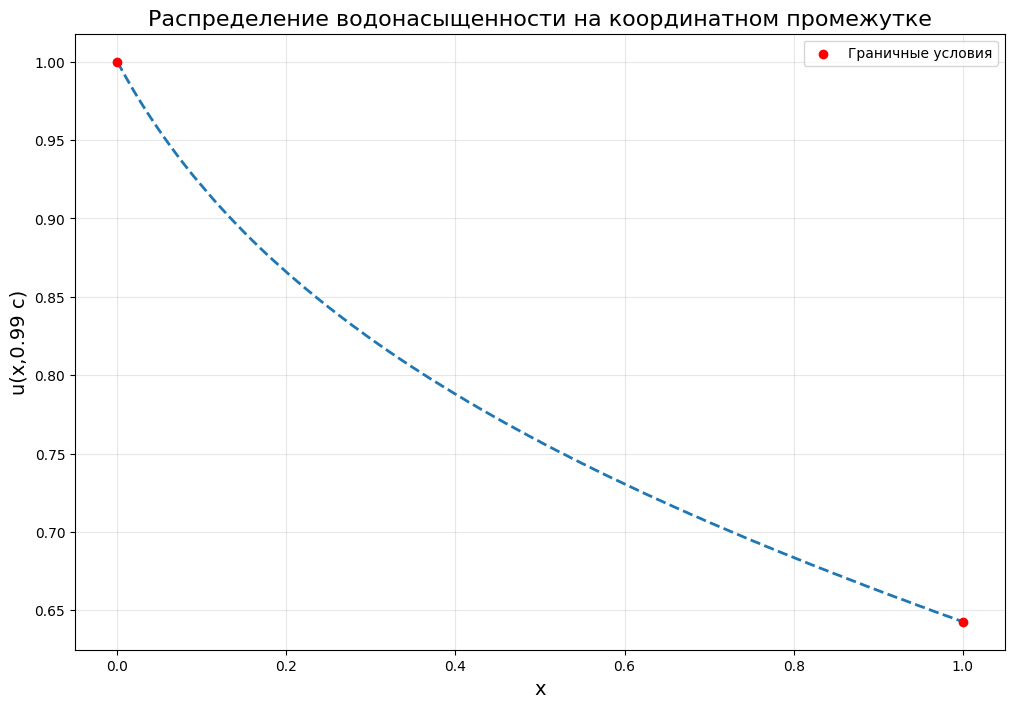

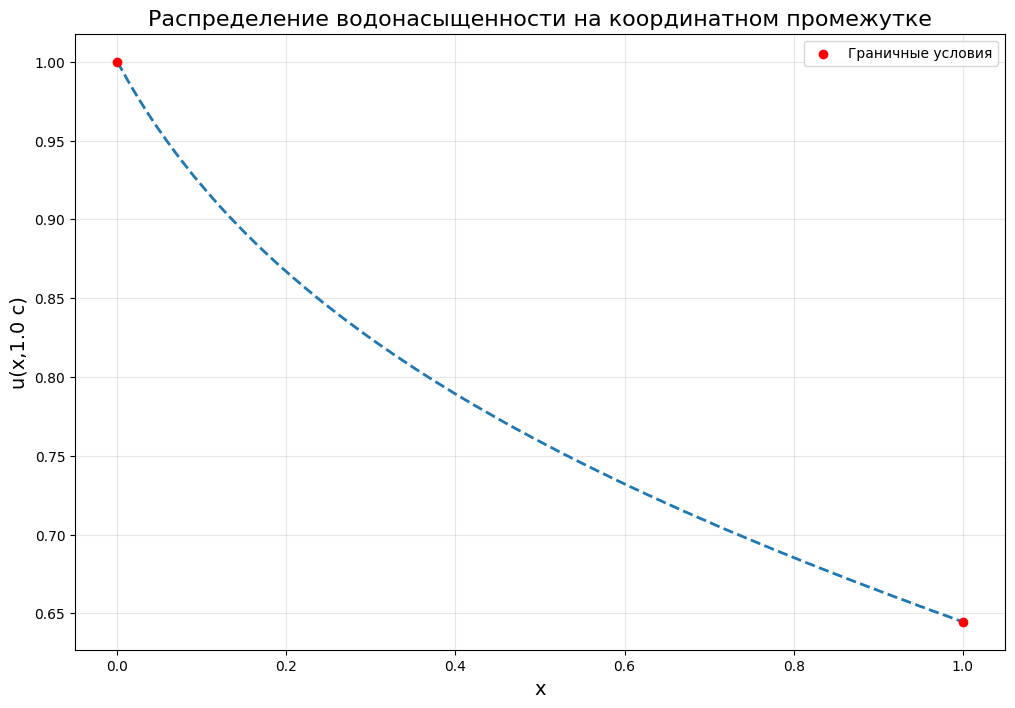

In [14]:
simple_plot_x_slices(x, t, value)

__Уравнение Баклея-Лаверетта в общем виде:__

_dS(x,t)/dt + N[S(x,t)] = 0, N - нелинейный дифф. оператор_

__Г.У.__: _S(x,0) = S_0(x)_

__Н.У.__: _S(x,t) = S_a(x,t) и S(x,t) = S_b(x,t)_



Т.е. для обучения модели нам нужно __три ошибки__: _значение_ __вычисленного уравнения__ _( поскольку оно равно нулю )_ + _ошибка по_ __Г.У.__ + _ошибка по_ __Н.У.__

In [5]:
def get_values(data, N_u, N_r):
    # Преобразуем массивы по x и t в 1D
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    
    # Извлечем реальные значения из датафрейма
    Exact_values = np.real(data['usol']).T
    
    # делаем сетку на пространстве x * t
    X, T = np.meshgrid(x,t)
    
    # Получим некий тензор сетки, первая координата - x, вторая - t 
    X_setka = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    
    # Значения функции в узлах сетки
    U_setka = Exact_values.flatten()[:,None]
    
    # Сделаем начальную сетку (0, 0) - (x_max, 0)
    X_0 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    
    # Получим значения функции в точках начальной сетки
    U_0 = Exact_values[0:1,:].T
    
    # Сделаем граничную сетку (0, 0) - (0, t_max) и (x_max, 0) - (x_max, t_max)
    X_x_min = np.hstack((X[:,0:1], T[:,0:1]))
    X_x_max = np.hstack((X[:,-1:], T[:,-1:]))
    X_b = np.vstack([X_x_min,X_x_max])
    
    # Получим значения функции в точках граничной сетки
    U_b_x_min = Exact_values[:,0:1]
    U_b_x_max = Exact_values[:,-1:]
    U_b = np.vstack([U_b_x_min,U_b_x_max])
    
    # Сетка для г.у. и н.у.
    X_u_train = np.vstack([X_0,X_b])
    
    # Значения функции в узлах X_u_train
    U_train = np.vstack([U_0,U_b])
    
    # Точки 0 и 1 по X
    lb = X_setka.min(axis=0)
    ub = X_setka.max(axis=0)
    
    # Генерируем значения в промежуточных точках для диффура (latin hypercube) размером N_r
    X_f_train = lb + (ub - lb)*lhs(2, N_r)
    
    # Семплируем из существующих точек для граничных условий
    idx = np.random.choice(X_u_train.shape[0], N_u)#, replace=False)
    X_u_train = X_u_train[idx,:]
    U_train = U_train[idx,:]
    
    return x, t, X, T, Exact_values, X_setka, U_setka, X_u_train, U_train, X_f_train, ub, lb

In [95]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=2000,
    decay_rate=0.95
)

tf_optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

# Improved network architecture
layers = [2] + [10]*10 + [1]

In [84]:
class NormalizationLayer(tf.keras.layers.Layer):
    def __init__(self, lb, ub, **kwargs):
        super(NormalizationLayer, self).__init__(**kwargs)
        self.lb = tf.constant(lb, dtype=tf.float32)
        self.ub = tf.constant(ub, dtype=tf.float32)
        
    def call(self, inputs):
        return 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
    
    def get_config(self):
        config = super(NormalizationLayer, self).get_config()
        config.update({
            'lb': self.lb.numpy().tolist(),
            'ub': self.ub.numpy().tolist()
        })
        return config

Делаем класс **PINN**

In [ ]:
class PINN(object):
    def __init__(self, layers, optimizer, logger, X_f, lb, ub):

        self.u_model = tf.keras.Sequential()
        self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        
        # нормируем входной слой
        #self.u_model.add(NormalizationLayer(lb, ub))
        
        #self.u_model.add(tf.keras.layers.Lambda(
        #    lambda X: 2.0 * (X - lb) / (ub - lb) - 1.0))

        self.u_model.add(tf.keras.layers.Rescaling(scale=2.0, offset=-1.0))

        # инициализируем слои НН
        for width in layers[1:-1]:
            self.u_model.add(tf.keras.layers.Dense(
                width, 
                activation=tf.nn.tanh,
                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                bias_initializer='zeros'
            ))

        #    self.u_model.add(tf.keras.layers.Dense(
        #      width, activation=tf.nn.tanh,
        #      kernel_initializer='glorot_normal'))
        
        # Последний будет ф-ией relu ( шоб ниже нуля не упало )
        self.u_model.add(tf.keras.layers.Dense(
            layers[-1], 
            activation=None,  # Linear activation for output
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        ))
        
        self.optimizer = optimizer
        self.logger = logger
        self.dtype = tf.float32
        
        # Фигачим в тензора
        self.x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
        self.t_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)
        
        self.X_f = tf.convert_to_tensor(X_f, dtype=self.dtype)
    
    @tf.function
    def loss_fn(self, X_u, u, loss_weights=None):
        if loss_weights is None:
            loss_weights = [1.0, 1.0]  # пока пусть ошибка по (Г.У. + Н.У.) и ур-ю одинаковой будет
            

        u_pred = self.u_model(X_u)
        data_loss = tf.reduce_mean(tf.square(u - u_pred))
        
        pde_loss = tf.reduce_mean(tf.square(self.f_model()))
        
        total_loss = loss_weights[0] * data_loss + loss_weights[1] * pde_loss
        return total_loss, data_loss, pde_loss
    
    def __wrap_training_variables(self):
        return self.u_model.trainable_variables
    


    # надо по гиперпараметрам пройтись тренировкой ( обратный град спуск )
    @tf.function
    def train_step(self, X_u, u, loss_weights=None):
        
        with tf.GradientTape() as tape:
            total_loss, data_loss, pde_loss = self.loss_fn(X_u, u, loss_weights)
        
        grads = tape.gradient(total_loss, self.__wrap_training_variables())
        self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
        
        return total_loss, data_loss, pde_loss
    
    @tf.function
    def f_model(self):

        # берем производные для ур-я Б-Л
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.x_f)
            tape.watch(self.t_f)

            X_f = tf.stack([self.x_f[:,0], self.t_f[:,0]], axis=1)
            u = self.u_model(X_f)
            
            Swc = 0.0
            Sor = 0.0
            M = 2.0
            
            numerator = tf.square(u)
            denominator = numerator + tf.square(1.0 - u) / M
            frac_org = numerator / (denominator + 1e-8)  # Add small epsilon for stability
            
            # крит точка
            Sf = tf.sqrt((1.0/M) / (1.0/M + 1.0))
            numerator_Sf = tf.square(Sf - Swc)
            denominator_Sf = numerator_Sf + tf.square(1.0 - Sf - Sor) / M
            frac_Sf = numerator_Sf / (denominator_Sf + 1e-8)
            

            linear_part = (frac_Sf / Sf) * u
            f_u = tf.where(u < Sf, linear_part, frac_org)
    
        u_t = tape.gradient(u, self.t_f)
        u_x = tape.gradient(u, self.x_f)
        f_u_x = tape.gradient(f_u, self.x_f)
        
        del tape
        
        # полученное зн-е ур-я после предикта : u_t + f(u)_x = 0
        return u_t + f_u_x
    
    def fit(self, X_u, u, tf_epochs, loss_weights=None):
        
        self.logger.log_train_start(self)
        
        
        X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
        u = tf.convert_to_tensor(u, dtype=self.dtype)
        
        # адамом решено 
        self.logger.log_train_opt("Adam")
        
        for epoch in range(tf_epochs):
            
            # по эпохам будем менять вес ошибок, а то на последних он ближе к диффуру чем к г.у.
            #if epoch < 1000:
            #    loss_weights = [10.0, 1.0]
            #elif epoch < 5000:
            #    loss_weights = [5.0, 1.0]
            #else:
            #    loss_weights = [1.0, 1.0]
            
            total_loss, data_loss, pde_loss = self.train_step(X_u, u, loss_weights)
            
            if epoch % self.logger.frequency == 0:
                custom_info = f"data_loss: {data_loss:.2e}, pde_loss: {pde_loss:.2e}"
                self.logger.log_train_epoch(epoch, total_loss, custom_info)
    
    def predict(self, X):
        return self.u_model(X)
    
def save_model(model, save_dir="pinn_model_without_norm.keras"):

    model.u_model.save(save_dir)
    print(f"Модель сохранена в {save_dir}")

In [97]:
class Logger(object):
    def __init__(self, frequency=100):
        self.start_time = time.time()
        self.frequency = frequency

    def __get_elapsed(self):
        return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")

    def log_train_start(self, model):
        print("\nTraining started")
        print("================")

    def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
        if epoch % self.frequency == 0:
            # Больше не выводим error, только потери
            print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e} {custom}")

    def log_train_opt(self, name):
        print(f"—— Starting {name} optimization ——")

    def log_train_end(self, epoch, custom=""):
        print("==================")
        print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()} {custom}")

Пробуем построить предиктивную модель

In [98]:
x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f, ub, lb = get_values(data, 456, 5000)
    
tf_epochs = 5000
logger = Logger(frequency=200)
    
pinn = PINN(layers, tf_optimizer, logger, X_f, ub, lb)
    
# УБИРАЕМ функцию error, которая использовала реальные данные внутри области
# Вместо этого будем следить только за data_loss и pde_loss
    
pinn.fit(X_u_train, u_train, tf_epochs)

save_model(pinn)
    
# Предсказание на всей сетке для визуализации
#u_pred = pinn.predict(X_star)


Training started
—— Starting Adam optimization ——
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tf_epoch =      0  elapsed = 00:02  loss = 1.0813e+00 data_loss: 2.21e-01, pde_loss: 8.60e-01
tf_epoch =    200  elapsed = 00:03  loss = 8.0992e-03 data_loss: 5.68e-03, pde_loss: 2.41e-03
tf_epoch =    400  elapsed = 00:04  loss = 6.7059e-03 data_loss: 4.44e-03, pde_loss: 2.27e-03
tf_epoch =    600  elapsed = 00:05  loss = 5.8047e-03 data_loss: 4.13e-03, pde_loss: 1.67e-03
tf_epoch =    800  elapsed = 00:06  loss = 1.3567e-02 data_loss: 4.74e-03, pde_loss: 8.83e-03
tf_epoch =   1000  elapsed = 00:07  loss = 6.0670e-03 data_loss: 3.66e-03, pde_loss: 2.41e-03
tf_epoch =   1200  elapsed = 00:09  loss = 4.2875e-03 data_loss: 3.14e-03, pde_loss: 1.15e-03
tf_epoch =   1400

TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

In [88]:
u_pred = pinn.predict(X_star)

In [10]:
x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f, ub, lb = get_values(data, 456, 300)

In [11]:
#u_pred = loaded_model.predict(X_star)

In [ ]:
loaded_model = tf.keras.models.load_model("pinn_model2.keras")

Построим графики

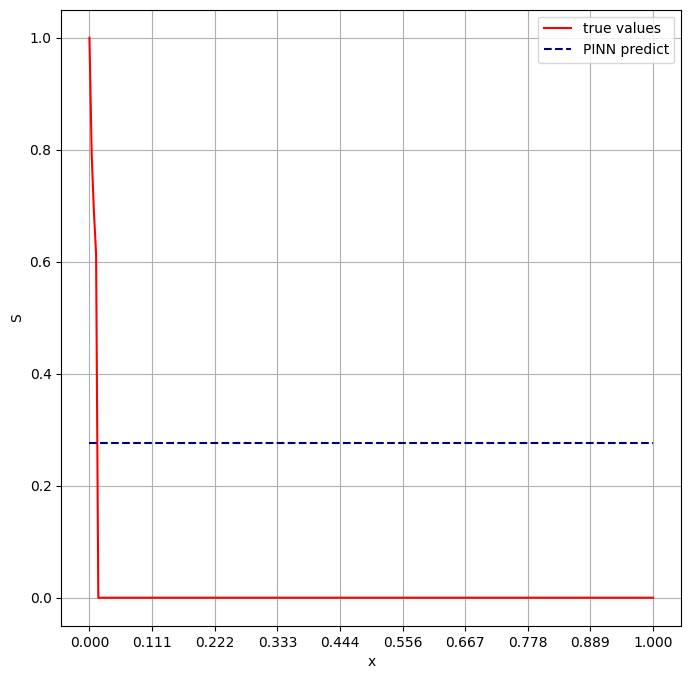

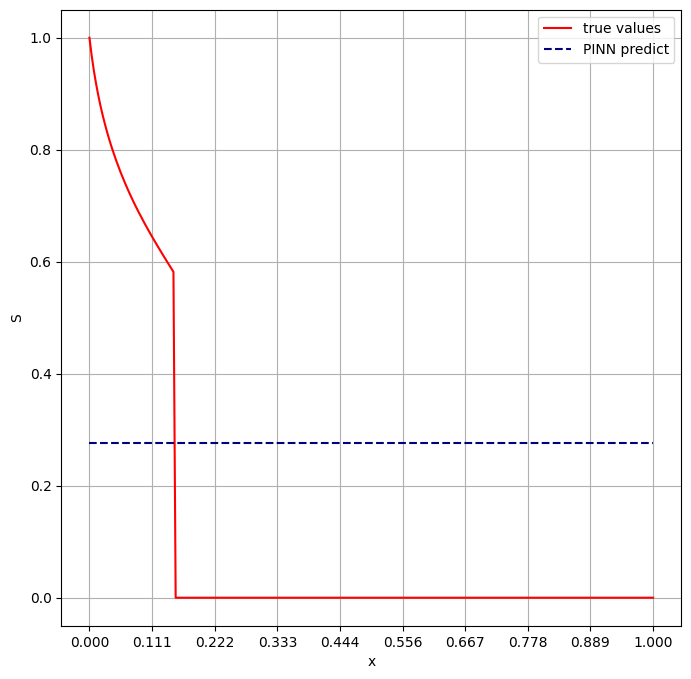

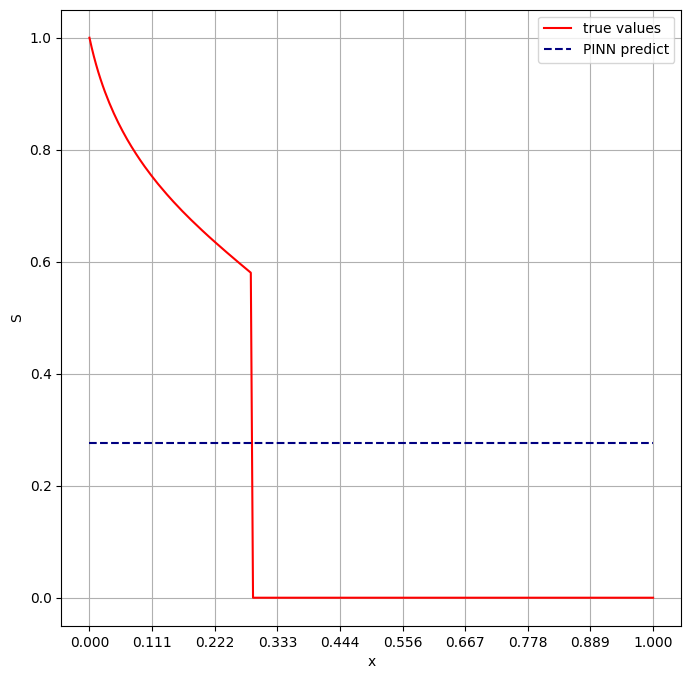

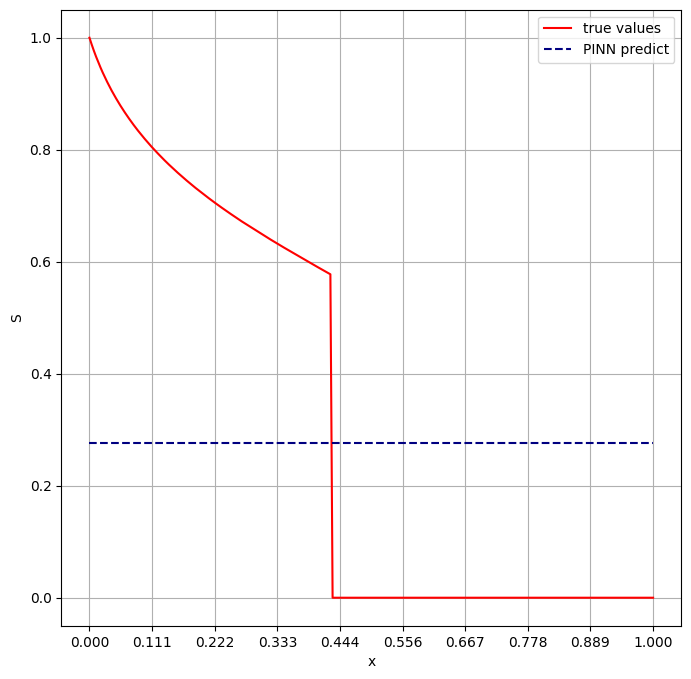

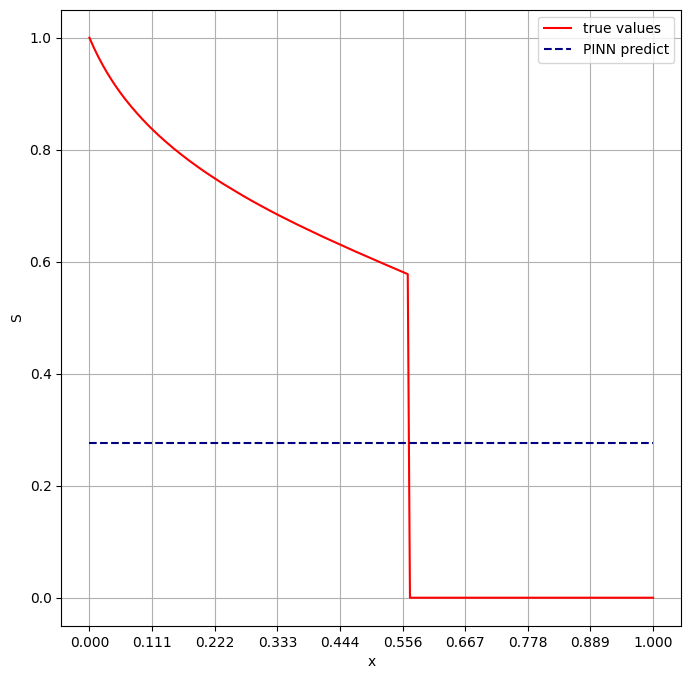

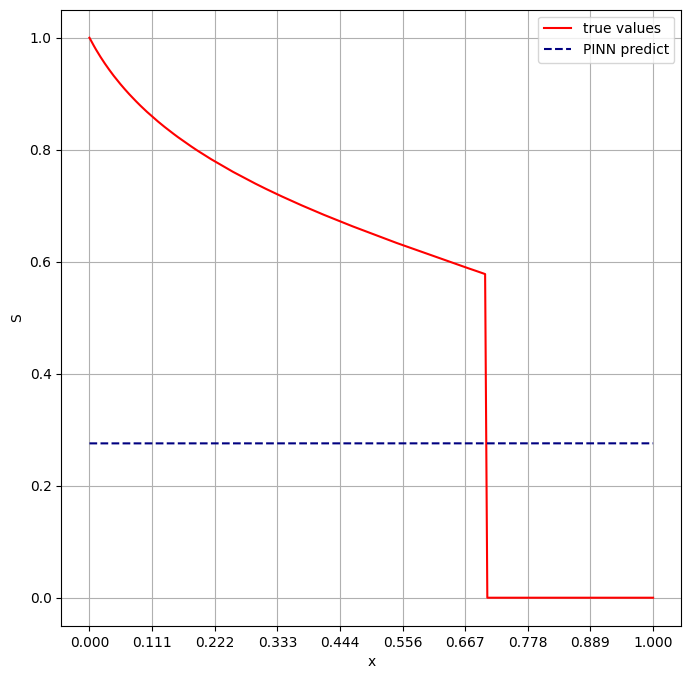

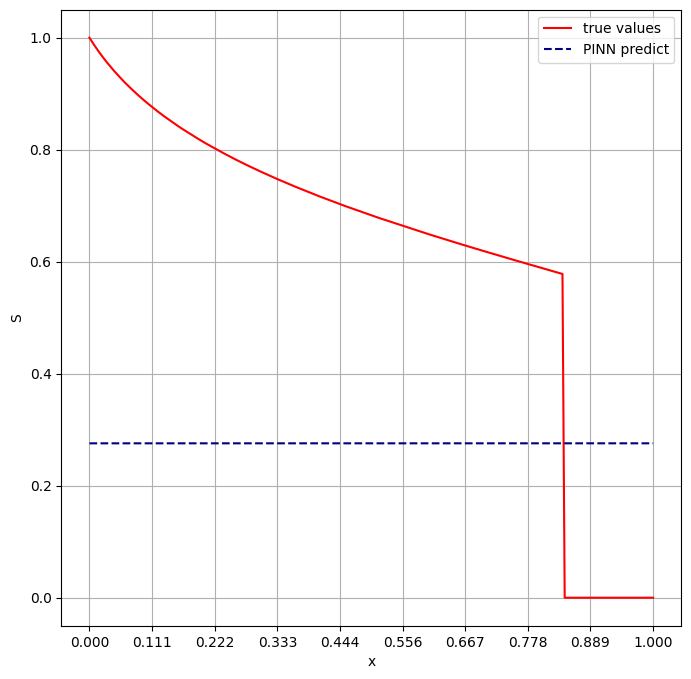

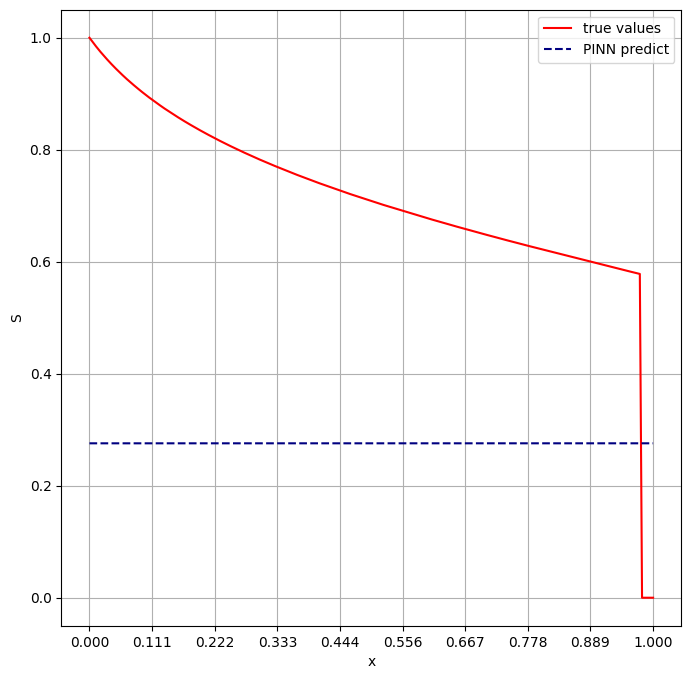

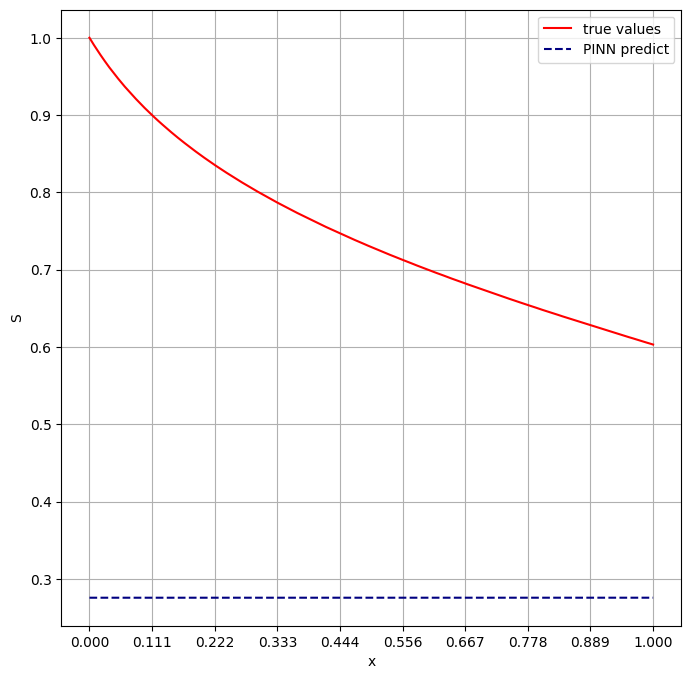

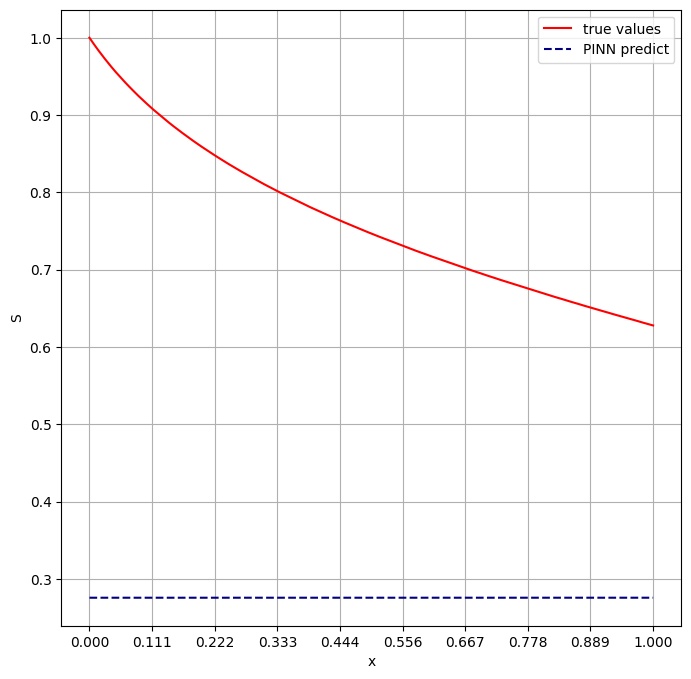

In [89]:
Uniq_time_array = []

Uniq_time_array.append(X_star[0,1])

for x in X_star[:,1]:
    if x not in Uniq_time_array:
        Uniq_time_array.append(x)

x_ticks = np.linspace(0,1,10)

for i in range(1,len(Uniq_time_array[:-1]),10):

    S_array = []
    X_array = []
    S_true_array = []
    check_time = Uniq_time_array[i]
    count = 0

    t = X_star[0,1]

    while t != check_time:
        count = count + 1
        t = X_star[count,1]
    

    while check_time == Uniq_time_array[i]:
        X_array.append(X_star[count,0])
        S_array.append(u_pred[count])
        S_true_array.append(u_star[count])
        count = count + 1
        check_time = X_star[count,1]
        
    
    fig = plt.figure(figsize=(8,8))
    plt.plot(X_array,S_true_array,"-r", label = 'true values')
    plt.plot(X_array,S_array, color='navy', label = 'PINN predict', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('S')
    plt.legend()
    #plt.title('t='+str((Uniq_time_array[i])))
    plt.grid()
    plt.xticks(x_ticks)

    #filename = f'pictures/temp/plot_{Uniq_time_array[i]:.3f}.png'
    #plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model("pinn_model_without_norm.keras")

In [ ]:
u_pred = loaded_model.predict(X_star)

800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step


In [ ]:
u_pred

array([[0.26016766],
       [0.26016766],
       [0.26016766],
       ...,
       [0.26016572],
       [0.26016572],
       [0.26016572]], shape=(25600, 1), dtype=float32)

In [53]:
loaded_model = tf.keras.models.load_model("pinn_model_without_norm_jup.keras")

ValueError: Requested the deserialization of a `Lambda` layer whose `function` is a Python lambda. This carries a potential risk of arbitrary code execution and thus it is disallowed by default. If you trust the source of the artifact, you can override this error by passing `safe_mode=False` to the loading function, or calling `keras.config.enable_unsafe_deserialization().

In [55]:
lb

array([0., 0.])

In [60]:
ub

array([1., 1.])

In [58]:
a = np.array([0,0])

In [59]:
a

array([0, 0])